---
# Diagnosis of mechanical rotor faults in drones using functional gaussian mixture classifier
B. Bartoszewski,
K. Jarzyna
---

---

### Problem formulation [0-4 pts]:
  - is the problem clearly stated [1 pt]
  - what is the point of creating model, are potential use cases defined [1 pt]
  - where do data comes from, what does it containt [1 pt]
  - DAG has been drawn [1 pt]
  - confoundings (pipe, fork, collider) were described [1 pt]

#### *Detection of Drone Propeller Damage*

<style>
.justify {
    text-align: justify;
}
</style>

<div class="justify">
A program has been developed for detecting damage to drone propellers, based on data from the accelerometer and gyroscope. The system analyzes changes in the drone's vibrations and movements, allowing for early detection of anomalies indicating mechanical damage to the propellers. This enables quick corrective actions, minimizing the risk of further damage, and improving the safety and reliability of drone operations.
</div>



#### *Potential use*
<style>
.justify {
    text-align: justify;
}
</style>

<div class="justify">
By analyzing vibration patterns, the system can quickly identify anomalies that may suggest damage or wear of components. When unusual vibrations are detected, the system immediately alerts the operator, enabling prompt actions such as controlled landing for inspection and potential replacement of damaged parts.

Using this program can reduce the risk of multirotor flights and decrease the operational cost of drones by mitigating the potential destruction of the entire drone or surrounding infrastructure.
</div>



#### *Collecting Data*
<style>
.justify {
    text-align: justify;
}
</style>

<div class="justify">
The data was collected by our own. To gather data, flights were conducted using an eight-rotor drone. Initially, flights were carried out with all propellers in good condition, followed by series of flights with one damaged propeller measuring 1.5 cm in length. Subsequently, the damaged propeller was replaced with one measuring 3 cm in length, and the series of tests continued.
</div>

<style>
.justify {
    text-align: justify;
}
.center {
    display: block;
    margin-left: auto;
    margin-right: auto;
    width: 50%;
}
</style>

<div class="justify">
</div>
<p style="text-align: center;">A healthy drone used for collecting data.</p>
<img src="photos/IMG_3984.JPEG" alt="Photo of drone to collect data" class="center"/>

<p style="text-align: center;">One propeller cut 1.5 cm</p>
<img src="photos/1_5cm.jpg" alt="Photo of drone to collect data" class="center"/>

<p style="text-align: center;">One propeller cut 3 cm</p>
<img src="photos/3cm.jpg" alt="Photo of drone to collect data" class="center"/>





<style>
.justify {
    text-align: justify;
}
</style>

<div class="justify">

The system used in the drone is [Ardupilot](https://ardupilot.org/). It is an open-source autopilot designed for controlling, among other things, unmanned aerial vehicles.

One of the important features of ArduPilot is the ability to record flight data onto an external SD card. The capability of collecting flight logs was utilized, where the appropriate [logging parameters](https://ardupilot.org/copter/docs/parameters.html#log-bitmask) needed to be selected before the flight to gather data from the flights.

</div>

<p style="text-align: center;">Set <a href="https://ardupilot.org/copter/docs/parameters.html#log-bitmask" target="_blank">logging parameters</a></p>
<img src="https://ardupilot.org/copter/_images/mp_dataflash_log_bitmask.png" alt="Opis obrazu" width="1000"  class="center"/>

---
### Data preprocessing   [0-2 pts]:
- is preprocessing step clearly described [1 pt]
- reasoning and types of actions taken on the dataset have been described [1 pt]



#### *Data preprocessing*

<style>
.justify {
    text-align: justify;
}
</style>

<div class="justify">

After collecting data, files from the `logs_from_flights` folder were replayed in the [UAV Log Viewer](https://plot.ardupilot.org/) program to export data from the gyroscope and accelerometer. This program was used because it allowed for a clear visualization of the drone's flight trajectory and ensured that the exported data corresponded to the appropriate flights with the relevant damages.
</div>



<style>
.justify {
    text-align: justify;
}
.center {
    display: block;
    margin-left: auto;
    margin-right: auto;
    width: 50%;
}
</style>

<div class="justify">
</div>
<p style="text-align: center;">Data visualization in <a href="https://plot.ardupilot.org/" target="_blank">UAV Log Viewer</a></p>
<img src="photos/uav_logs.png" alt="Opis obrazu" width="27530"  class="center"/>


<style>
.justify {
    text-align: justify;
}
</style>

<div class="justify">
In file preprocessing.ipynb was made preprocessing from data whitch was generated in UAV Log Viewer. We saved thee types of data:

- accelerometer data in the time domain
- gyroscope data in the frequency domain
- gyroscope data in the frequency domain with accumulation

</div>

At the beginning, Euclidean normalization of the data was performed to reduce the dimensions to one.

$$
\|\mathbf{acc}\|_2 = \sqrt{acc_x^2 + acc_y^2 + acc_z^2}
$$

<p style="text-align: center;">Data saved and normalized from the accelerator </p>
<img src="photos/data_from_acc_1.png" alt="Opis obrazu" width="900"  class="center"/>

The same operation was performed for the gyroscope.

<p style="text-align: center;">Data saved and normalized from the accelerator </p>
<img src="photos/gyro_3.png" alt="Opis obrazu" width="900"  class="center"/>

The data was subjected to the removal of unit jumps that occur during takeoff and landing, which could reduce the model's effectiveness. Additionally, gyroscope data was subjected to Fourier transformation to examine how vibrations behave at different frequencies. 

<p style="text-align: center;">Gyroscope data after the Fourier transform.</p>
<img src="photos/gyro_fft_1.png" alt="Opis obrazu" width="900"  class="center"/>


Before exporting the data to the model, the flight data was divided into segments every 1.5 seconds. This aims to match the input data to the models, where the first and second models have a sliding window, and the third model aggregates the data.
</div>



---
### Model [0-4 pts]:
- are models sufficiently described (what are formulas, what are parameters, what data are required ) [1 pt] 
- are difference between two models explained [1 pt]  
- is the difference in the models justified (e.g. does adding aditional parameter makes sense? ) [1 pt]  
- are two different models specified [1 pt]

We decided to use Bayesian Mixture Model as our binary classifier. We assume that a given measurement, $y$, represented using B-spline basis can be drawn from one of $M$ data generating processes (which represents our fault classes), each described by unique set of parameters. To create this model, we need to build the likelihood function and then use it to develop the posterior distribution. 

Data generating process is given by

$$ y \sim Normal(\mu, \sigma) $$
$$ \mu = \sum_{m=1}^M \beta_m \phi_m(t) $$

where $y$ is sampled signal with uncertanity of normal distribution given by $\sigma$. Functions $\phi_m(t)$ are B-splines on assigned M knot grid. $\mu$ represents transformed parameters of the model, as it corresponds to the mean of fitted distribution of each class. $\beta_m$ are terms regulating each spline values, all are descirbed by normal distribution

$$ \beta_m \sim Normal(\mu_b,\sigma_b) $$

Our two model differs in number of used splines to represent signals, the more we use the better we can approximate signal with respect to local phenomenas however we are also greatly increasing computational time and risk overfitting. First model uses 15 splines and second 27. We decided on this numbers because initial experiments yielded promising results with low number of basis functions, however increasing them one by one was slowly improving correct classifications.


---
### Necessary imports

In [1]:
import numpy as np
from numpy.random import normal
import matplotlib.pyplot as plt
import matplotlib as mpl
from cmdstanpy import CmdStanModel
import arviz as az
import pandas as pd
import scipy.stats as stats

from DA_tools.DA_tools import ribbon_plot
from DA_tools.FDA_data_prepare import create_spline_matrix
from DA_tools.FDA_prepare_model import prepare_data, get_results
from DA_tools.DA_contraction_z_score import get_z_contr
from DA_tools.DA_colors import *

plt.style.context("seaborn-white")
mpl.rcParams["figure.dpi"] = 200
acc_healthy = pd.read_csv('data_preprocesed/acc_healthy_samples.csv')
acc_healthy_data = np.array([acc_healthy[col].values for col in acc_healthy.columns if col.startswith('Sample')])

/Users/kacperjarzyna/opt/anaconda3/envs/stan/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


---
### Priors [0-4 pts]:
- Have prior predictive checks been done for parameters (are parameters simulated from priors make sense) [1 pt]
- How prior parameters were selected [1 pt]
- Have prior predictive checks been done for measurements (are measurements simulated from priors make sense) [1 pt]
- Is it explained why particular priors for parameters were selected [1 pt]


We have chosen following priors for both of our models:
$$ \sigma \sim Exponential(1) $$
$$ \beta \sim Normal(0,1) $$

For $\beta$, we selected a weakly informative prior - uniform distribution since we didn't have a strong rationale for choosing a different one due to nature of representing signal as a set of basis functions. For $\sigma$, we opted for an exponential prior because its thicker tail provides greater flexibility. Since it's binary classifier number of classes $M$ is equal to 2 (damaged, healthy).

With priors chosen we proceed to prior predictive analysis for first model, it's worth noting that we calculate prior only for one class since it's the exact same process for both classes.

In [2]:
prior_model_1 = CmdStanModel(stan_file='stan/prior_check.stan')

num_knots = 13
N = 150
times = np.linspace(0,N*10,N)
knot_list = np.quantile(times,np.linspace(0,1,num_knots))
B0 = create_spline_matrix(N, times, 3, num_knots)

data_ppc = {
    "N": N,
    "K": num_knots+2,
    "X": B0
}
ppc_samples = prior_model_1.sample(data=data_ppc)


19:30:11 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status


chain 1 |█▎        | 00:00 Iteration: 100 / 1000 [ 10%]  (Sampling)


chain 1 |██▎       | 00:00 Iteration: 300 / 1000 [ 30%]  (Sampling)


chain 1 |███▋      | 00:00 Iteration: 600 / 1000 [ 60%]  (Sampling)



chain 1 |████▌     | 00:00 Iteration: 800 / 1000 [ 80%]  (Sampling)


chain 1 |██████████| 00:01 Sampling completed                      
chain 2 |██████████| 00:01 Sampling completed
chain 3 |██████████| 00:01 Sampling completed                      
chain 4 |██████████| 00:01 Sampling completed                      


19:30:12 - cmdstanpy - INFO - CmdStan done processing.


Since model uses 15 different $\beta$ plotting all of them is rather confusing than helpful, that's why we decided to show only one $\beta$ and $\sigma$

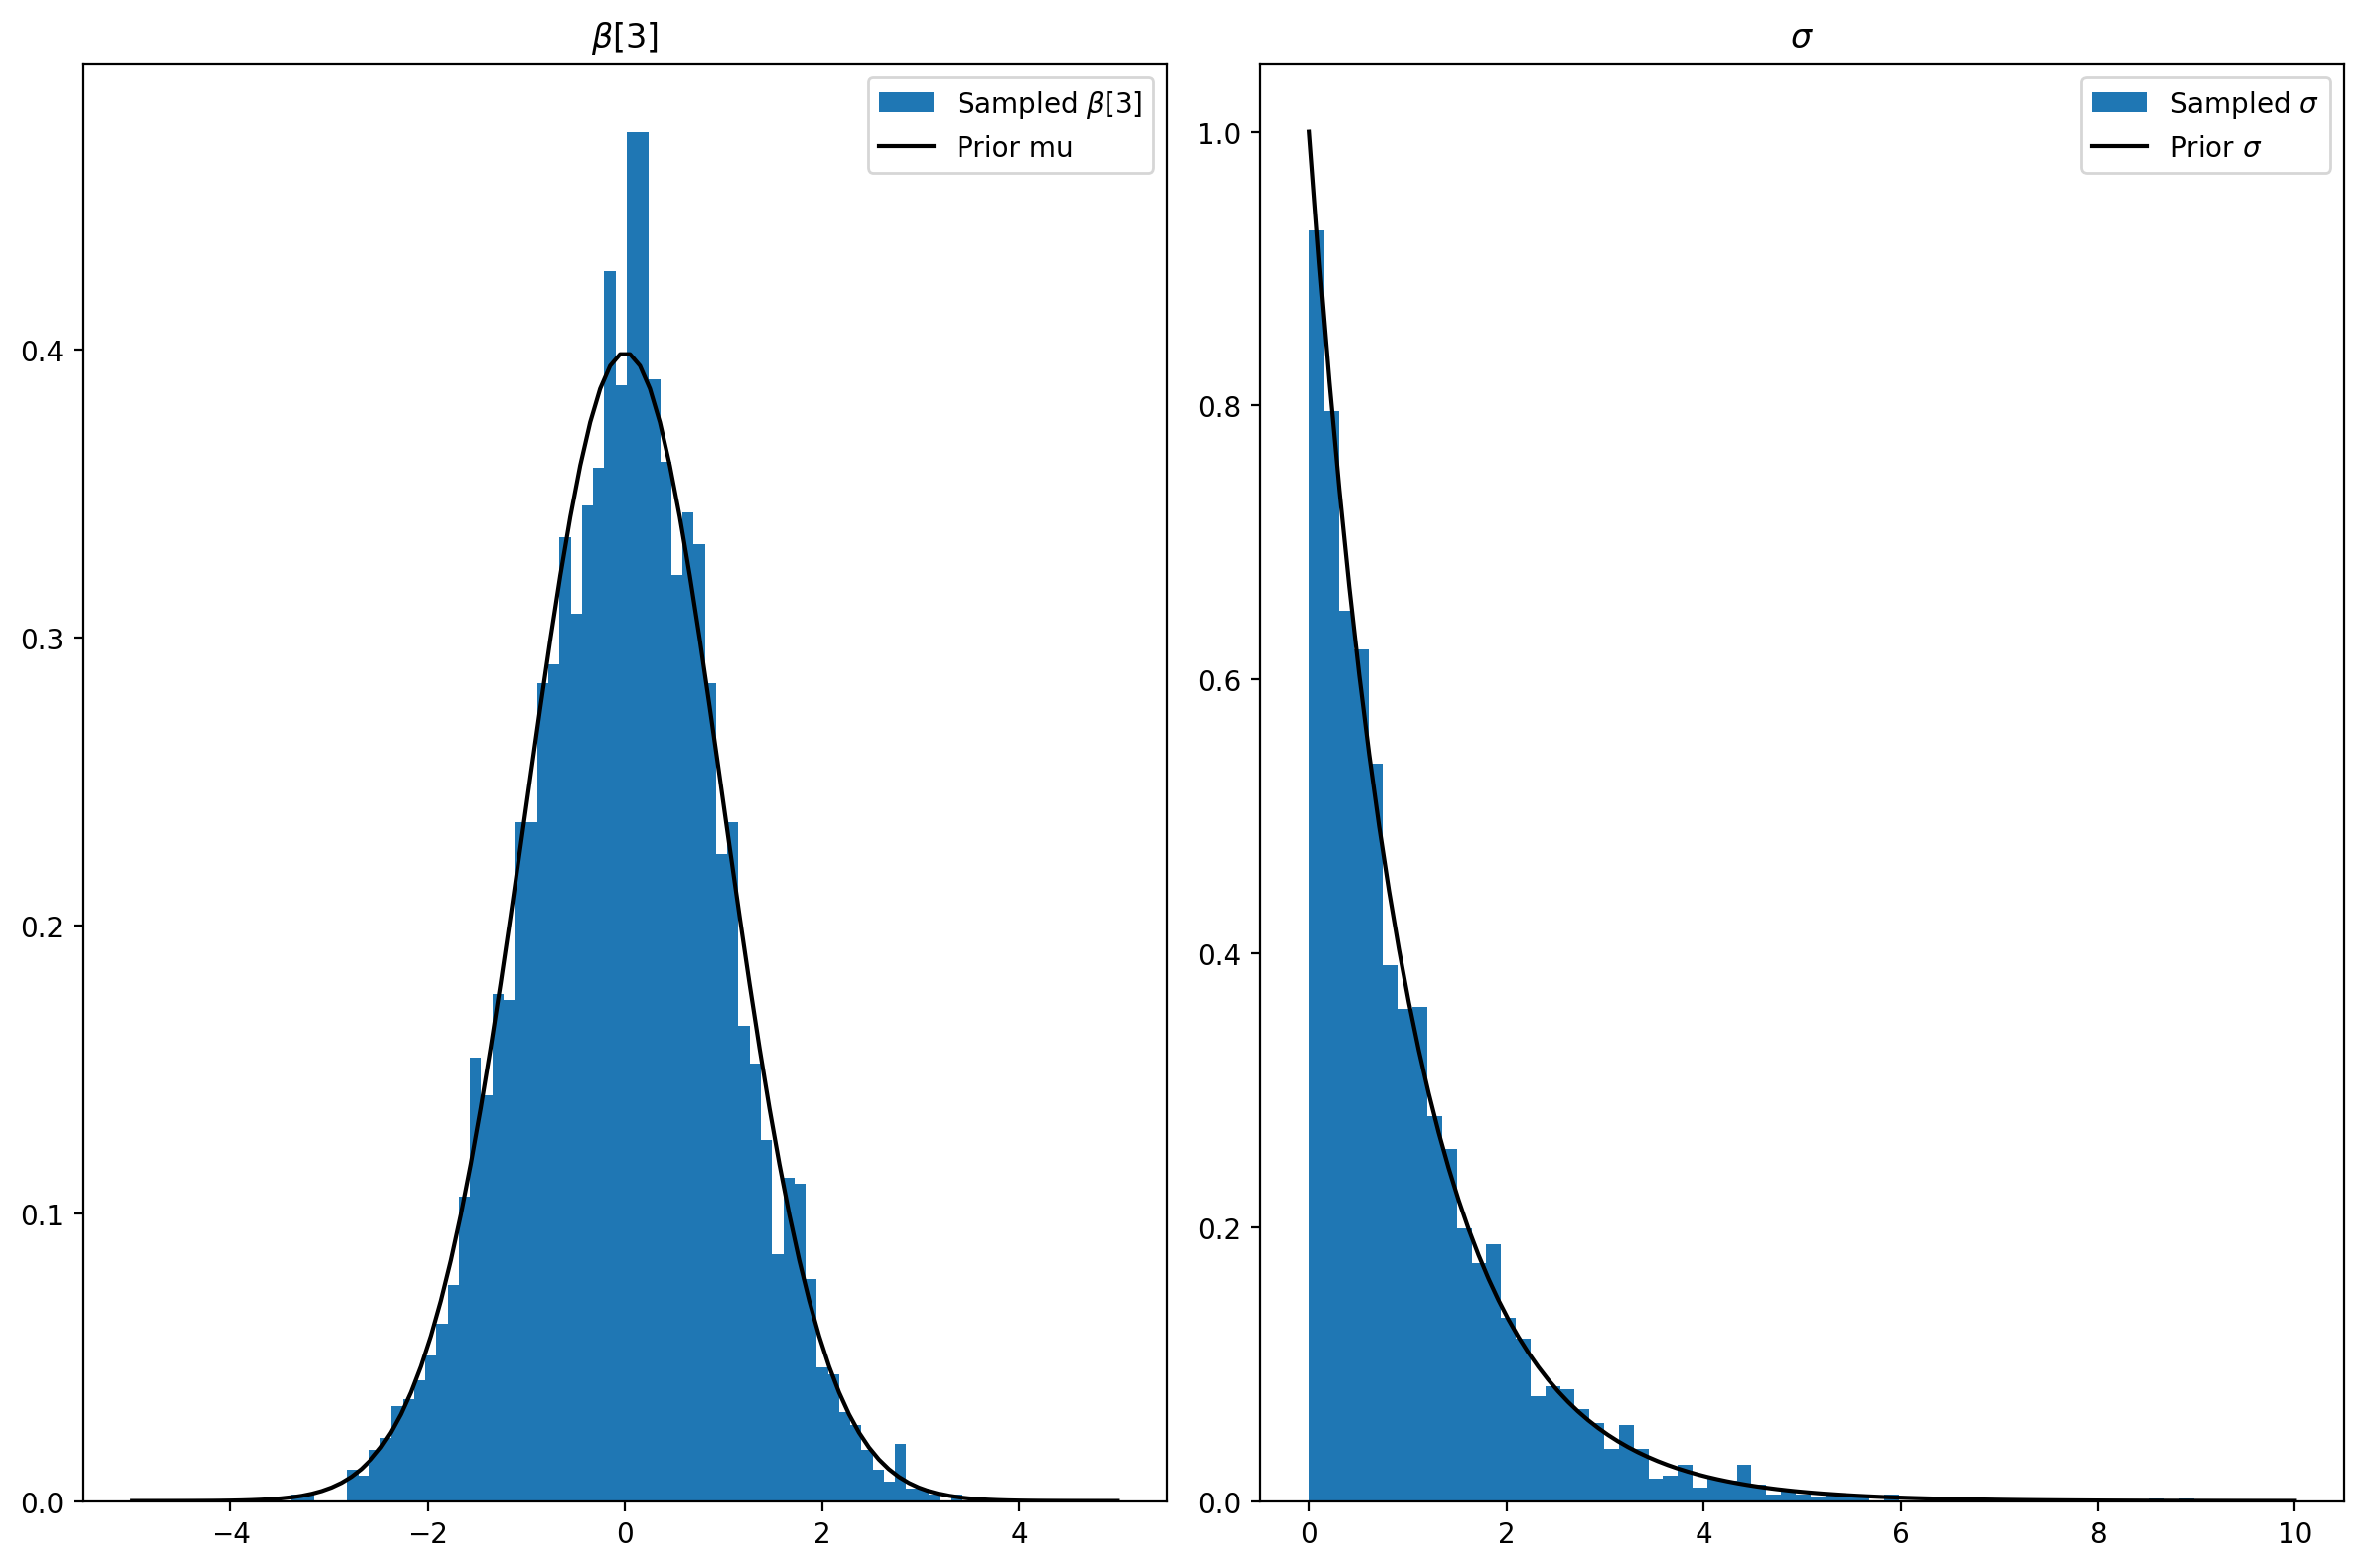

In [3]:
beta_pred= ppc_samples.stan_variable('betas')[:,2]
sigmas_pred = ppc_samples.stan_variable('sigma')[:]
fig,axes = plt.subplots(1,2,figsize = (12,8), tight_layout=True)

x = np.linspace(-5, 5, 100)
y = stats.norm.pdf(x=x,loc=0,scale=1)
axes[0].hist(beta_pred, bins=60,label=r'Sampled $\beta[3]$',density=True)
axes[0].set_title(r'$\beta[3]$')
axes[0].plot(x,y,label = 'Prior mu',color='k')
axes[0].legend()

x = np.linspace(0,10,100)
y = stats.expon.pdf(x=x,scale=1)
axes[1].hist(sigmas_pred, bins=60,label=r'Sampled $\sigma$',density=True)
axes[1].set_title(r'$\sigma$')
axes[1].plot(x,y,label=r'Prior $\sigma$',color='k')
axes[1].legend()


We present samples generated by our model by using ribbon plot on which we can see 90th percentile of generated samples and for comparison we are showing in black real signal from healthy drone. As we can see our model is capable of generating shape of a signal.

Text(0.0, 1.0, 'Real signal')

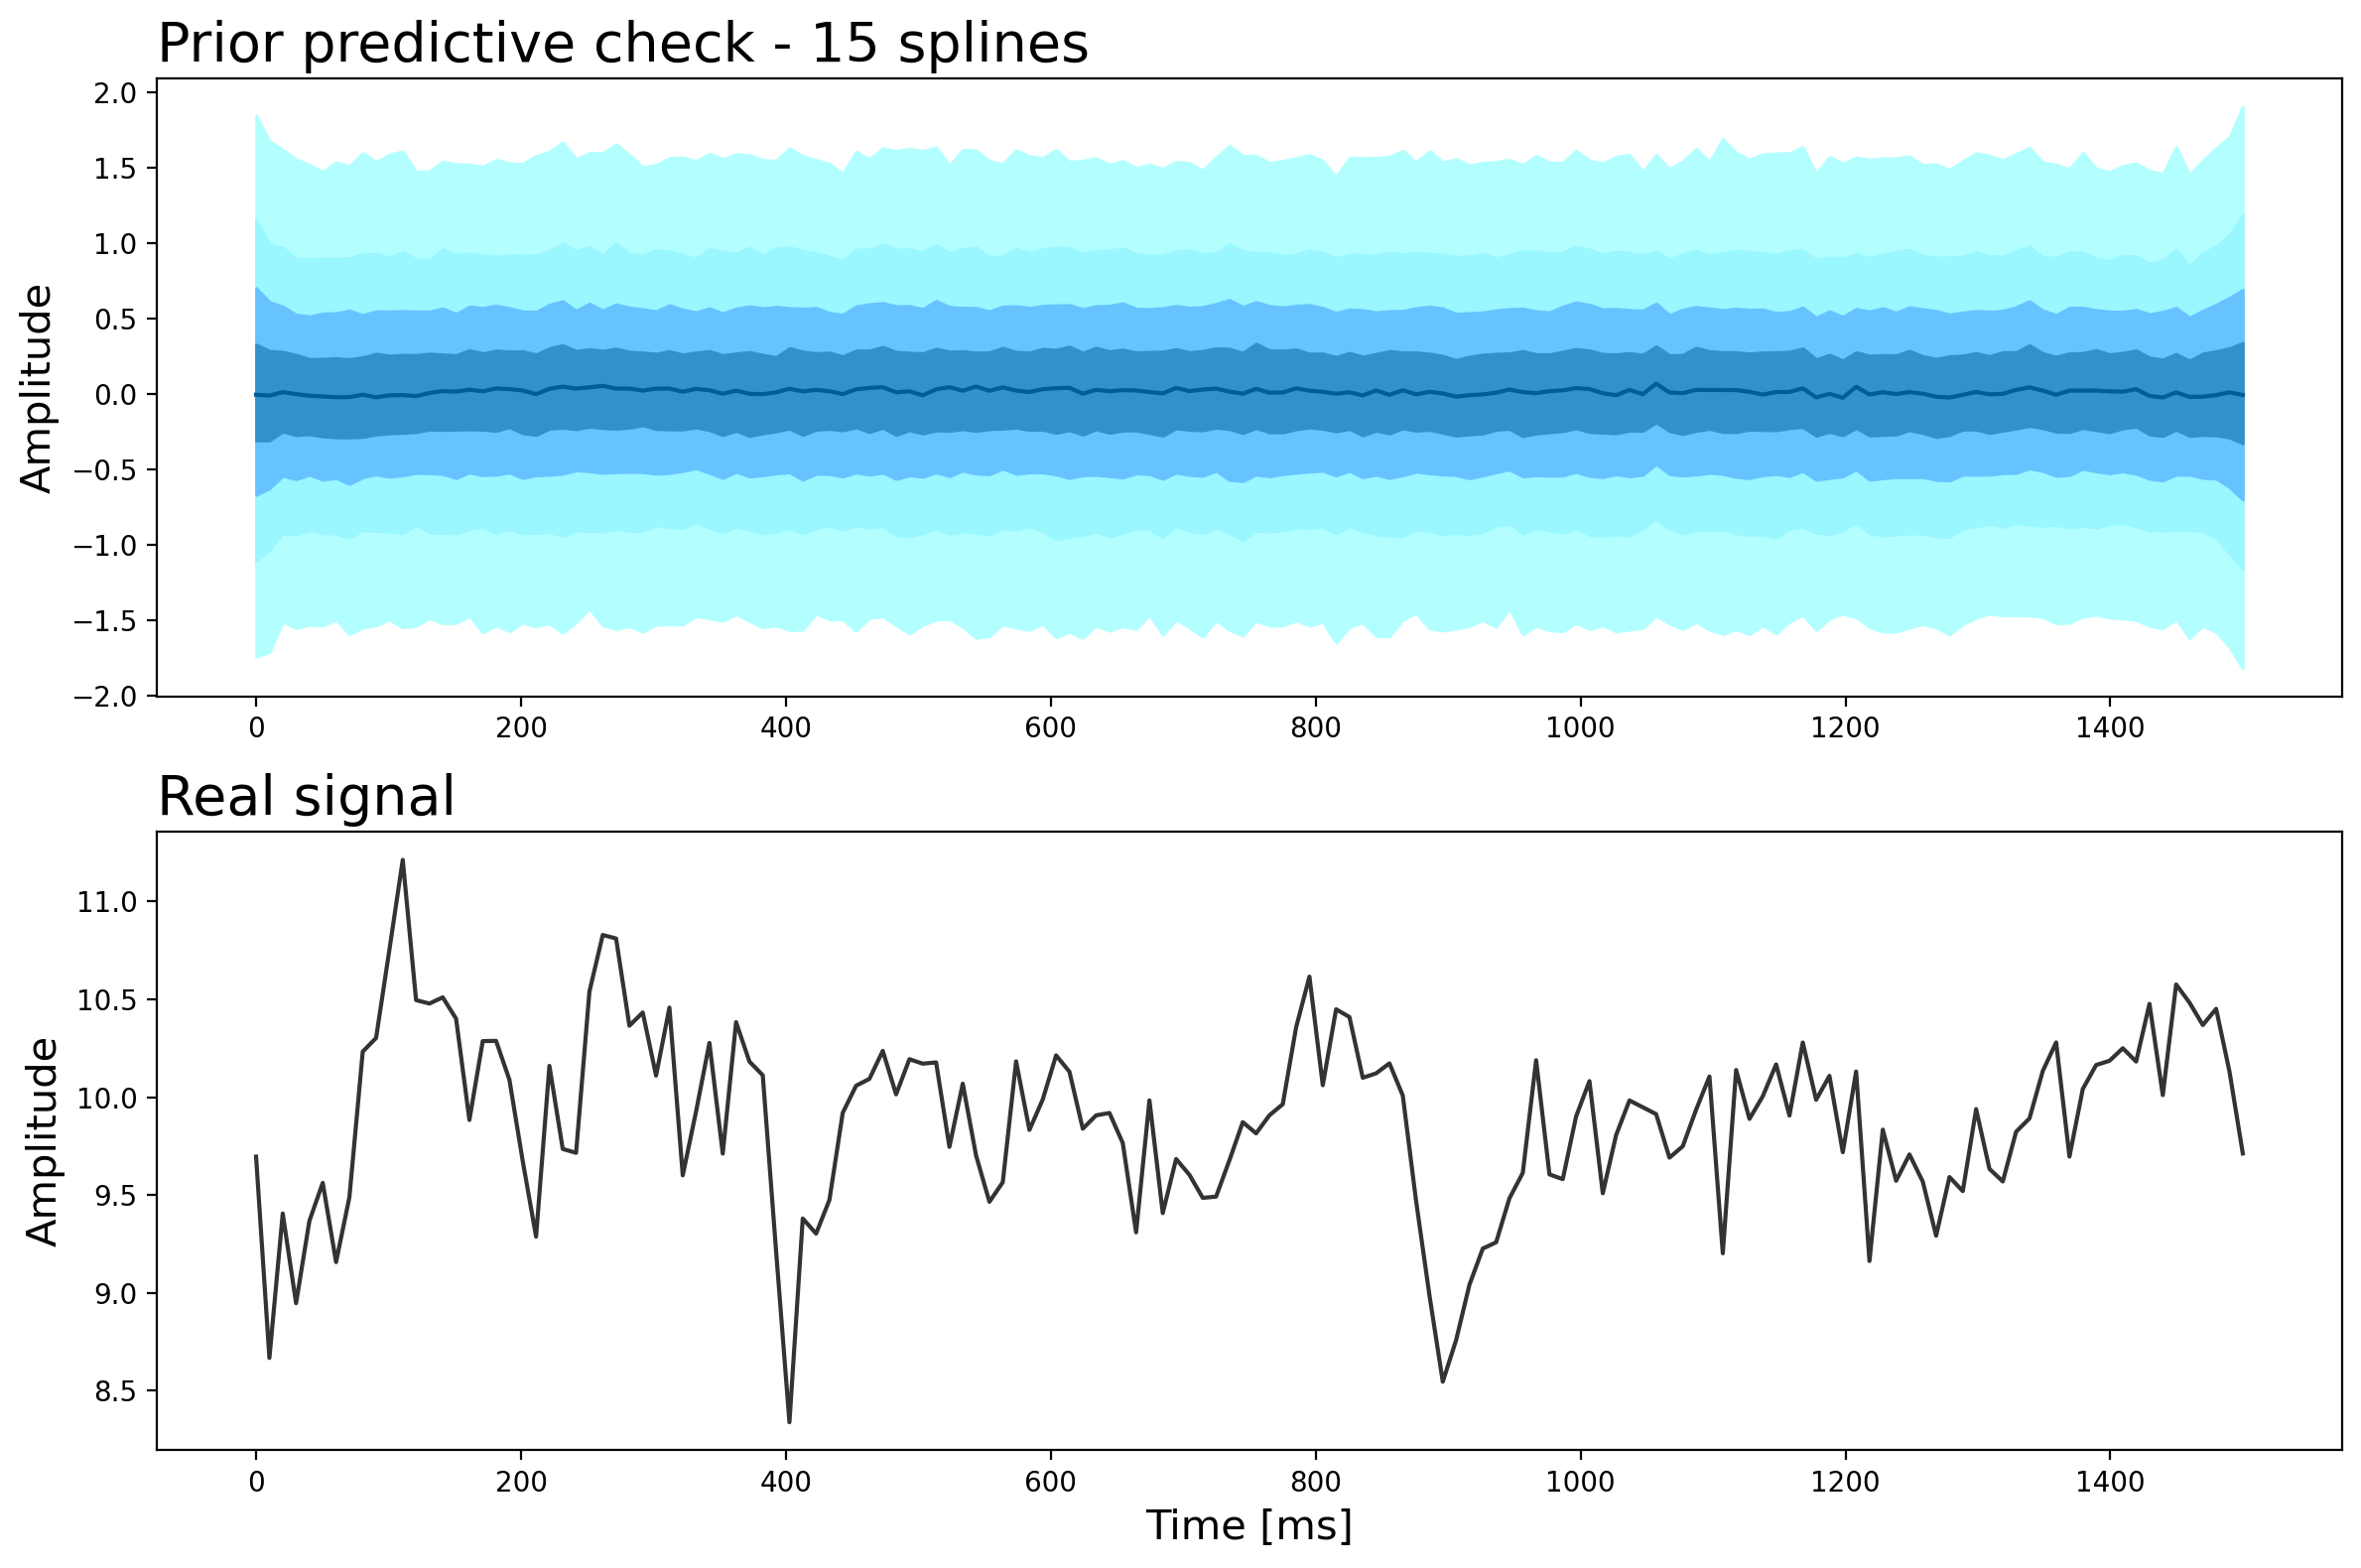

In [4]:
x = np.linspace(0,1500,N)
fig,axes = plt.subplots(2,1,figsize = (12,8), tight_layout=True)
pred = ppc_samples.stan_variable('y_pred')
axes[0] = ribbon_plot(x,pred,axes[0],supress_warning=True,probs = [10, 20, 30, 40, 50, 60, 70, 80, 90])
axes[1].set_xlabel('Time [ms]',fontsize = 15)
axes[0].set_ylabel('Amplitude',fontsize = 15)
axes[1].set_ylabel('Amplitude',fontsize = 15)
axes[0].set_title('Prior predictive check - 15 splines', loc= 'left',fontsize = 20)
axes[1].plot(x,acc_healthy_data[1], color = 'k',alpha=0.8)
axes[1].set_title('Real signal', loc= 'left',fontsize = 20)


And analogically for second model

In [5]:
prior_model_2 = CmdStanModel(stan_file='stan/prior_check.stan')

num_knots = 25
N = 150
times = np.linspace(0,N*10,N)
knot_list = np.quantile(times,np.linspace(0,1,num_knots))
B0 = create_spline_matrix(N, times, 3, num_knots)

data_ppc = {
    "N": N,
    "K": num_knots+2,
    "X": B0
}
ppc_samples_2 = prior_model_2.sample(data=data_ppc)

19:30:16 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |█▎        | 00:00 Iteration: 100 / 1000 [ 10%]  (Sampling)




chain 1 |██▋       | 00:00 Iteration: 400 / 1000 [ 40%]  (Sampling)


chain 1 |███▋      | 00:00 Iteration: 600 / 1000 [ 60%]  (Sampling)





chain 1 |██████████| 00:00 Sampling completed                      
chain 2 |██████████| 00:00 Sampling completed                      
chain 3 |██████████| 00:00 Sampling completed                      
chain 4 |██████████| 00:00 Sampling completed                      


19:30:16 - cmdstanpy - INFO - CmdStan done processing.


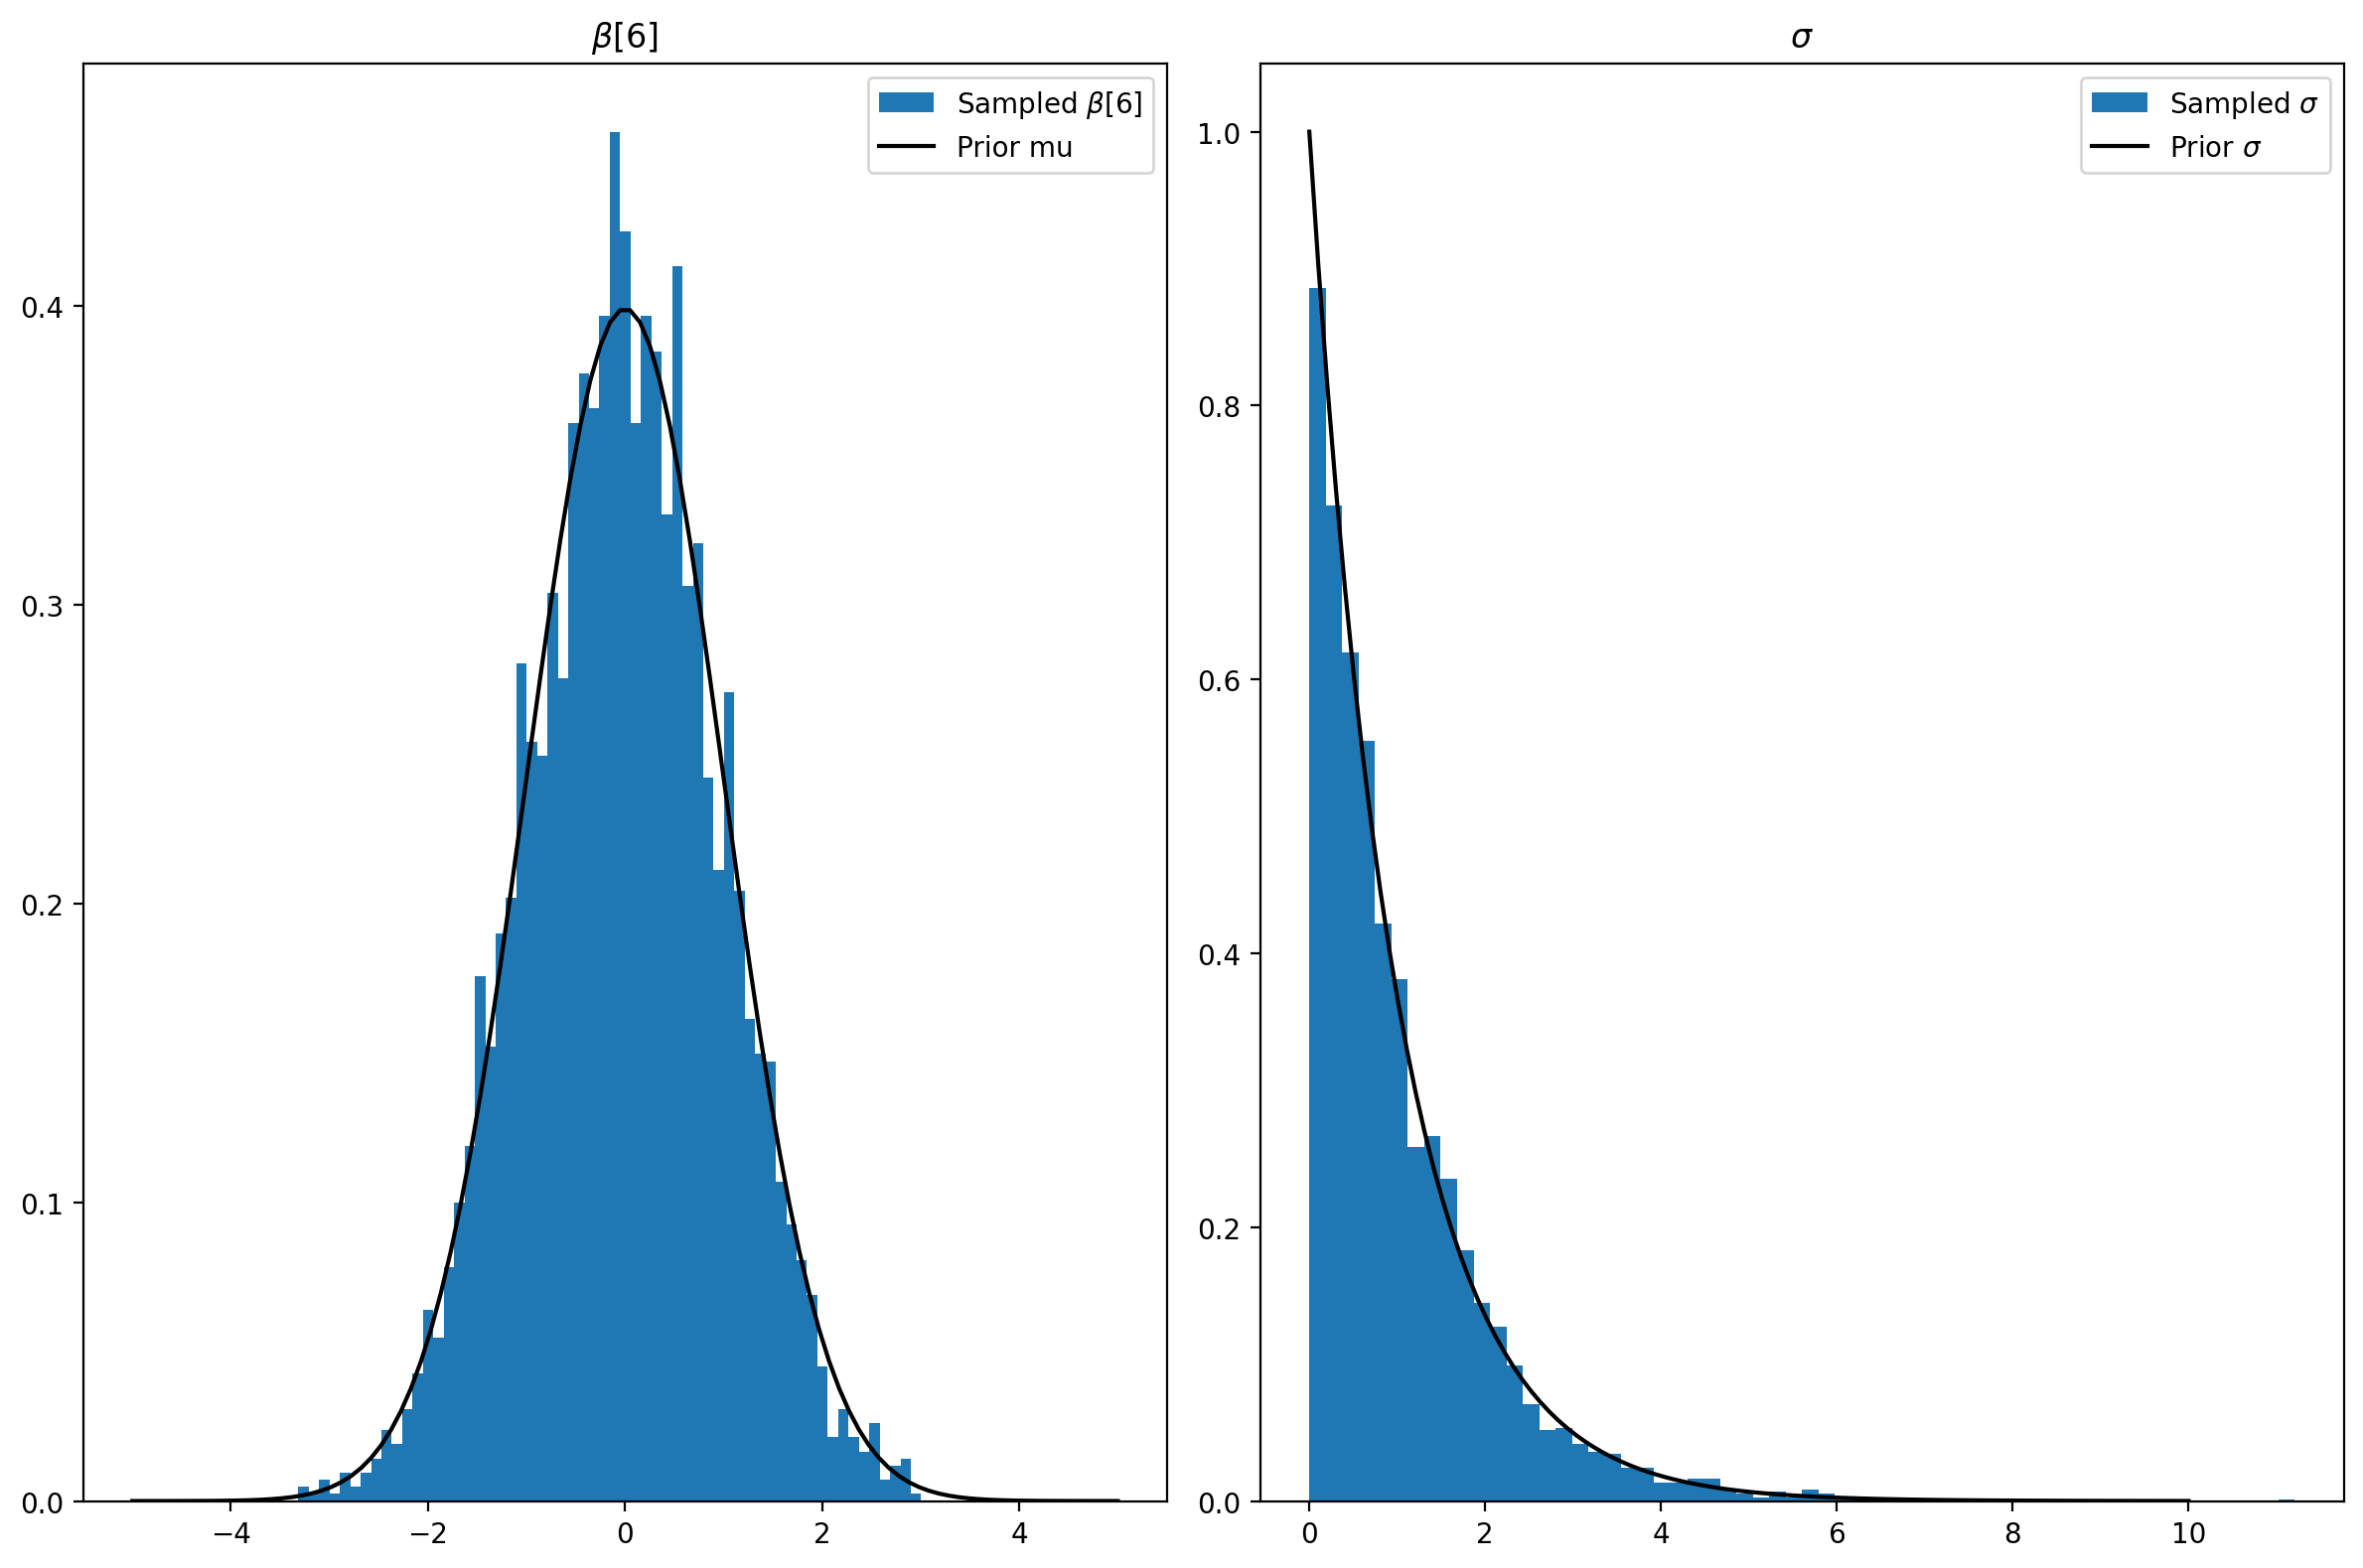

In [6]:
beta_pred= ppc_samples_2.stan_variable('betas')[:,5]
sigmas_pred = ppc_samples_2.stan_variable('sigma')[:]
fig,axes = plt.subplots(1,2,figsize = (12,8), tight_layout=True)

x = np.linspace(-5, 5, 100)
y = stats.norm.pdf(x=x,loc=0,scale=1)
axes[0].hist(beta_pred, bins=60,label=r'Sampled $\beta[6]$',density=True)
axes[0].set_title(r'$\beta[6]$')
axes[0].plot(x,y,label = 'Prior mu',color='k')
axes[0].legend()

x = np.linspace(0,10,100)
y = stats.expon.pdf(x=x,scale=1)
axes[1].hist(sigmas_pred, bins=60,label=r'Sampled $\sigma$',density=True)
axes[1].set_title(r'$\sigma$')
axes[1].plot(x,y,label=r'Prior $\sigma$',color='k')
axes[1].legend()


Text(0.0, 1.0, 'Real signal')

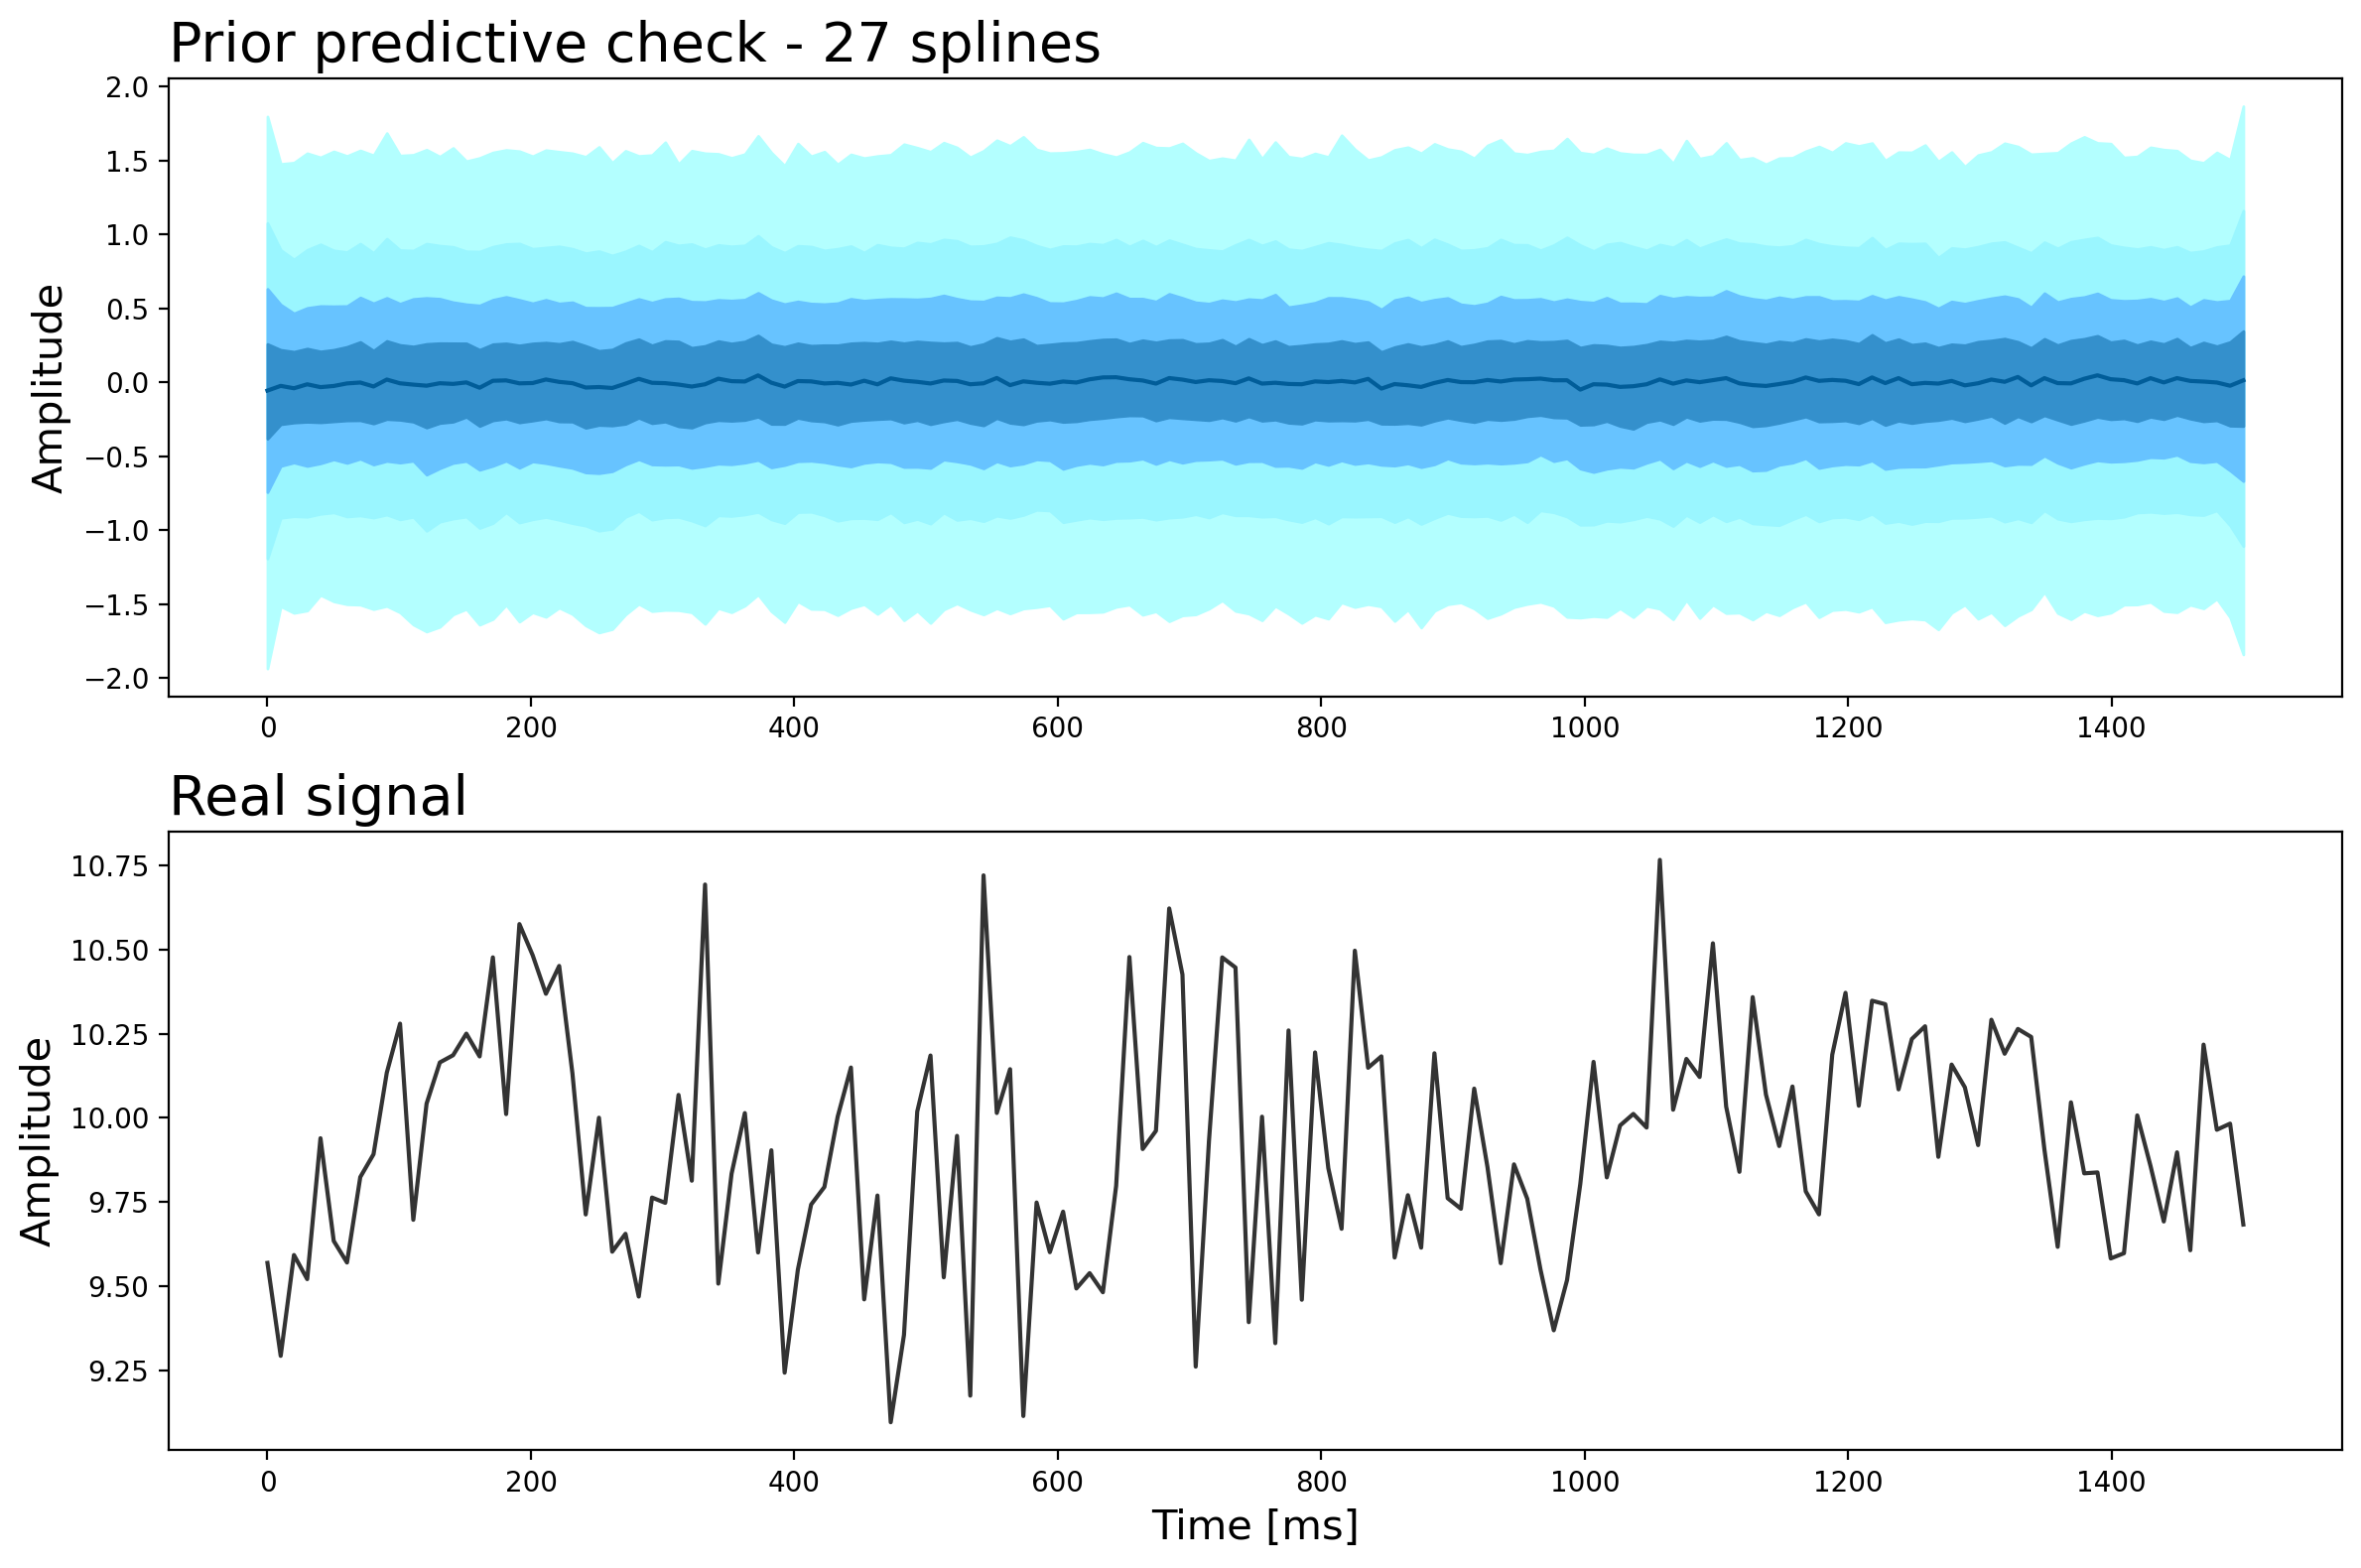

In [7]:
x = np.linspace(0,1500,N)
fig,axes = plt.subplots(2,1,figsize = (12,8), tight_layout=True)
pred = ppc_samples_2.stan_variable('y_pred')
axes[0] = ribbon_plot(x,pred,axes[0],supress_warning=True,probs = [10, 20, 30, 40, 50, 60, 70, 80, 90])
axes[1].set_xlabel('Time [ms]',fontsize = 15)
axes[0].set_ylabel('Amplitude',fontsize = 15)
axes[1].set_ylabel('Amplitude',fontsize = 15)
axes[0].set_title('Prior predictive check - 27 splines', loc= 'left',fontsize = 20)
axes[1].plot(x,acc_healthy_data[6], color = 'k',alpha=0.8)
axes[1].set_title('Real signal', loc= 'left',fontsize = 20)


We aquired very simmilar results from both models, which was expceted since their main difference can be seen on local level of function.

---
### Posterior analysis (model 1) [0-4 pts]:
- have parameter marginal disrtibutions been analyzed (histograms of individual parametes plus summaries, are they diffuse or concentrated, what can we say about values) [1 pt]
- were there any issues with the sampling? if there were what kind of ideas for mitigation were used [1 pt] 
- are the data consistent with posterior predictive samples and is it sufficiently commented (if they are not then is the justification provided)
- are the samples from posterior predictive distribution analyzed [1 pt] 


##### *Loading ang organizing data*
<style>
.justify {
    text-align: justify;
}
</style>

In [8]:
acc_healthy = pd.read_csv('data_preprocesed/acc_healthy_samples.csv')
acc_damaged = pd.read_csv('data_preprocesed/acc_damaged_samples.csv')
acc_very_damaged = pd.read_csv('data_preprocesed/acc_very_damaged_samples.csv')

acc_healthy_data = np.array([acc_healthy[col].values for col in acc_healthy.columns if col.startswith('Sample')])
acc_damaged_data = np.array([acc_damaged[col].values for col in acc_damaged.columns if col.startswith('Sample')])
acc_v_damaged_data = np.array([acc_very_damaged[col].values for col in acc_very_damaged.columns if col.startswith('Sample')])
acc = [acc_healthy_data,acc_damaged_data,acc_v_damaged_data]


As posterior predicitve check we provide data generative model that takes 6 of our samples from signle class as input and based on them it generates signals, again we focus only on single class since both data generating processes are exacly the same. There were no issues during sampling.

In [9]:
model_posterior = CmdStanModel(stan_file="stan/posterior_check.stan")
I = 6
num_knots = 13
N = 150
times = np.linspace(0,N*10,N)
knot_list = np.quantile(times,np.linspace(0,1,num_knots))
B0 = create_spline_matrix(N, times, 3, num_knots)
sampling_order = np.random.permutation([*range(len(acc[0]))])
y = acc[0][sampling_order][:I]

data_ppc = {
    "I": I,
    "N": N,
    "K": num_knots+2,
    "X": B0,
    "y": y.T
}

samples_posterior = model_posterior.sample(data=data_ppc)
print(samples_posterior.diagnose())


19:30:20 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status





chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)
chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)




chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |█████▉    | 00:01 Iteration: 1001 / 2000 [ 50%]  (Sampling)



chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)

chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |███████▎  | 00:02 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |███████▋  | 00:02 Iteration: 1400 / 2000 [ 70%]  (Sampling)


chain 1 |████████▏ | 00:03 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |████████▋ | 00:03 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |█████████ | 00:04 I


19:30:24 - cmdstanpy - INFO - CmdStan done processing.
19:30:25 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/posterior_check.stan', line 22, column 4 to column 30)
Consider re-running with show_console=True if the above output is unclear!



Processing csv files: /var/folders/69/dws6xwp11mgdnm5sb8sr1kph0000gn/T/tmpvyzelz9v/posterior_checkke63xqvo/posterior_check-20240526193020_1.csv, /var/folders/69/dws6xwp11mgdnm5sb8sr1kph0000gn/T/tmpvyzelz9v/posterior_checkke63xqvo/posterior_check-20240526193020_2.csv, /var/folders/69/dws6xwp11mgdnm5sb8sr1kph0000gn/T/tmpvyzelz9v/posterior_checkke63xqvo/posterior_check-20240526193020_3.csv, /var/folders/69/dws6xwp11mgdnm5sb8sr1kph0000gn/T/tmpvyzelz9v/posterior_checkke63xqvo/posterior_check-20240526193020_4.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.



We present generated samples on ribbon plot with real singal in black. As we can see with 15 basis function we capture mean of signal quite well and roughly estimate local phenomenas.

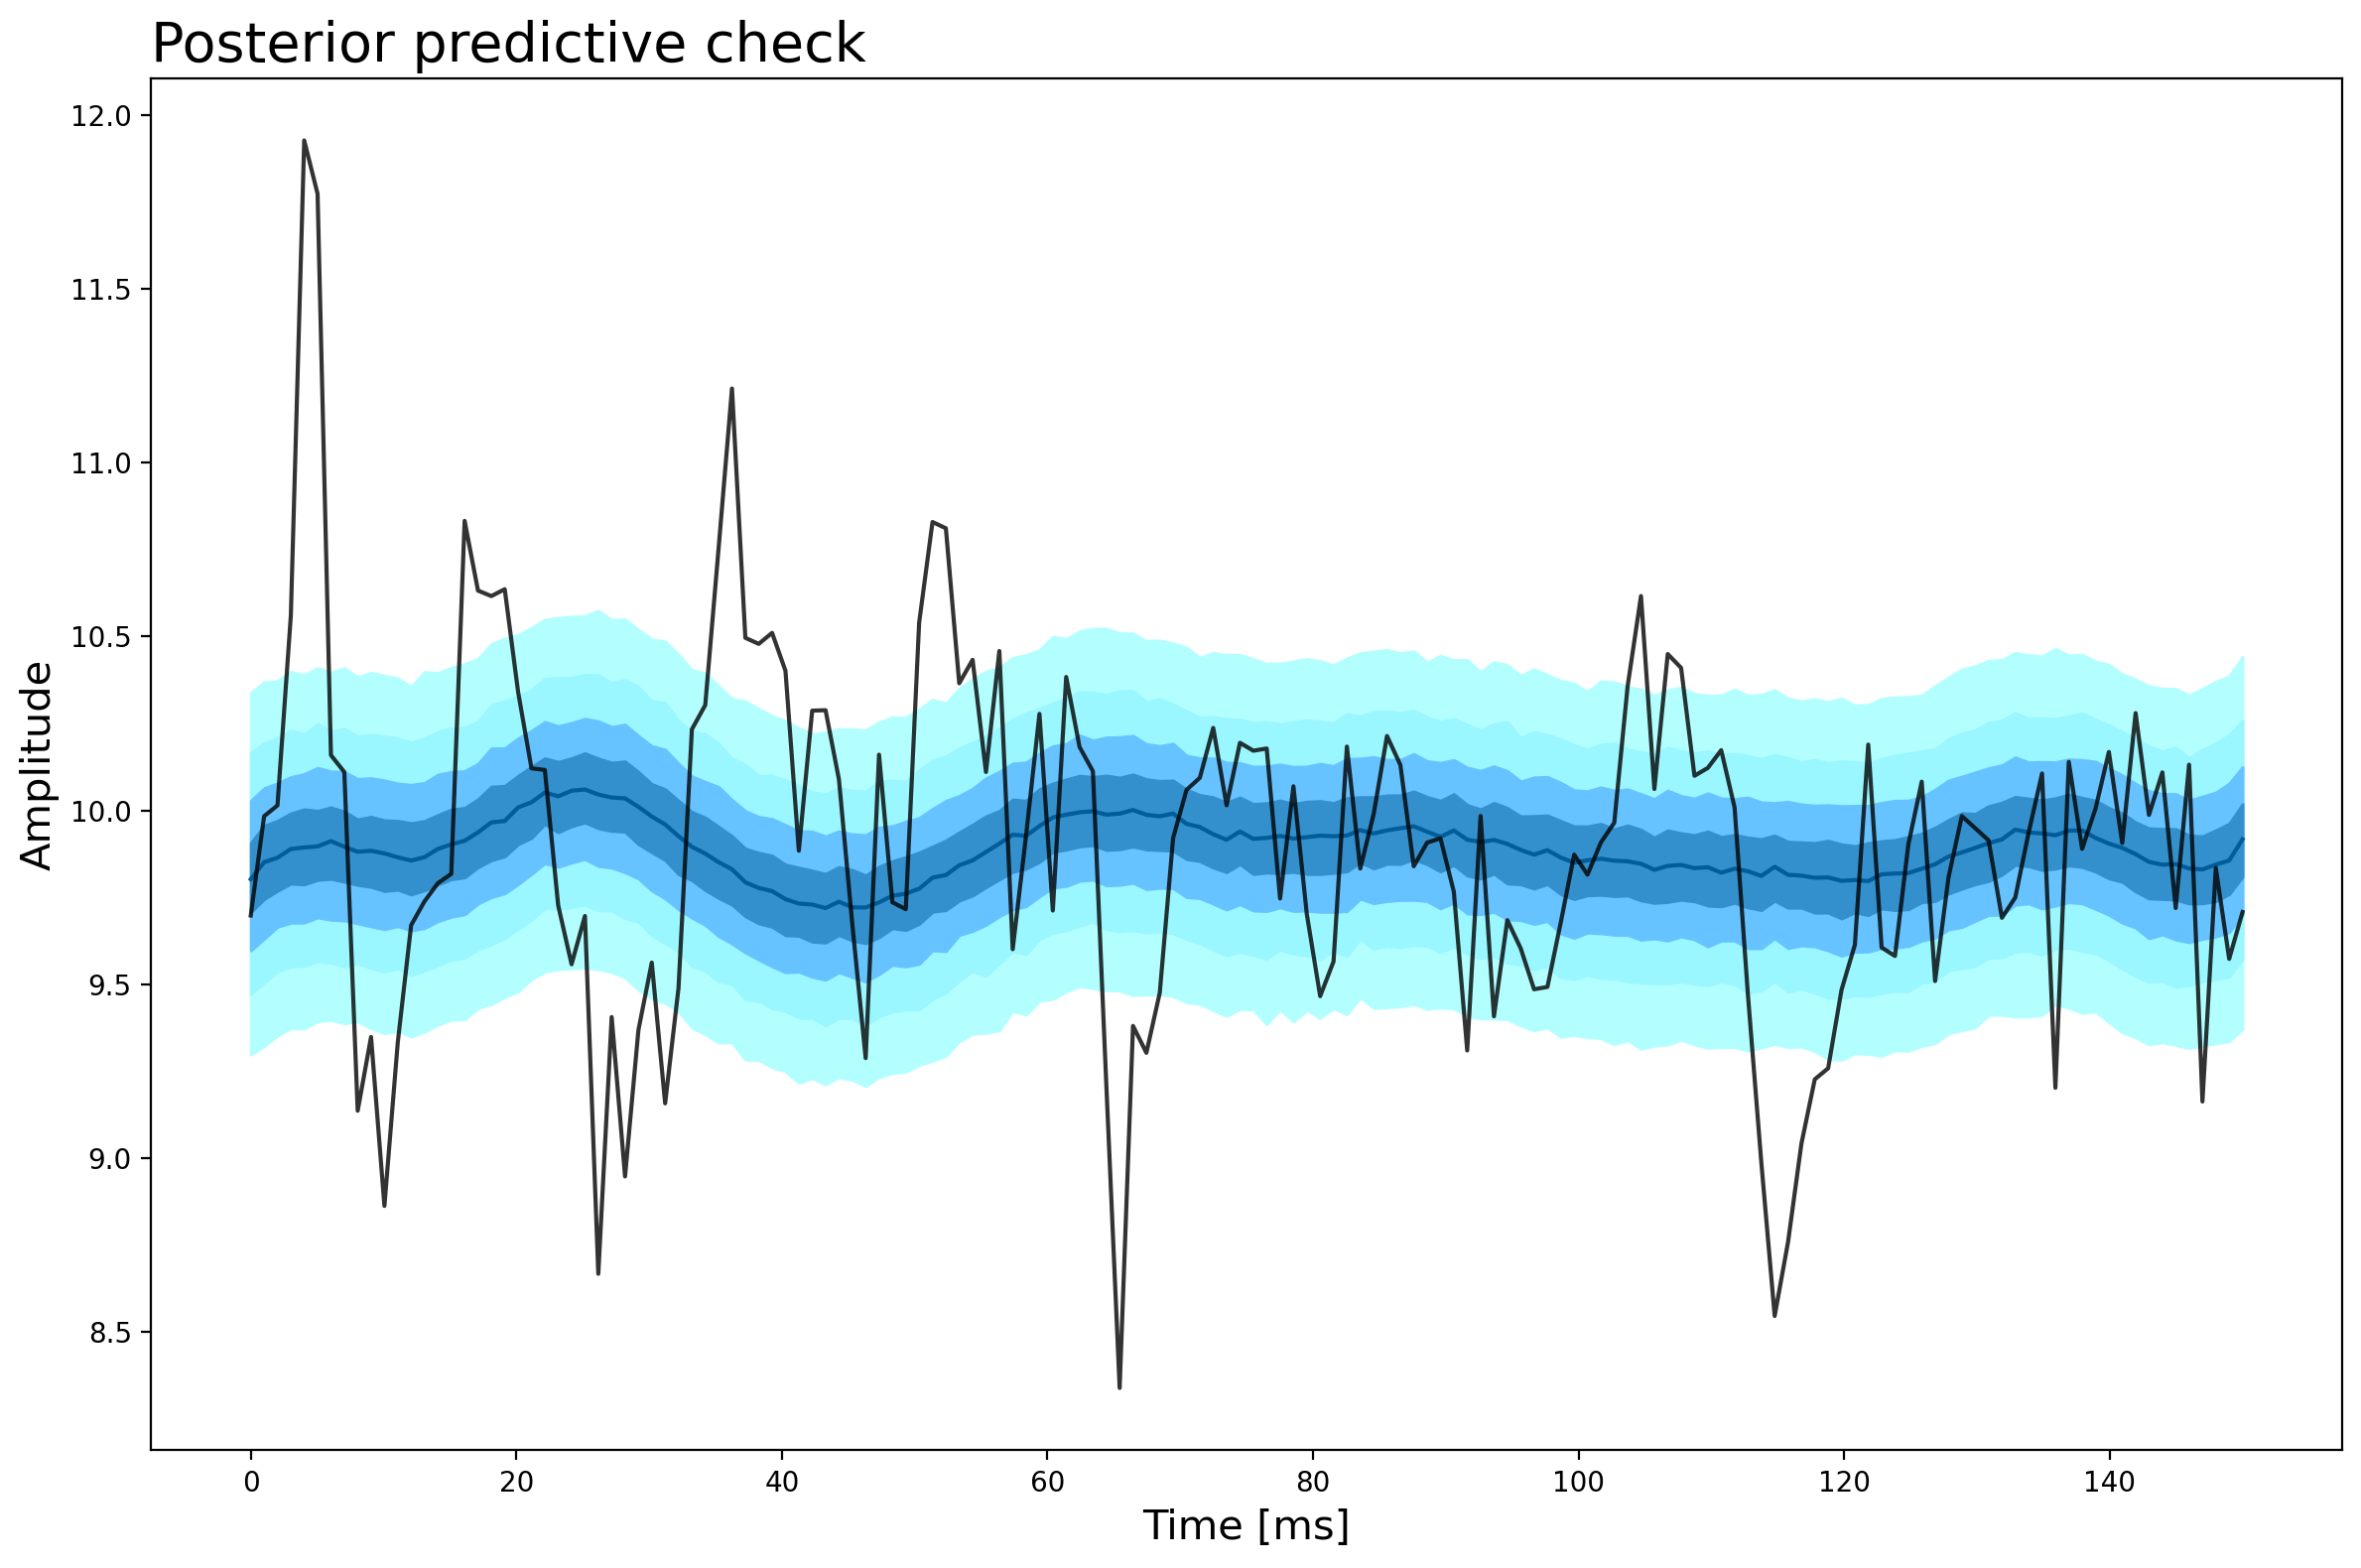

In [10]:
x = np.linspace(0,150,N)
fig = plt.figure(figsize=(12, 8), tight_layout = True)
axes = plt.subplot(1, 1 ,1)
y_pred= samples_posterior.stan_variable('y_hat')[:,:]
axes = ribbon_plot(x,y_pred,axes,supress_warning=True,probs = [10, 20, 30, 40, 50, 60, 70, 80, 90])
axes.set_xlabel('Time [ms]',fontsize = 15)
axes.set_ylabel('Amplitude',fontsize = 15)
axes.set_title('Posterior predictive check', loc= 'left',fontsize = 20)
axes.plot(x,acc_healthy_data[0], color = 'k',alpha=0.8)

On histogram we present how our parameters contracted after fitting, again showing all 15 $\beta$ would be confusing so we limit ourselfs to only one. 


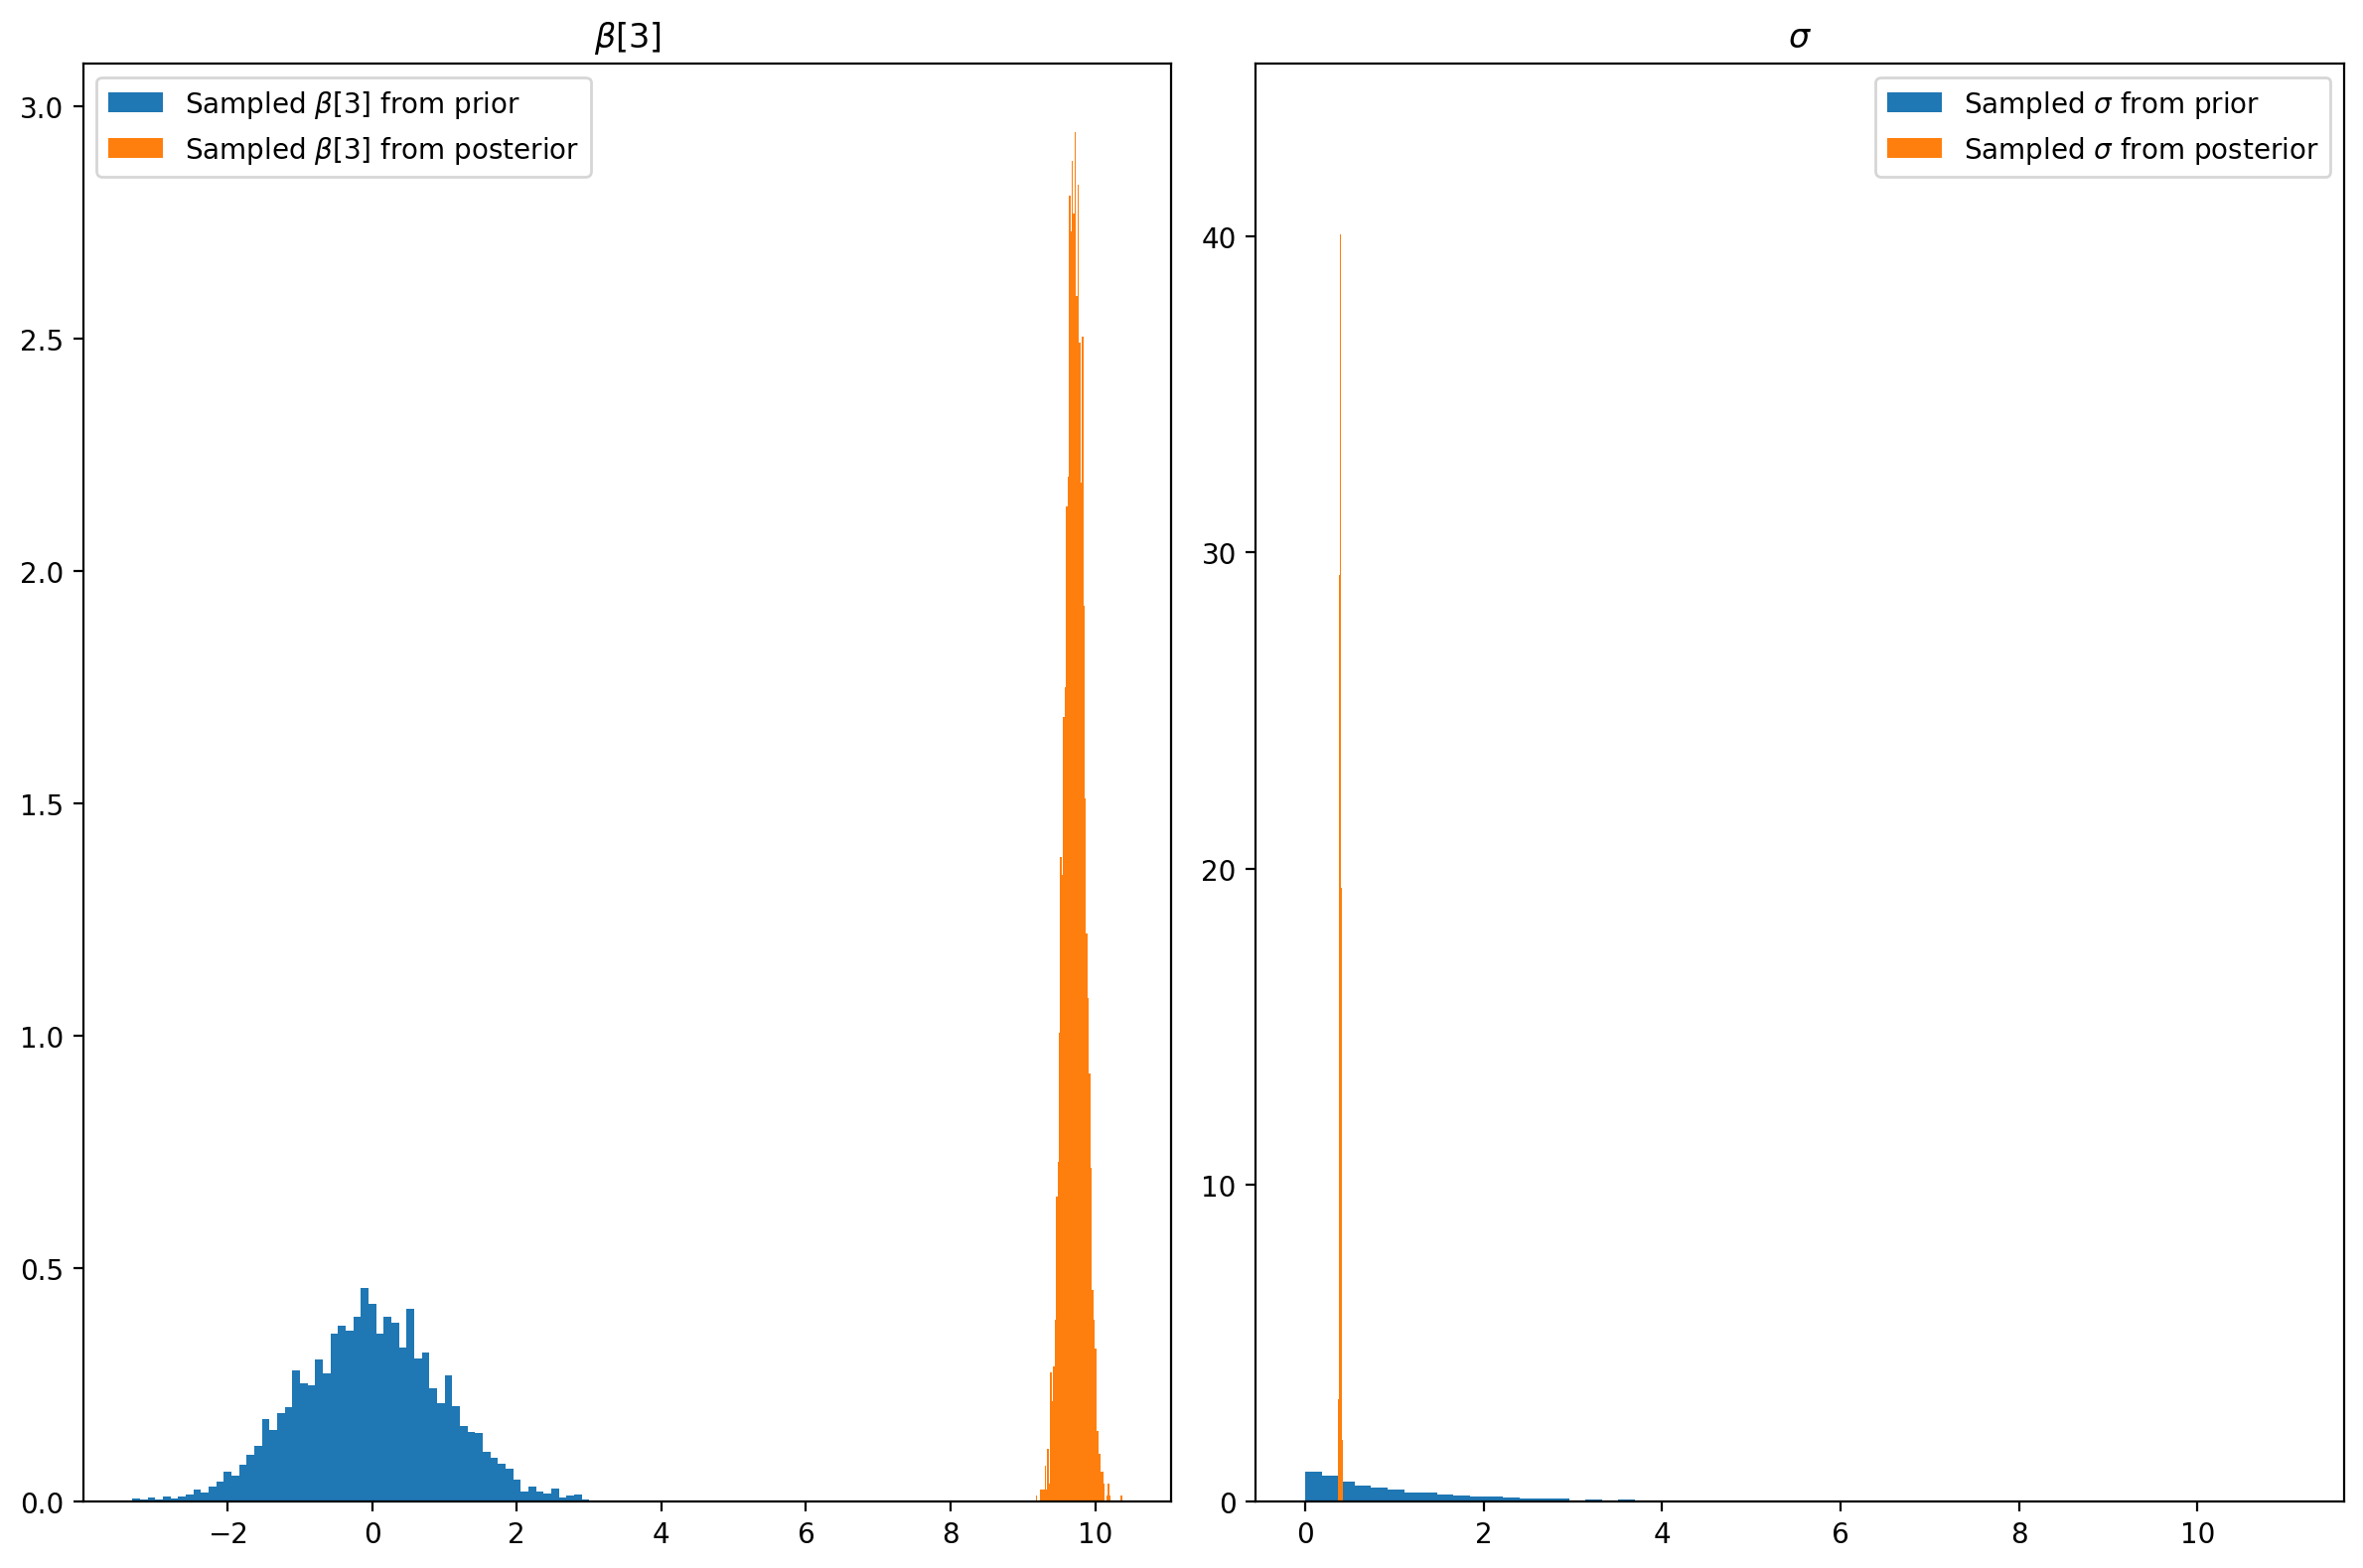

In [11]:
sigma = samples_posterior.stan_variable('sigma')
sigma_pred = samples_posterior.stan_variable('sigma_sim_hat')

betas = samples_posterior.stan_variable('betas')[:,2]
betas_pred = samples_posterior.stan_variable('betas_sim_hat')[:,2]


fig,axes = plt.subplots(1,2,figsize = (12,8), tight_layout=True)

x = np.linspace(-5, 5, 100)
y = stats.norm.pdf(x=x,loc=0,scale=1)
axes[0].hist(beta_pred, bins=60,label=r'Sampled $\beta[3]$ from prior',density=True)
axes[0].set_title(r'$\beta[3]$')
axes[0].hist(betas, bins=60,label=r'Sampled $\beta[3]$ from posterior',density=True)
axes[0].legend()

x = np.linspace(0,10,100)
y = stats.expon.pdf(x=x,scale=1)
axes[1].hist(sigma_pred, bins=60,label=r'Sampled $\sigma$ from prior',density=True)
axes[1].set_title(r'$\sigma$')
axes[1].hist(sigma, bins=60,label=r'Sampled $\sigma$ from posterior',density=True)
axes[1].legend()


We also calculate posterior contraction given as

$$ c[f \mid \tilde{y}] = 1 - \frac{\mathbb{V}_{\text{post}}[f \mid \tilde{y}]}{\mathbb{V}_{\text{prior}}[f \mid \tilde{y}]} $$

where $\mathbb{V}$ stands for variance, measures how much the data from an observation update our understanding of the function $f$. If the posterior contraction is close to zero, it means the data add little new information beyond what the prior model already provides. If it is close to one, the data are much more informative compared to the prior model. Results are showing that we were able to inform our model greatly.

In [12]:
_, contraction = get_z_contr(results=samples_posterior,num_knots=15)
betas_names = ['Sigma'] + [fr'Beta {x+1}' for x in range(len(contraction[0])-1)] 
contr = [[value] for value in contraction[0]]
df_betas = pd.DataFrame(contr,betas_names,columns=['Contraction value'])
df_betas

Contraction value
Sigma             0.999912
Beta 1            0.986261
Beta 2            0.979267
Beta 3            0.981082
Beta 4            0.987961
Beta 5            0.988926
Beta 6            0.989431
Beta 7            0.990143
Beta 8            0.989897
Beta 9            0.989622
Beta 10           0.989481
Beta 11           0.989089
Beta 12           0.986912
Beta 13           0.978953
Beta 14           0.978098
Beta 15           0.985544

Additionally we provide example results of our classifier. The plot displays probabilistic classifications for a set of samples
categorized into two classes: healthy and damaged. Each plot shows the probability distribution of each sample belonging to its respective class across test run. Blue dot represents the mean values, when blue bar presents 95% confidence interval. As we can see model predicted healthy signals quite well except one sample where confidence interval is quite broad. In damaged class we can see a bit more uncertanity and one wrong classifitaion. We can use information about broad confidence interval as a warining that our drone might be worth inspecting but it's not necessary to stop mission.

19:30:32 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:01 Iteration:  100 / 2000 [  5%]  (Warmup)
chain 1 |█▊        | 00:01 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)




chain 1 |██▋       | 00:02 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:02 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:02 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:03 Iteration:  700 / 2000 [ 35%]  (Warmup)




chain 1 |████▌     | 00:03 Iteration:  800 / 2000 [ 40%]  (Warmup)
chain 1 |█████     | 00:03 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:04 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:04 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:04 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chai


19:30:39 - cmdstanpy - INFO - CmdStan done processing.



Accuracy of single run 0.9074074074074074%


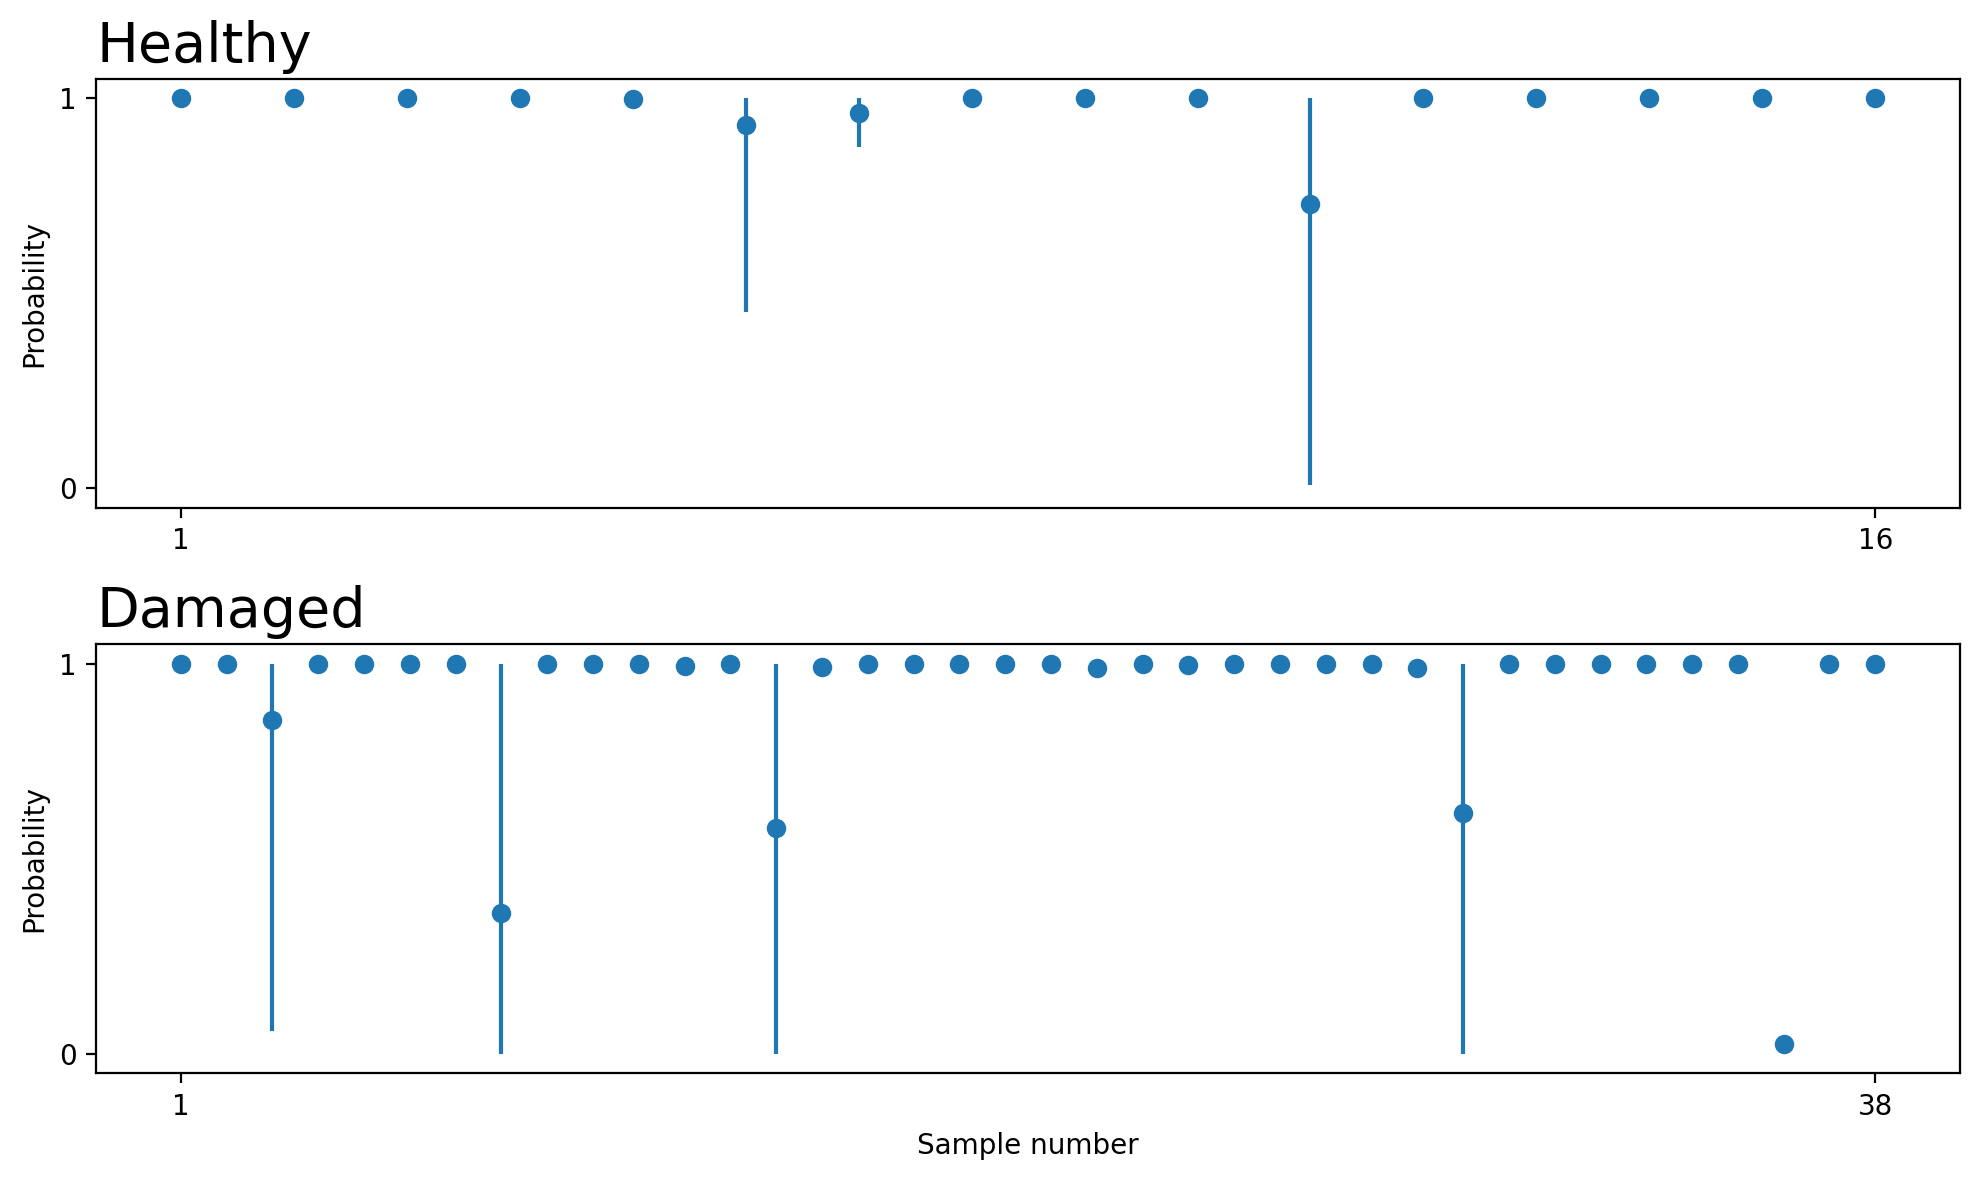

In [13]:
num_knots = 13
seed = 26042024
data, labels, IT, IL, total,B0,knot_list = prepare_data(acc,frequencies=None,training_samples=6, 
                                                        num_knots=num_knots, mode = 'binary', seed = seed)
model = CmdStanModel(stan_file='stan/mix.stan')
hit_rate = get_results(model=model,data=data,seed=seed,labels=labels,IT=IT,IL=IL,total=total,plot=True,mode='binary')
print(f'Accuracy of single run {hit_rate}%')

During tests we noted a group of "problematic" samples in both data groups which classification results strongly correlates with samples chosen for training. To not let this influence classifier score we decided to perform 100 independent experiments each with randomly chosen training data, and our final score is statistic of said experiments. As we can see we managed to get 90,2 $\pm$ 4,7% accuracy on data from accelerometr.

In [14]:
## Estimated time ~ 5 minutes

# num_knots = 13
# res = []
# for i in range(100):
#     data, labels, IT, IL, total ,B0, knot_list = prepare_data(acc, frequencies=None, training_samples=5, num_knots=num_knots, mode = 'binary')
#     res.append(get_results(model=model, data=data, labels=labels, IT=IT,IL=IL, total=total, mode='binary',plot=False))
# np.savetxt('results/acc_15.csv', res, delimiter=',', fmt='%f')

In [15]:
results = np.genfromtxt('results/acc_15.csv', delimiter=',')
mean = np.mean(results)
st_dev = np.std(results)
print(f'Mean accuracy: {np.round(mean,3)*100}% \nStandard deviation: {np.round(st_dev,3)*100}%')

Mean accuracy: 90.2% 
Standard deviation: 4.7%


---
### Posterior analysis (model 2) [0-4 pts]:
- have parameter marginal disrtibutions been analyzed (histograms of individual parametes plus summaries, are they diffuse or concentrated, what can we say about values) [1 pt]
- were there any issues with the sampling? if there were what kind of ideas for mitigation were used [1 pt]
- are the samples from posterior predictive distribution analyzed [1 pt]
- are the data consistent with posterior predictive samples and is it sufficiently commented (if they are not then is the justification provided)

We perform exactly the same steps as for model 1

In [16]:
model_posterior_2 = CmdStanModel(stan_file="stan/posterior_check.stan")
I = 6
num_knots = 25
N = 150
times = np.linspace(0,N*10,N)
knot_list = np.quantile(times,np.linspace(0,1,num_knots))
B0 = create_spline_matrix(N, times, 3, num_knots)
sampling_order = np.random.permutation([*range(len(acc[0]))])
y = acc[0][sampling_order][:I]

data_ppc = {
    "I": I,
    "N": N,
    "K": num_knots+2,
    "X": B0,
    "y": y.T
}

samples_posterior_2 = model_posterior_2.sample(data=data_ppc)
print(samples_posterior_2.diagnose())



19:30:40 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)




chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |█████     | 00:00 Iteration:  900 / 2000 [ 45%]  (Warmup)

chain 1 |█████▉    | 00:00 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▊   | 00:01 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |███████▋  | 00:01 Iteration: 1400 / 2000 [ 70%]  (Sampling)




chain 1 |████████▋ | 00:01 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |█████████ | 00:01 Iteration: 1700 / 2000 [ 85%]  (Sampling)


chain 1 |█████████▌| 00:02 Iteration: 1800 / 2000 [ 90%]  (Sampling)


chain 1 |██████████| 00:02 Iteration: 1900 / 2000 [ 95%]  (Sampling)


chain 1 |██████████| 00:02 Sampling completed                       
chain 2 |██████████| 00:02 Sampling completed                  


19:30:42 - cmdstanpy - INFO - CmdStan done processing.



Processing csv files: /var/folders/69/dws6xwp11mgdnm5sb8sr1kph0000gn/T/tmpvyzelz9v/posterior_checklpkqsdx5/posterior_check-20240526193040_1.csv, /var/folders/69/dws6xwp11mgdnm5sb8sr1kph0000gn/T/tmpvyzelz9v/posterior_checklpkqsdx5/posterior_check-20240526193040_2.csv, /var/folders/69/dws6xwp11mgdnm5sb8sr1kph0000gn/T/tmpvyzelz9v/posterior_checklpkqsdx5/posterior_check-20240526193040_3.csv, /var/folders/69/dws6xwp11mgdnm5sb8sr1kph0000gn/T/tmpvyzelz9v/posterior_checklpkqsdx5/posterior_check-20240526193040_4.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.



It is shown that increasing number of basis function allows model to capture local phenomenas with greater precision

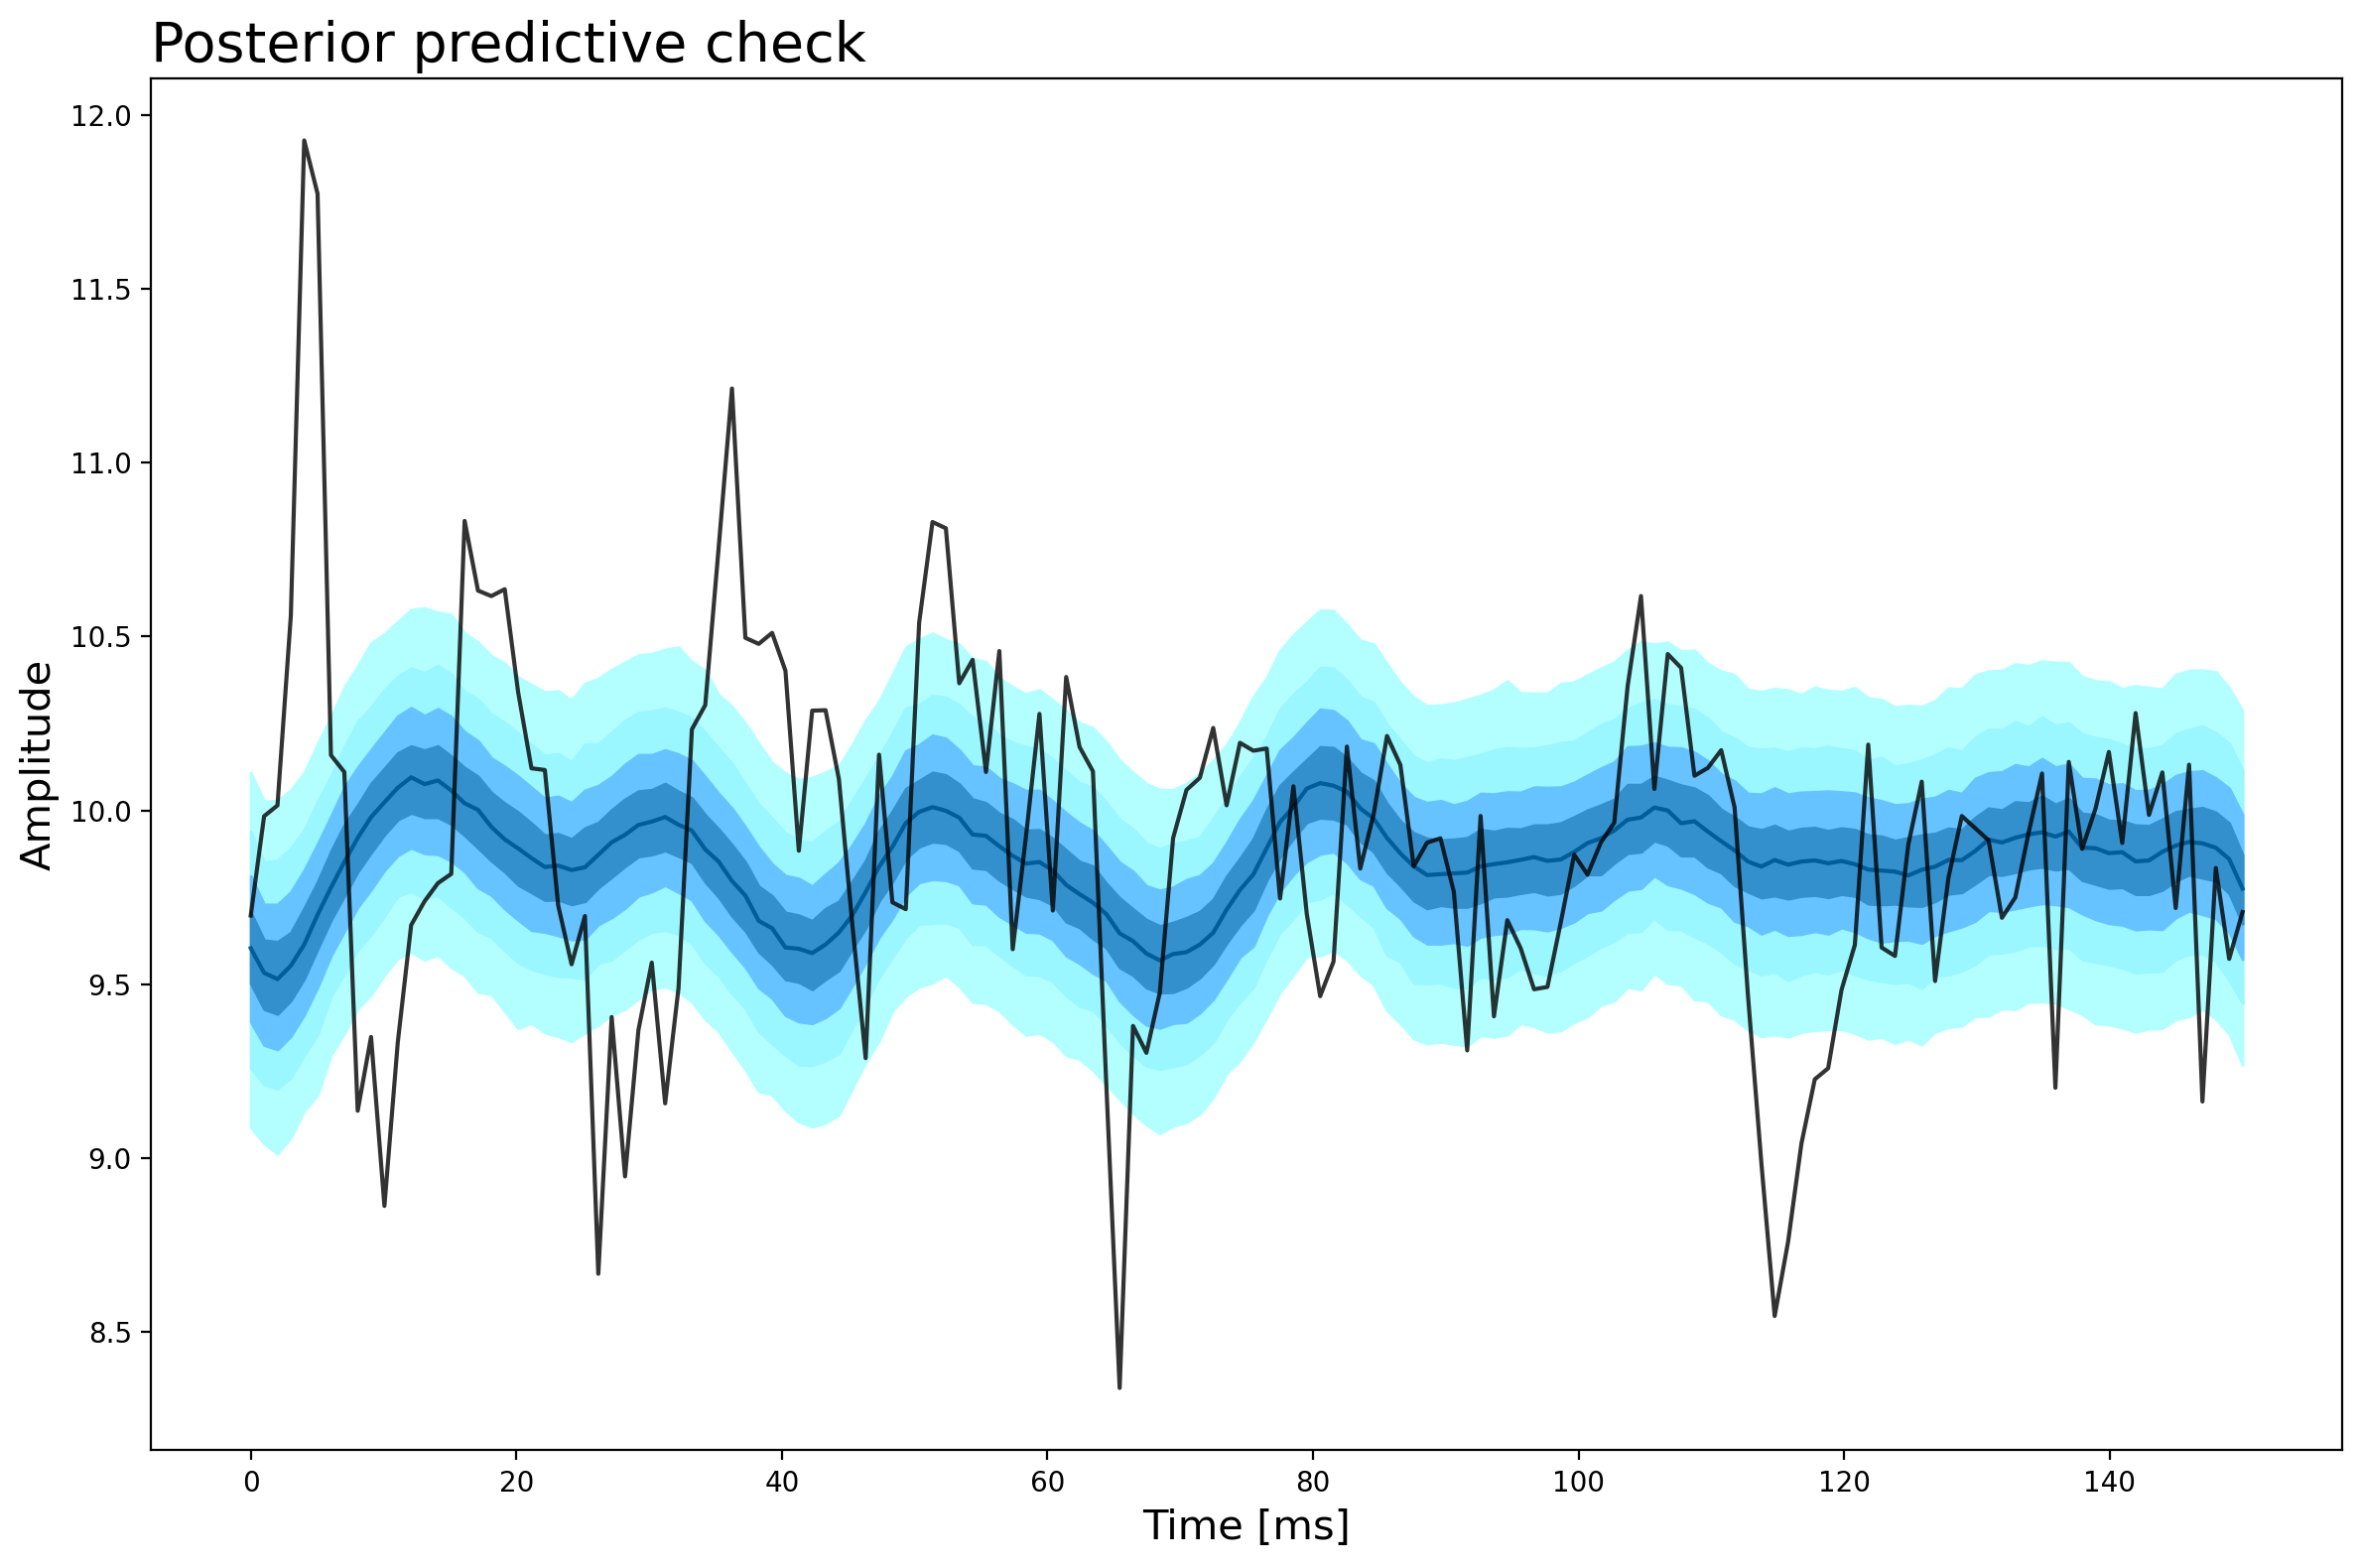

In [17]:
x = np.linspace(0,150,N)
fig = plt.figure(figsize=(12, 8), tight_layout = True)
axes = plt.subplot(1, 1 ,1)
y_pred= samples_posterior_2.stan_variable('y_hat')[:,:]
axes = ribbon_plot(x,y_pred,axes,supress_warning=True,probs = [10, 20, 30, 40, 50, 60, 70, 80, 90])
axes.set_xlabel('Time [ms]',fontsize = 15)
axes.set_ylabel('Amplitude',fontsize = 15)
axes.set_title('Posterior predictive check', loc= 'left',fontsize = 20)
axes.plot(x,acc_healthy_data[0], color = 'k',alpha=0.8)

Simmilarly we aquired satysfying results of contraction for our parameters

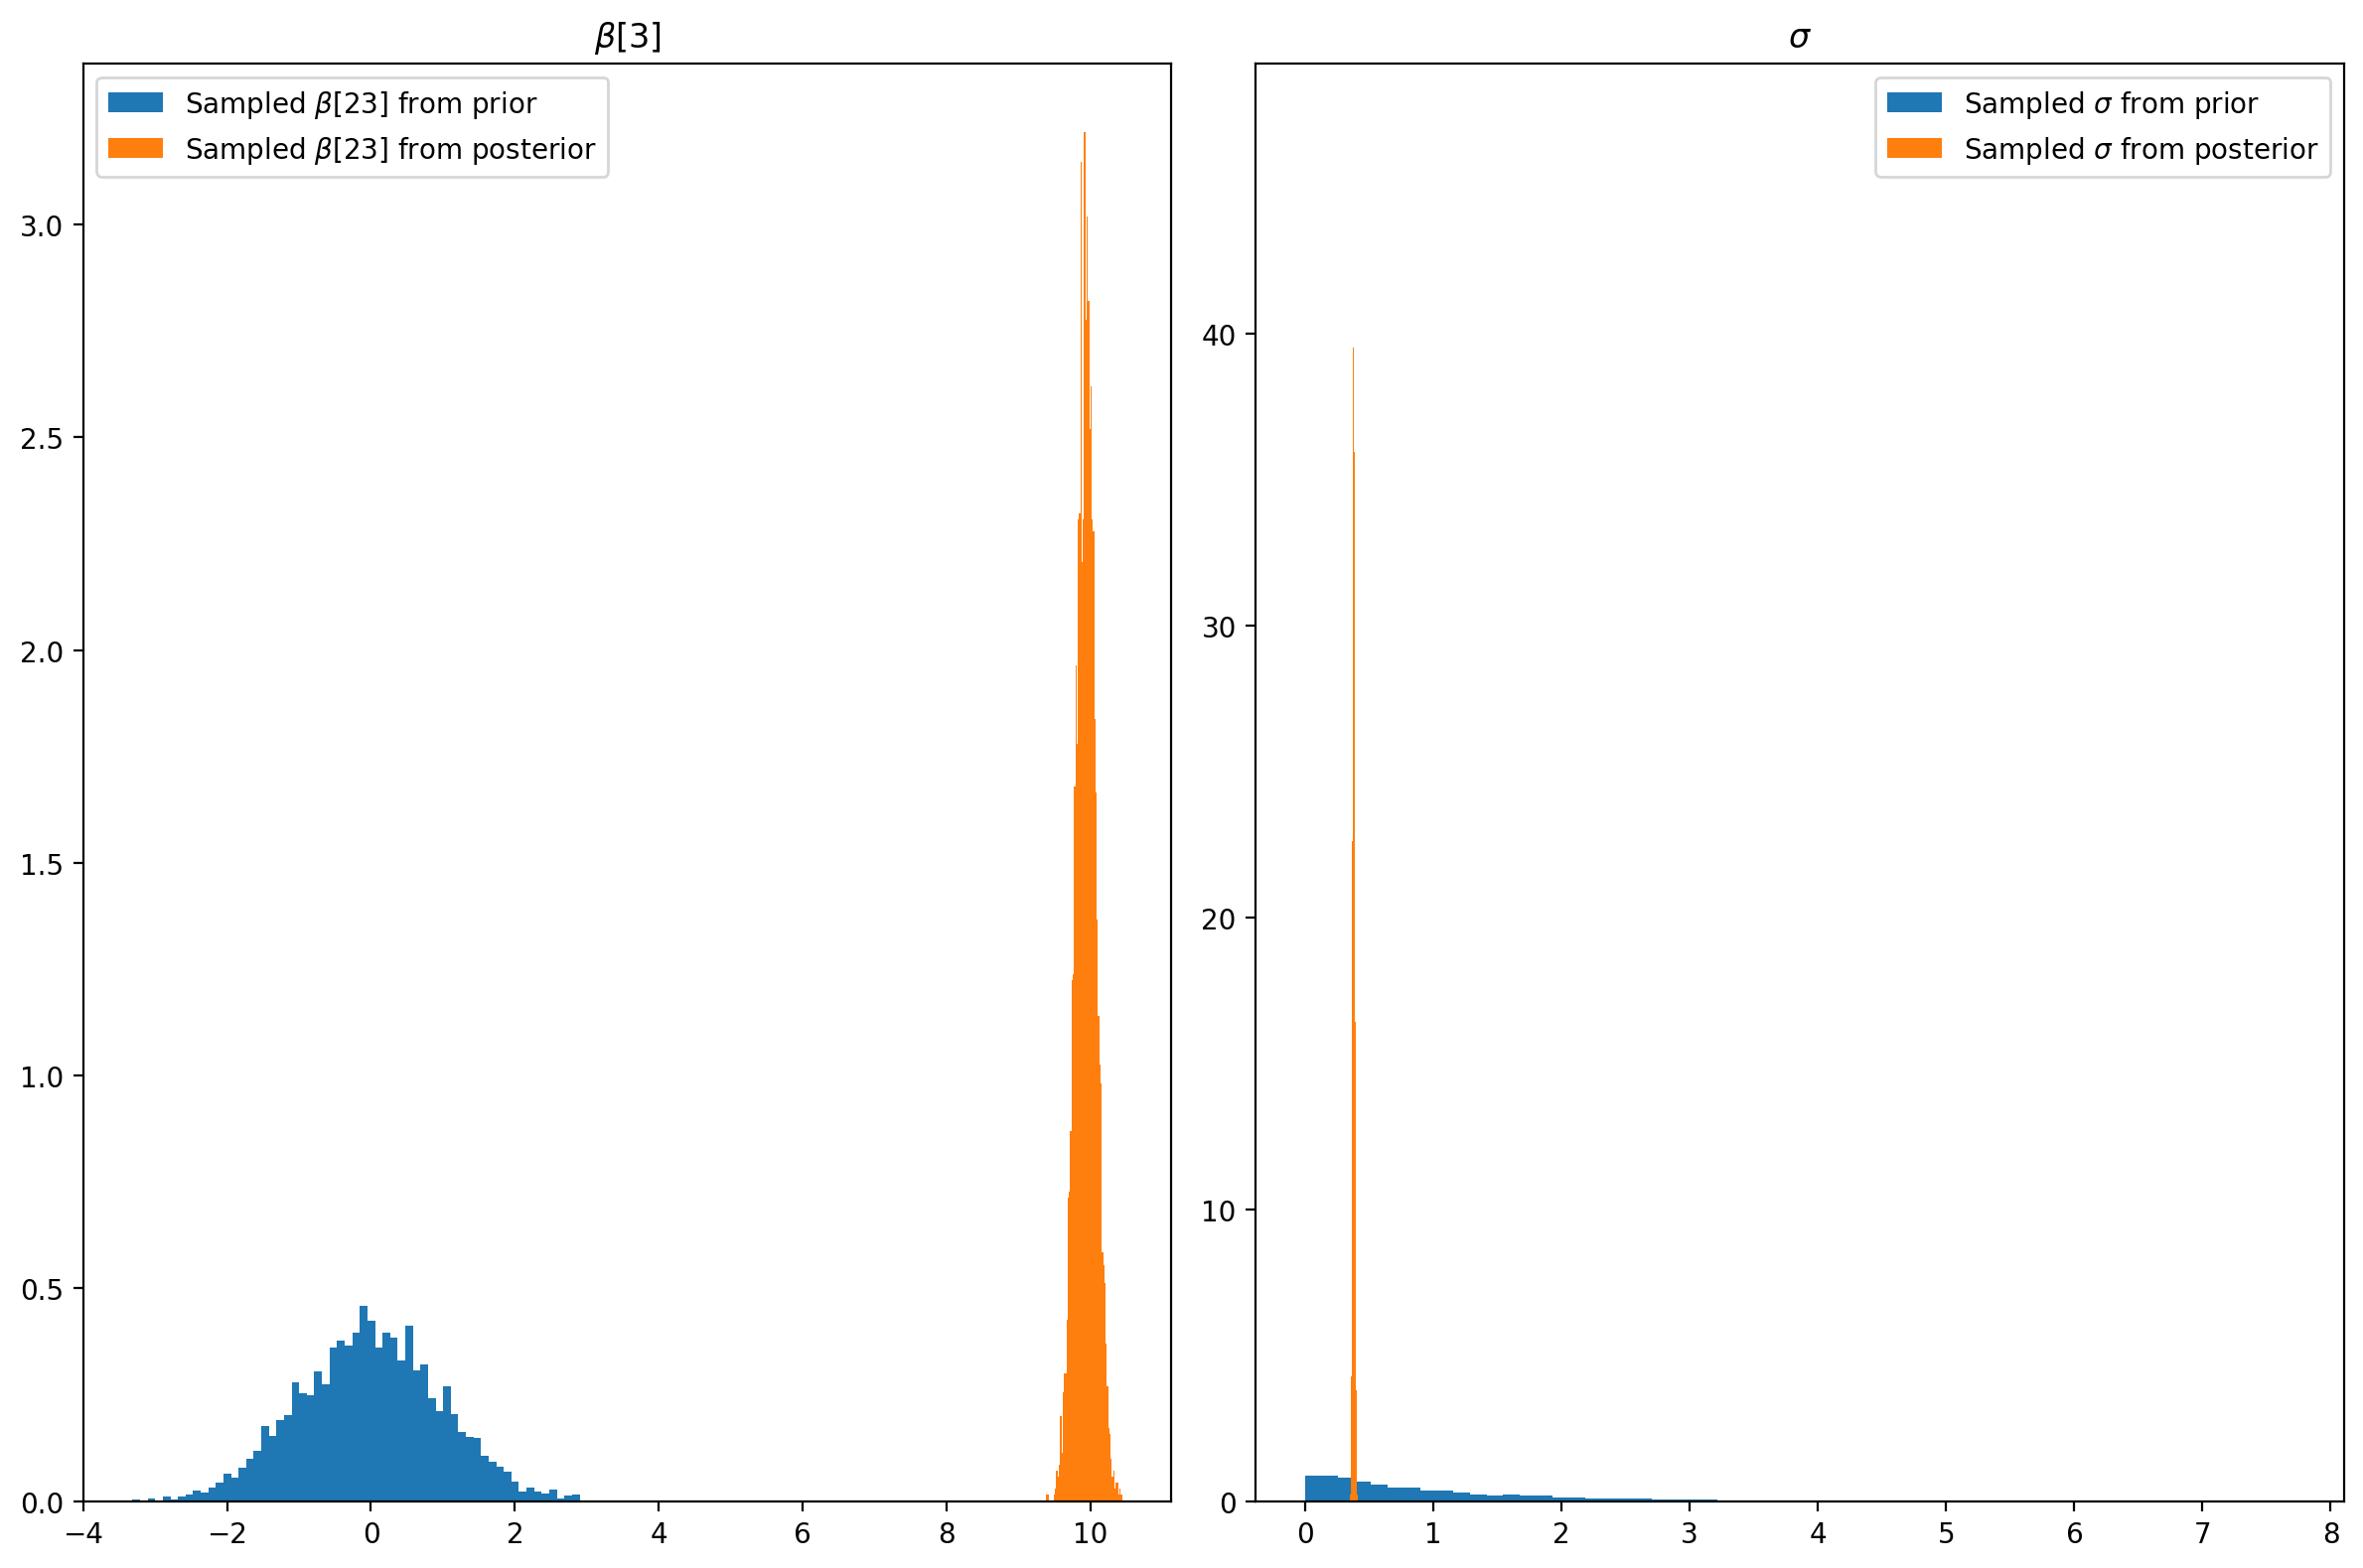

In [18]:
sigma = samples_posterior_2.stan_variable('sigma')
sigma_pred = samples_posterior_2.stan_variable('sigma_sim_hat')

betas = samples_posterior_2.stan_variable('betas')[:,22]
betas_pred = samples_posterior_2.stan_variable('betas_sim_hat')[:,22]


fig,axes = plt.subplots(1,2,figsize = (12,8), tight_layout=True)

x = np.linspace(-5, 5, 100)
y = stats.norm.pdf(x=x,loc=0,scale=1)
axes[0].hist(beta_pred, bins=60,label=r'Sampled $\beta[23]$ from prior',density=True)
axes[0].set_title(r'$\beta[3]$')
axes[0].hist(betas, bins=60,label=r'Sampled $\beta[23]$ from posterior',density=True)
axes[0].legend()

x = np.linspace(0,10,100)
y = stats.expon.pdf(x=x,scale=1)
axes[1].hist(sigma_pred, bins=60,label=r'Sampled $\sigma$ from prior',density=True)
axes[1].set_title(r'$\sigma$')
axes[1].hist(sigma, bins=60,label=r'Sampled $\sigma$ from posterior',density=True)
axes[1].legend()


In [19]:
_, contraction = get_z_contr(results=samples_posterior_2,num_knots=27)
betas_names = ['Sigma'] + [fr'Beta {x+1}' for x in range(len(contraction[0])-1)] 
contr = [[value] for value in contraction[0]]
df_betas = pd.DataFrame(contr,betas_names,columns=['Contraction value'])
df_betas

Contraction value
Sigma             0.999915
Beta 1            0.980656
Beta 2            0.964837
Beta 3            0.965255
Beta 4            0.978191
Beta 5            0.980411
Beta 6            0.981338
Beta 7            0.981922
Beta 8            0.981897
Beta 9            0.981552
Beta 10           0.981920
Beta 11           0.982130
Beta 12           0.981757
Beta 13           0.981590
Beta 14           0.981370
Beta 15           0.981532
Beta 16           0.981966
Beta 17           0.982433
Beta 18           0.981908
Beta 19           0.981469
Beta 20           0.982476
Beta 21           0.981731
Beta 22           0.981040
Beta 23           0.980713
Beta 24           0.978410
Beta 25           0.966489
Beta 26           0.964770
Beta 27           0.980655

Example of classification

19:30:49 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status



chain 1 |▉         | 00:01 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:01 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:02 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:02 Iteration:  300 / 2000 [ 15%]  (Warmup)

chain 1 |██▋       | 00:02 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:03 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:03 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:04 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:04 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:05 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:05 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:06 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:06 Iteration: 120


19:30:59 - cmdstanpy - INFO - CmdStan done processing.



Accuracy of single run 0.8703703703703703%


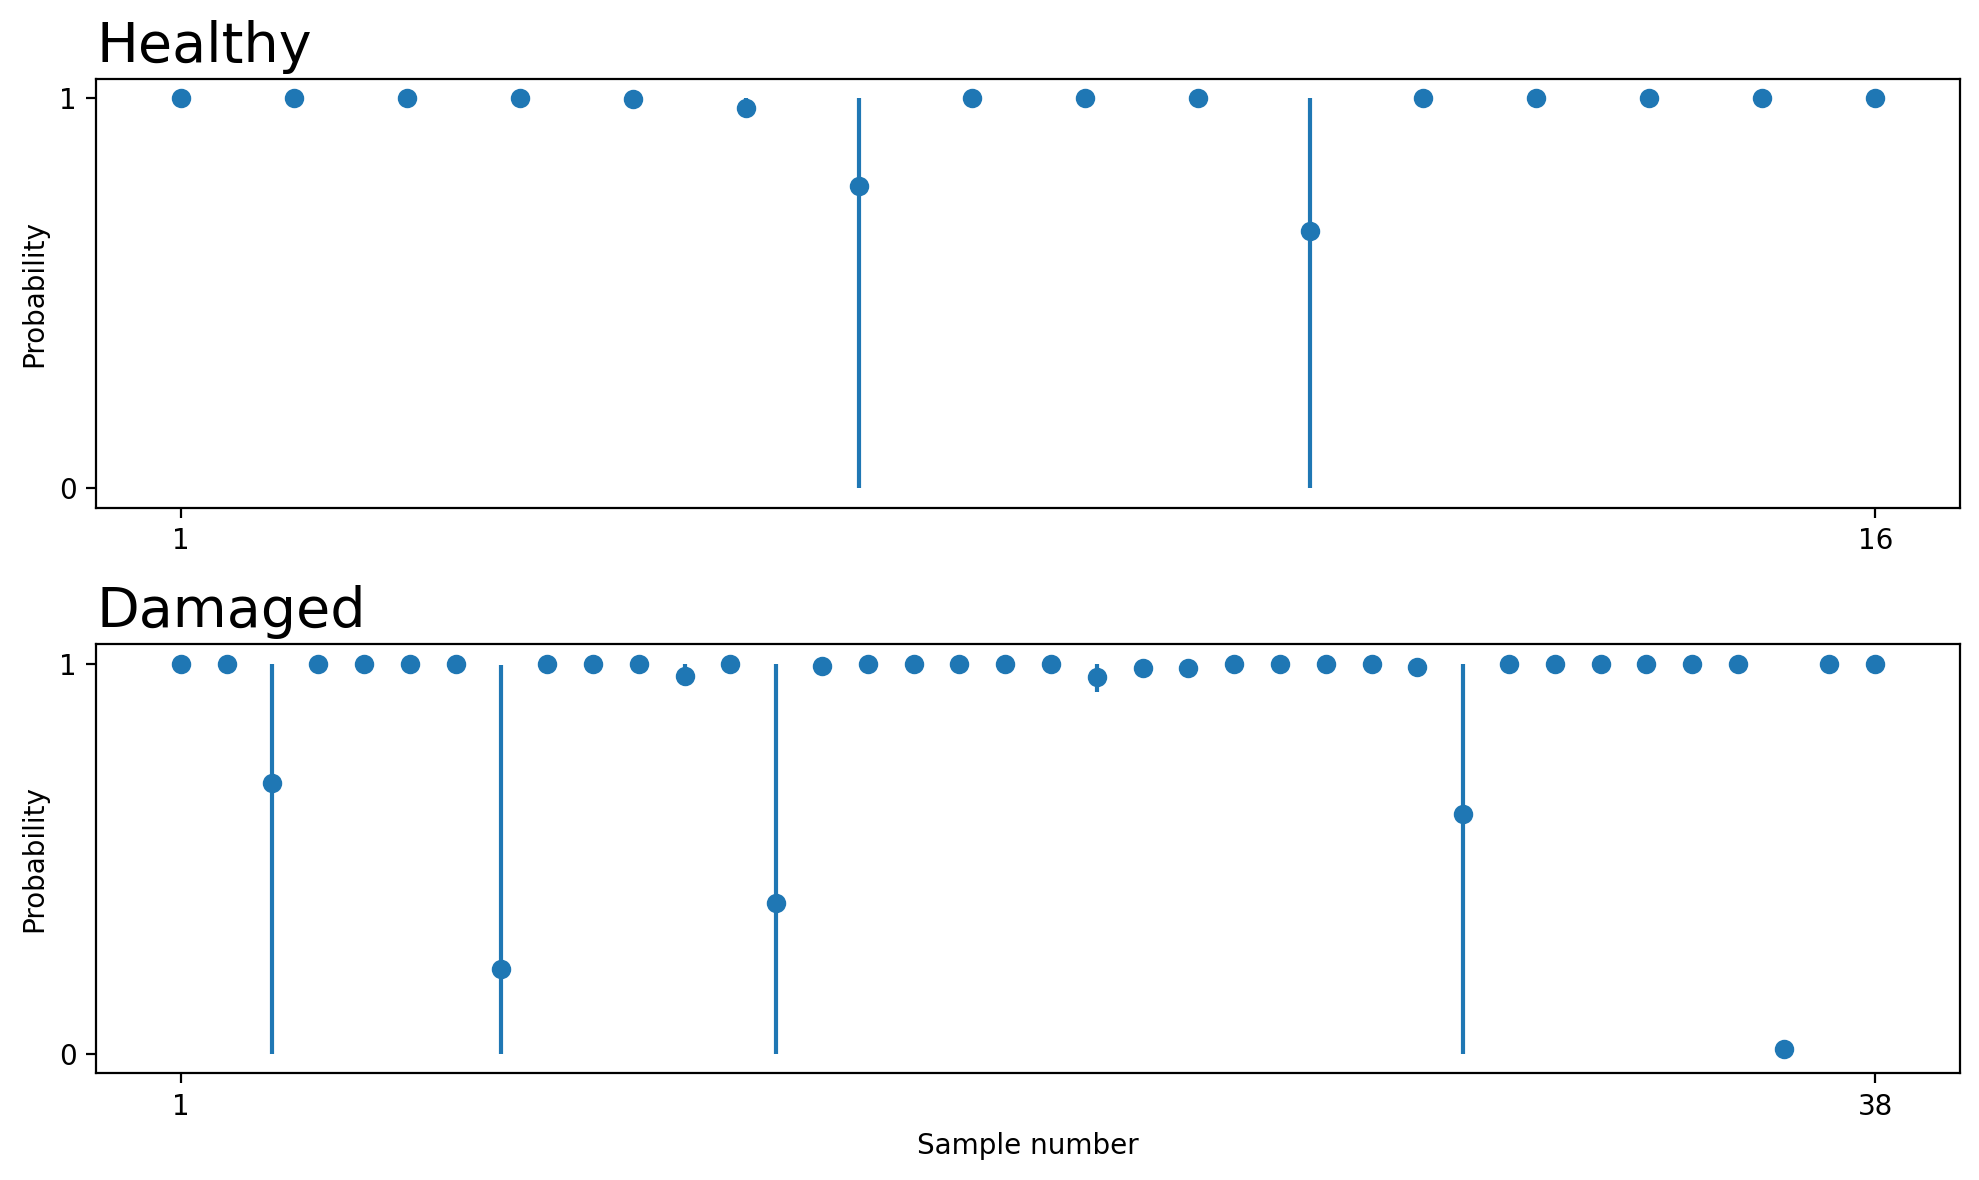

In [20]:
num_knots = 25
seed = 26042024
data, labels, IT, IL, total,B0,knot_list = prepare_data(acc,frequencies=None,training_samples=6, 
                                                        num_knots=num_knots, mode = 'binary', seed = seed)
model_2 = CmdStanModel(stan_file='stan/mix.stan')
hit_rate = get_results(model=model_2,data=data,seed=seed,labels=labels,IT=IT,IL=IL,total=total,plot=True,mode='binary')
print(f'Accuracy of single run {hit_rate}%')

Accuracy declined to 87,6 $\pm$ 4,9%, which was suprising to us, seeing that signals generated from model resembled reality with greater precision.

In [21]:
## Estimated time ~ 6 minutes

# num_knots = 25
# res = []
# for i in range(100):
#     data, labels, IT, IL, total ,B0, knot_list = prepare_data(acc, frequencies=None, training_samples=5, num_knots=num_knots, mode = 'binary')
#     res.append(get_results(model=model, data=data, labels=labels, IT=IT,IL=IL, total=total, mode='binary',plot=False))
# np.savetxt('results/acc_27.csv', res, delimiter=',', fmt='%f')

In [22]:
results = np.genfromtxt('results/acc_27.csv', delimiter=',')
mean = np.mean(results)
st_dev = np.std(results)
print(f'Mean accuracy: {np.round(mean,3)*100}% \nStandard deviation: {np.round(st_dev,3)*100}%')

Mean accuracy: 87.6% 
Standard deviation: 4.9%


---
### Model comparison [0-4 pts]:
- Have models been compared using information criteria [1 pt]
- Have result for WAIC been discussed (is there a clear winner, or is there an overlap, were there any warnings) [1 pt]
- Have result for PSIS-LOO been discussed (is there a clear winner, or is there an overlap, were there any warnings) [1 pt]
- Was the model comparison discussed? Do authors agree with information criteria? Why in your opinion one model better than another [1 pt]



#### *WAIC criterion*
<style>
.justify {
    text-align: justify;
}
</style>

In [47]:
splines_15_data = az.from_cmdstanpy(posterior=samples_posterior,log_likelihood='log_lik',
                          posterior_predictive='y_hat')

splines_27_data = az.from_cmdstanpy(posterior=samples_posterior_2,log_likelihood='log_lik',
                          posterior_predictive='y_hat')


/Users/kacperjarzyna/opt/anaconda3/envs/stan/lib/python3.12/site-packages/arviz/stats/stats.py:1648: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/kacperjarzyna/opt/anaconda3/envs/stan/lib/python3.12/site-packages/arviz/stats/stats.py:1648: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/kacperjarzyna/opt/anaconda3/envs/stan/lib/python3.12/site-packages/arviz/stats/stats.py:309: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (
/Users/

            rank   elpd_waic     p_waic  elpd_diff    weight         se  \
27 splines     0 -414.451384  19.752984    0.00000  0.496438  28.171746   
15 splines     1 -448.077193  14.073897   33.62581  0.503562  39.369459   

                  dse  warning scale  
27 splines   0.000000     True   log  
15 splines  41.326124     True   log  


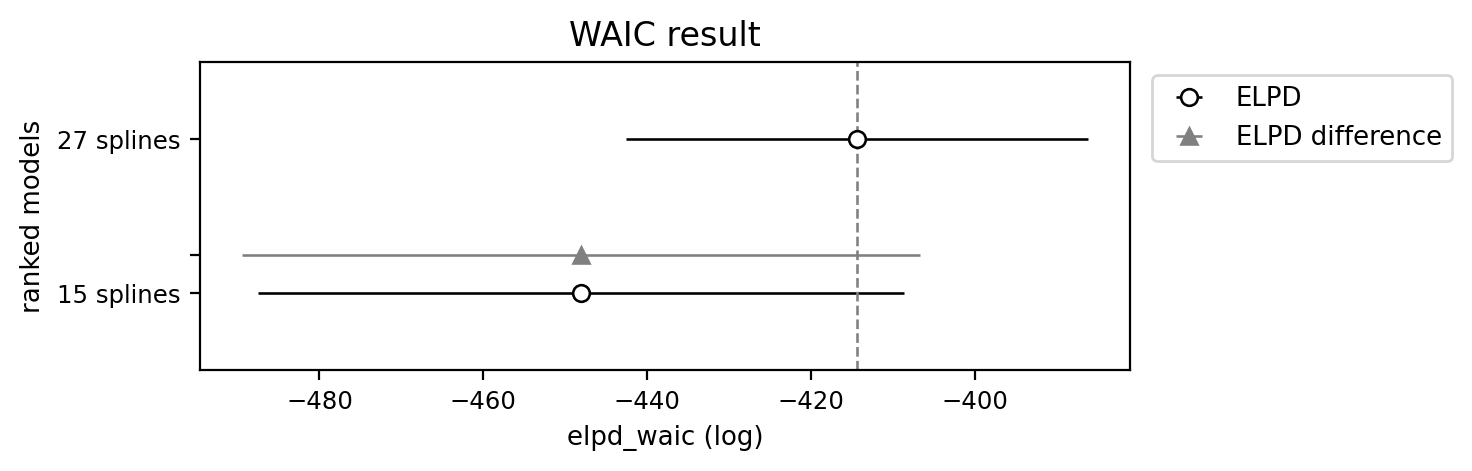

In [48]:
comparison_waic = az.compare({'15 splines': splines_15_data, '27 splines' : splines_27_data}, ic="waic")
print(comparison_waic)
az.plot_compare(comparison_waic)
plt.title('WAIC result')
plt.show()

Model 2, which takes in more basis functions, was recognized as the best model, evidenced by its lowest rank and highest relative weight. This model also demonstrated a superior out-of-sample predictive fit. Additionally, Model 2 has a higher estimated effective number of parameters. Both models exhibited similar standard errors in their WAIC estimates. The standard error of the difference between the two models is small, indicating significant overlap.  A warning occurred for both models, suggesting that the WAIC computation may not be reliable, likely due to the large number of parameters in each model.

<style>
.justify {
    text-align: justify;
}
</style>

/Users/kacperjarzyna/opt/anaconda3/envs/stan/lib/python3.12/site-packages/arviz/stats/stats.py:805: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


            rank    elpd_loo      p_loo  elpd_diff    weight         se  \
27 splines     0 -415.914113  21.215714   0.000000  0.493275  28.187633   
15 splines     1 -448.590730  14.587434  32.676617  0.506725  39.370189   

                  dse  warning scale  
27 splines   0.000000     True   log  
15 splines  41.341372     True   log  


/Users/kacperjarzyna/opt/anaconda3/envs/stan/lib/python3.12/site-packages/arviz/stats/stats.py:805: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/kacperjarzyna/opt/anaconda3/envs/stan/lib/python3.12/site-packages/arviz/stats/stats.py:309: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (
/Users/kacperjarzyna/opt/anaconda3/envs/stan/lib/python3.12/site-packages/arviz/stats/stats.py:309: FutureWarning: Setting an item of incompatible dtype is depreca

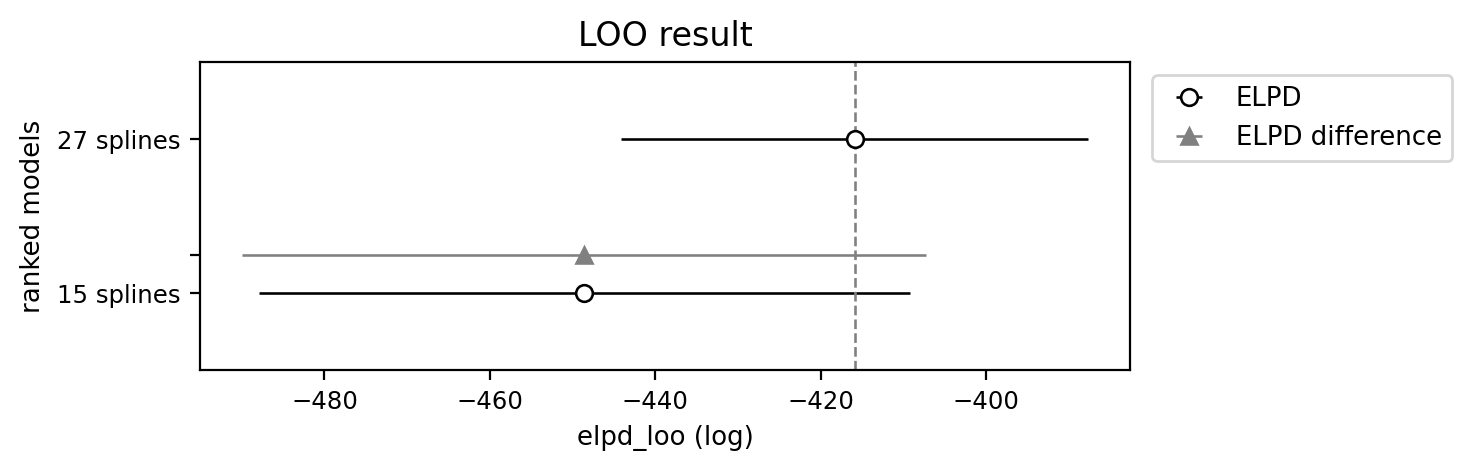

In [49]:
comparison_loo = az.compare({'15 splines': splines_15_data, '27 splines' : splines_27_data}, ic="loo")
print(comparison_loo)
az.plot_compare(comparison_loo)
plt.title('LOO result')
plt.show()

Model 2, which takes in more basis functions, was recognized as the best model due to its lowest rank and highest relative weight. This model also demonstrated superior out-of-sample predictive fit. Additionally, Model 2 has a higher estimated effective number of parameters. Both models exhibited similar standard errors in their LOO estimates. The standard error of the difference between the two models is small, indicating significant overlap.

A warning occurred for both models, suggesting that the LOO computation may not be reliable, likely due to the large number of parameters in each model.

<style>
.justify {
    text-align: justify;
}
</style>

#### Summary

For both information criterias we obtained similar results confirming what was expected - more complicated model performs better, as it can represent more accurately represent signals. However as observed better represantation doesn't mean better generalization, and can lead to overfitting.

<style>
.justify {
    text-align: justify;
}
</style>

---
### Additional tests


#### *Loading and organizing data rest of data*
<style>
.justify {
    text-align: justify;
}
</style>

In [51]:
gyro_healthy = pd.read_csv('data_preprocesed/gyro_healthy_samples.csv')
gyro_damaged = pd.read_csv('data_preprocesed/gyro_damaged_samples.csv')
gyro_very_damaged = pd.read_csv('data_preprocesed/gyro_very_damaged_samples.csv')

gyro_agg_healthy = pd.read_csv('data_preprocesed/gyro_agg_healthy_samples.csv')
gyro_agg_damaged = pd.read_csv('data_preprocesed/gyro_agg_damaged_samples.csv')
gyro_agg_very_damaged = pd.read_csv('data_preprocesed/gyro_agg_very_damaged_samples.csv')

gyro_healthy_data = np.array([gyro_healthy[col].values for col in gyro_healthy.columns if col.startswith('Sample')])
gyro_damaged_data = np.array([gyro_damaged[col].values for col in gyro_damaged.columns if col.startswith('Sample')])
gyro_very_damaged_data = np.array([gyro_very_damaged[col].values for col in gyro_very_damaged.columns if col.startswith('Sample')])
gyro = [gyro_healthy_data,gyro_damaged_data,gyro_very_damaged_data]

gyro_agg_healthy_data = np.array([gyro_agg_healthy[col].values for col in gyro_agg_healthy.columns if col.startswith('Sample')])
gyro_agg_damaged_data = np.array([gyro_agg_damaged[col].values for col in gyro_agg_damaged.columns if col.startswith('Sample')])
gyro_agg_very_damaged_data = np.array([gyro_agg_very_damaged[col].values for col in gyro_agg_very_damaged.columns if col.startswith('Sample')])
gyro_agg = [gyro_agg_healthy_data, gyro_agg_damaged_data, gyro_agg_very_damaged_data]

frequencies = gyro_damaged['Frequencies']


In [56]:
# # Estimated time ~ 42 minutes

test_knots = [13,25]
testing_data = [gyro,gyro_agg]
for num_knots in test_knots:
    for data_in,name in zip(testing_data,['gyro','gyro_agg']):
        res = []
        for i in range(100):
            data, labels, IT, IL, total ,B0, knot_list = prepare_data(data_in, frequencies=frequencies, training_samples=6, num_knots=num_knots, mode = 'binary')
            res.append(get_results(model=model, data=data, labels=labels, IT=IT,IL=IL, total=total, mode='binary',plot=False))
        np.savetxt(f'results/{name}_{num_knots+2}.csv', res, delimiter=',', fmt='%f')

21:24:47 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)



chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)

chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:01 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:01 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:01 Iteration: 1200 / 2000 [ 60%]  (Sampling)



chain 1 |███████▎  | 00:02 Iteration: 1300 / 2000 [ 65%]  (Sampling)


ch


21:24:51 - cmdstanpy - INFO - CmdStan done processing.
21:24:51 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

21:24:51 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)



chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)




chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)



chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)

chain 1 |█████▉    | 00:01 Iteration: 1001 / 2000 [ 50%]  (Sampling)

chain 1 |██████▎   | 00:01 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:01 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |███████▎  | 00:02 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |███████▋  | 00:02 Iteration: 1400 / 2000 [ 70%]  (Sampling)
chain 1 |████████▏ | 00:02 Iteration: 1500 / 2000 [ 75%]  (Sampling)




21:24:55 - cmdstanpy - INFO - CmdStan done processing.
21:24:55 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:24:55 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)

chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)




chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)



chain 1 |█████▉    | 00:01 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:01 Iteration: 1100 / 2000 [ 55%]  (Sampling)
chain 1 |██████▊   | 00:01 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |███████▎  | 00:02 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |███████▋  | 00:02 Iteration: 1400 / 2000 [ 70%]  (Sampling)


chain 1 |████████▏ | 00:02 Iteration: 1500 / 2000 [ 75%]  (Sampling)




21:24:58 - cmdstanpy - INFO - CmdStan done processing.
21:24:58 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

21:24:59 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)

chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)




chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)
chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:01 Iteration: 1001 / 2000 [ 50%]  (Sampling)

chain 1 |██████▎   | 00:01 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:01 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |███████▎  | 00:01 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain


21:25:02 - cmdstanpy - INFO - CmdStan done processing.
21:25:02 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:25:02 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)

chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)





chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:01 Iteration: 1001 / 2000 [ 50%]  (Sampling)



chain 1 |██████▎   | 00:01 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:01 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |███████▎  | 00:02 Iteration: 1300 / 2000 [ 65%]  (Sampling)


c


21:25:06 - cmdstanpy - INFO - CmdStan done processing.
21:25:06 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:25:06 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)




chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)

chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)




chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)
chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:01 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:01 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)
chain 1 |███████▎  | 00:02 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chai


21:25:10 - cmdstanpy - INFO - CmdStan done processing.
21:25:10 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:25:10 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:01 Iteration: 1001 / 2000 [ 50%]  (Sampling)

chain 1 |██████▎   | 00:01 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:01 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |███████▎  | 00:02 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain


21:25:13 - cmdstanpy - INFO - CmdStan done processing.
21:25:13 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


21:25:14 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)

chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)




chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)
chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)



chain 1 |█████▉    | 00:01 Iteration: 1001 / 2000 [ 50%]  (Sampling)




chain 1 |██████▎   | 00:01 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)



chain 1 |███████▎  | 00:02 Iteration: 1300 / 2000 [ 65%]  (Sampling)

ch


21:25:17 - cmdstanpy - INFO - CmdStan done processing.
21:25:17 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:25:18 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)




chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)
chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:01 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:01 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:01 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |███████▎  | 00:02 Iteration: 1300 / 2000 [ 65%]  (Sampling)


cha


21:25:21 - cmdstanpy - INFO - CmdStan done processing.
21:25:21 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

21:25:21 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)

chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)

chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)




chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:01 Iteration: 1001 / 2000 [ 50%]  (Sampling)
chain 1 |██████▎   | 00:01 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain


21:25:25 - cmdstanpy - INFO - CmdStan done processing.
21:25:25 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:25:26 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status







chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)

chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)
chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:01 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chai


21:25:29 - cmdstanpy - INFO - CmdStan done processing.
21:25:29 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:25:30 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)



chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)




chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)
chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)




chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:01 Iteration: 1001 / 2000 [ 50%]  (Sampling)
chain 1 |██████▎   | 00:01 Iteration: 1100 / 2000 [ 55%]  (Sampling)




chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |███████▎  | 00:02 Iteration: 1300 / 2000 [ 65%]  (Sampling)
chain 1 |███████▋  | 00:02 Iteration: 1400 / 2000 [ 70%]  (Sampling)



21:25:33 - cmdstanpy - INFO - CmdStan done processing.
21:25:33 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:25:34 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)

chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)



chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:01 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:01 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:01 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |███████▎  | 00:02 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chai


21:25:37 - cmdstanpy - INFO - CmdStan done processing.
21:25:37 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:25:37 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)
chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)




chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)
chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)




chain 1 |█████▉    | 00:01 Iteration: 1001 / 2000 [ 50%]  (Sampling)
chain 1 |██████▎   | 00:01 Iteration: 1100 / 2000 [ 55%]  (Sampling)




chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)
chain 


21:25:41 - cmdstanpy - INFO - CmdStan done processing.
21:25:41 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:25:41 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)

chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)



chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:01 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:01 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |███████▎  | 00:02 Iteration: 1300 / 2000 [ 65%]  (Sampling)


c


21:25:45 - cmdstanpy - INFO - CmdStan done processing.
21:25:45 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:25:45 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)



chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)

chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)



chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:01 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)


cha


21:25:49 - cmdstanpy - INFO - CmdStan done processing.
21:25:49 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


21:25:49 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)
chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)




chain 1 |█████▉    | 00:01 Iteration: 1001 / 2000 [ 50%]  (Sampling)
chain 1 |██████▎   | 00:01 Iteration: 1100 / 2000 [ 55%]  (Sampling)




chain 1 |██████▊   | 00:01 Iteration: 1200 / 2000 [ 60%]  (Sampling)
chain 1 


21:25:53 - cmdstanpy - INFO - CmdStan done processing.
21:25:53 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

21:25:53 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)

chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:01 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:01 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 


21:25:57 - cmdstanpy - INFO - CmdStan done processing.
21:25:57 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:25:57 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)




chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)

chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:01 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:01 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:01 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |███████▎  | 00:02 Iteration: 1300 / 2000 [ 65%]  (Sampling)


c


21:26:01 - cmdstanpy - INFO - CmdStan done processing.
21:26:01 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:26:01 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)

chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:01 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:01 Iteration: 1100 / 2000 [ 55%]  (Sampling)

chain 1 |██████▊   | 00:01 Iteration: 1200 / 2000 [ 60%]  (Sampling)



chain 1


21:26:05 - cmdstanpy - INFO - CmdStan done processing.
21:26:05 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

21:26:05 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status



chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)

chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)



chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)

chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)





chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:01 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:02 Iteration: 

21:26:09 - cmdstanpy - INFO - CmdStan done processing.
21:26:09 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

21:26:10 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)



chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)

chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)



chain 1 |█████▉    | 00:01 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:01 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain


21:26:13 - cmdstanpy - INFO - CmdStan done processing.
21:26:13 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


21:26:14 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)
chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)





chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:01 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:01 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:01 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |███████▎  | 00:02 Iteration: 1300 / 2000 [ 65%]  (Sampling)


c


21:26:17 - cmdstanpy - INFO - CmdStan done processing.
21:26:17 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:26:18 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)

chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:01 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:01 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chai


21:26:21 - cmdstanpy - INFO - CmdStan done processing.
21:26:21 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:26:22 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:01 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:01 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain


21:26:25 - cmdstanpy - INFO - CmdStan done processing.
21:26:25 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:26:26 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status






chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)




chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)
chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)
chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:01 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:01 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)

chain


21:26:29 - cmdstanpy - INFO - CmdStan done processing.
21:26:29 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:26:30 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:01 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:01 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)
chain 1 


21:26:34 - cmdstanpy - INFO - CmdStan done processing.
21:26:34 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

21:26:34 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)



chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)

chain 1 |█████▉    | 00:01 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:01 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain


21:26:38 - cmdstanpy - INFO - CmdStan done processing.
21:26:38 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:26:38 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:01 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:01 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)


cha


21:26:42 - cmdstanpy - INFO - CmdStan done processing.
21:26:42 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

21:26:42 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)

chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)



chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)

chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:01 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chai


21:26:46 - cmdstanpy - INFO - CmdStan done processing.
21:26:46 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:26:47 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)



chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)

chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)




chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)



chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)

chai


21:26:51 - cmdstanpy - INFO - CmdStan done processing.
21:26:51 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


21:26:51 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)

chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)



chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)

chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)



chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)

chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chai


21:26:55 - cmdstanpy - INFO - CmdStan done processing.
21:26:56 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:26:56 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)

chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)



chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:01 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:01 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 


21:27:00 - cmdstanpy - INFO - CmdStan done processing.
21:27:00 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


21:27:00 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)

chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:01 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:01 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 


21:27:04 - cmdstanpy - INFO - CmdStan done processing.
21:27:04 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


21:27:04 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)

chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)



chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)

chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)



chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)

chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:01 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:01 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 


21:27:08 - cmdstanpy - INFO - CmdStan done processing.
21:27:08 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:27:09 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:01 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)


cha


21:27:12 - cmdstanpy - INFO - CmdStan done processing.
21:27:12 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


21:27:13 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)
chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)

chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:01 Iteration: 1001 / 2000 [ 50%]  (Sampling)



chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)

chain 


21:27:17 - cmdstanpy - INFO - CmdStan done processing.
21:27:17 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:27:17 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:01 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:01 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 


21:27:21 - cmdstanpy - INFO - CmdStan done processing.
21:27:21 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

21:27:21 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:01 Iteration: 1001 / 2000 [ 50%]  (Sampling)



chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)




chain 1 |███████▎  | 00:02 Iteration: 1300 / 2000 [ 65%]  (Sampling)


c


21:27:25 - cmdstanpy - INFO - CmdStan done processing.
21:27:25 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:27:26 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)




chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:01 Iteration: 1001 / 2000 [ 50%]  (Sampling)



chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)
chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)

chain 

21:27:30 - cmdstanpy - INFO - CmdStan done processing.
21:27:30 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

21:27:30 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)
chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:01 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:01 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain


21:27:34 - cmdstanpy - INFO - CmdStan done processing.
21:27:34 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


21:27:34 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)
chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)




chain 1 |█████▉    | 00:01 Iteration: 1001 / 2000 [ 50%]  (Sampling)
chain 1 |██████▎   | 00:01 Iteration: 1100 / 2000 [ 55%]  (Sampling)




chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)
chain 1 


21:27:38 - cmdstanpy - INFO - CmdStan done processing.
21:27:38 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:27:39 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:01 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)


cha


21:27:43 - cmdstanpy - INFO - CmdStan done processing.
21:27:43 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


21:27:43 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:01 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |███████▎  | 00:02 Iteration: 1300 / 2000 [ 65%]  (Sampling)


c


21:27:47 - cmdstanpy - INFO - CmdStan done processing.
21:27:47 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:27:48 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:01 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 


21:27:52 - cmdstanpy - INFO - CmdStan done processing.
21:27:52 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:27:52 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)
chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)




chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)



chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)

chain 


21:27:57 - cmdstanpy - INFO - CmdStan done processing.
21:27:57 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:27:57 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)

chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)



chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:01 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain


21:28:02 - cmdstanpy - INFO - CmdStan done processing.
21:28:02 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


21:28:02 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:01 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)


cha


21:28:06 - cmdstanpy - INFO - CmdStan done processing.
21:28:06 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:28:07 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:01 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain


21:28:11 - cmdstanpy - INFO - CmdStan done processing.
21:28:11 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


21:28:11 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:01 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)


cha


21:28:16 - cmdstanpy - INFO - CmdStan done processing.
21:28:16 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

21:28:16 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)
chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)




chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)
chain


21:28:20 - cmdstanpy - INFO - CmdStan done processing.
21:28:21 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:28:21 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)
chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain


21:28:25 - cmdstanpy - INFO - CmdStan done processing.
21:28:25 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


21:28:26 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)




chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)
chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:01 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)


cha


21:28:30 - cmdstanpy - INFO - CmdStan done processing.
21:28:30 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

21:28:31 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status






chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)

chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)


cha


21:28:35 - cmdstanpy - INFO - CmdStan done processing.
21:28:35 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:28:36 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)



chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)

chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)


cha


21:28:40 - cmdstanpy - INFO - CmdStan done processing.
21:28:40 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


21:28:41 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)




chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)


cha


21:28:45 - cmdstanpy - INFO - CmdStan done processing.
21:28:45 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:28:46 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:01 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 


21:28:50 - cmdstanpy - INFO - CmdStan done processing.
21:28:50 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:28:51 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)

chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)
chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)




chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chai


21:28:55 - cmdstanpy - INFO - CmdStan done processing.
21:28:55 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


21:28:56 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)




chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)
chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:01 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 


21:29:00 - cmdstanpy - INFO - CmdStan done processing.
21:29:00 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:29:01 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 


21:29:05 - cmdstanpy - INFO - CmdStan done processing.
21:29:05 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:29:06 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)




chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)
chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)




chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)
chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)

chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 


21:29:10 - cmdstanpy - INFO - CmdStan done processing.
21:29:10 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

21:29:11 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)





chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:03 Iteration: 1200 / 2000 [ 60%]  (Sampling)
cha


21:29:16 - cmdstanpy - INFO - CmdStan done processing.
21:29:16 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:29:16 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)
chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)




chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)
chain 1 |█████▉    | 00:01 Iteration: 1001 / 2000 [ 50%]  (Sampling)




chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)
chain


21:29:21 - cmdstanpy - INFO - CmdStan done processing.
21:29:21 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


21:29:21 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)




chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)
chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)




cha


21:29:26 - cmdstanpy - INFO - CmdStan done processing.
21:29:26 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:29:26 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:01 Iteration: 1001 / 2000 [ 50%]  (Sampling)

chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 


21:29:31 - cmdstanpy - INFO - CmdStan done processing.
21:29:31 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


21:29:31 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)
chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)




chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)
chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)




cha


21:29:36 - cmdstanpy - INFO - CmdStan done processing.
21:29:36 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

21:29:36 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)



chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)
chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)




chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:01 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)


ch


21:29:41 - cmdstanpy - INFO - CmdStan done processing.
21:29:41 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

21:29:42 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)
chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)




chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:03 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chai


21:29:47 - cmdstanpy - INFO - CmdStan done processing.
21:29:47 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:29:47 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chai


21:29:52 - cmdstanpy - INFO - CmdStan done processing.
21:29:52 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:29:52 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)


cha


21:29:57 - cmdstanpy - INFO - CmdStan done processing.
21:29:57 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:29:57 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)

chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)



chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)




chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)
chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)




chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)


cha


21:30:02 - cmdstanpy - INFO - CmdStan done processing.
21:30:02 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


21:30:02 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)



chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)
chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)




chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)
chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)




cha


21:30:07 - cmdstanpy - INFO - CmdStan done processing.
21:30:07 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


21:30:08 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)

chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:01 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)



chain


21:30:12 - cmdstanpy - INFO - CmdStan done processing.
21:30:12 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:30:13 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 


21:30:17 - cmdstanpy - INFO - CmdStan done processing.
21:30:17 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


21:30:18 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)




chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)
chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)




chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:01 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)
chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain


21:30:22 - cmdstanpy - INFO - CmdStan done processing.
21:30:22 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:30:23 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)




chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chai


21:30:27 - cmdstanpy - INFO - CmdStan done processing.
21:30:27 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


21:30:28 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)




chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)
chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)


cha


21:30:32 - cmdstanpy - INFO - CmdStan done processing.
21:30:33 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


21:30:33 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)

chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)
chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)




chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)



chain 1 |█████▉    | 00:01 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 


21:30:38 - cmdstanpy - INFO - CmdStan done processing.
21:30:38 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

21:30:38 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)


cha


21:30:43 - cmdstanpy - INFO - CmdStan done processing.
21:30:43 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

21:30:43 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 


21:30:48 - cmdstanpy - INFO - CmdStan done processing.
21:30:48 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

21:30:49 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status






chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)

chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)


cha


21:30:53 - cmdstanpy - INFO - CmdStan done processing.
21:30:53 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:30:54 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)
chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)




chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)


cha


21:30:59 - cmdstanpy - INFO - CmdStan done processing.
21:30:59 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:30:59 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)




chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)
chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)


cha


21:31:03 - cmdstanpy - INFO - CmdStan done processing.
21:31:04 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:31:04 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)

chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)



chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 


21:31:09 - cmdstanpy - INFO - CmdStan done processing.
21:31:09 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:31:09 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:01 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)



chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain


21:31:14 - cmdstanpy - INFO - CmdStan done processing.
21:31:14 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


21:31:14 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)

chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)
chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)





chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:03 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |███████▎  | 00:03 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 


21:31:20 - cmdstanpy - INFO - CmdStan done processing.
21:31:20 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:31:20 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▍         | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:01 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:03 Iteration: 12


21:31:26 - cmdstanpy - INFO - CmdStan done processing.
21:31:26 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:31:26 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)

chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chai


21:31:31 - cmdstanpy - INFO - CmdStan done processing.
21:31:31 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


21:31:32 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)




chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)
chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)




chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)
chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)




chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)
chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chai


21:31:36 - cmdstanpy - INFO - CmdStan done processing.
21:31:36 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:31:37 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)
chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)

chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1


21:31:42 - cmdstanpy - INFO - CmdStan done processing.
21:31:42 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:31:43 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)




chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)
chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:03 Iteration: 1200 / 2000 [ 60%]  (Sampling)




c


21:31:48 - cmdstanpy - INFO - CmdStan done processing.
21:31:48 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


21:31:49 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status


chain 1 |▉         | 00:01 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:01 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:02 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:02 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:03 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:03 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:03 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:03 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:04 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:04 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:04 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:05 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:05 Iteration: 120


21:31:56 - cmdstanpy - INFO - CmdStan done processing.
21:31:56 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

21:31:57 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:03 Iteration: 1200 / 2000 [ 60%]  (Sampling)

chain 

21:32:02 - cmdstanpy - INFO - CmdStan done processing.
21:32:02 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

21:32:03 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)


cha


21:32:08 - cmdstanpy - INFO - CmdStan done processing.
21:32:08 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

21:32:08 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 


21:32:13 - cmdstanpy - INFO - CmdStan done processing.
21:32:13 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


21:32:14 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)

chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:03 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 


21:32:19 - cmdstanpy - INFO - CmdStan done processing.
21:32:19 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:32:20 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chai


21:32:24 - cmdstanpy - INFO - CmdStan done processing.
21:32:24 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


21:32:25 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 


21:32:30 - cmdstanpy - INFO - CmdStan done processing.
21:32:30 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

21:32:31 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:01 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)




chain 1 |███▋      | 00:02 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)
chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)





chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)

chain 1 |██████▊   | 00:03 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chai


21:32:36 - cmdstanpy - INFO - CmdStan done processing.
21:32:36 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:32:37 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)


cha


21:32:41 - cmdstanpy - INFO - CmdStan done processing.
21:32:41 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

21:32:42 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)
chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)



chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)




chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)


cha


21:32:46 - cmdstanpy - INFO - CmdStan done processing.
21:32:46 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:32:47 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)

chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)



chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)

chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)



chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)


cha


21:32:52 - cmdstanpy - INFO - CmdStan done processing.
21:32:52 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


21:32:52 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)
chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 


21:32:57 - cmdstanpy - INFO - CmdStan done processing.
21:32:57 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


21:32:58 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)



chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)

chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)


cha


21:33:02 - cmdstanpy - INFO - CmdStan done processing.
21:33:02 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:33:03 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)
chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 


21:33:07 - cmdstanpy - INFO - CmdStan done processing.
21:33:07 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:33:08 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status






chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)




chain 1 |█▊        | 00:01 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)



chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)

chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)
chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:03 Iteration: 1200 / 2000 [ 60%]  (Sampling)


ch


21:33:13 - cmdstanpy - INFO - CmdStan done processing.
21:33:13 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


21:33:13 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)




chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)


cha


21:33:18 - cmdstanpy - INFO - CmdStan done processing.
21:33:18 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:33:19 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)



chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)

chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)

chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)




chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)




chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)
chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)





chain 1 |███████▎  | 00:03 Iteration: 1300 / 2000 [ 65%]  (Sampling)


21:33:23 - cmdstanpy - INFO - CmdStan done processing.
21:33:23 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:33:24 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chai


21:33:29 - cmdstanpy - INFO - CmdStan done processing.
21:33:29 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:33:29 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)



chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chai


21:33:34 - cmdstanpy - INFO - CmdStan done processing.
21:33:34 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


21:33:34 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)
chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)




chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)
chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:03 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 


21:33:39 - cmdstanpy - INFO - CmdStan done processing.
21:33:40 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


21:33:40 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chai


21:33:45 - cmdstanpy - INFO - CmdStan done processing.
21:33:45 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:33:45 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)

chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)



chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)
chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:03 Iteration: 1200 / 2000 [ 60%]  (Sampling)

chain 

21:33:50 - cmdstanpy - INFO - CmdStan done processing.
21:33:51 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

21:33:51 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)



chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)


cha


21:33:56 - cmdstanpy - INFO - CmdStan done processing.
21:33:56 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:33:56 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)



chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)

chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)
chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)




chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)
chain


21:34:01 - cmdstanpy - INFO - CmdStan done processing.
21:34:01 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

21:34:02 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:03 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 


21:34:07 - cmdstanpy - INFO - CmdStan done processing.
21:34:07 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

21:34:07 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)
chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)




chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 


21:34:12 - cmdstanpy - INFO - CmdStan done processing.
21:34:12 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:34:13 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)





chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)
chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)

chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)
chain 1 


21:34:18 - cmdstanpy - INFO - CmdStan done processing.
21:34:18 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:34:18 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)




chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)
chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain


21:34:23 - cmdstanpy - INFO - CmdStan done processing.
21:34:23 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:34:24 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)



chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)

chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)



chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)

chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)


cha


21:34:29 - cmdstanpy - INFO - CmdStan done processing.
21:34:29 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


21:34:29 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)




chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)
chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)




chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)



chain 1 |██████▊   | 00:03 Iteration: 1200 / 2000 [ 60%]  (Sampling)


cha


21:34:34 - cmdstanpy - INFO - CmdStan done processing.
21:34:34 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:34:35 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:01 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)

chain 1 |███▏      | 00:02 Iteration:  500 / 2000 [ 25%]  (Warmup)



chain 1 |███▋      | 00:02 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)

chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:03 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain


21:34:40 - cmdstanpy - INFO - CmdStan done processing.
21:34:41 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


21:34:41 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)




chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)



chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:03 Iteration: 1200 / 2000 [ 60%]  (Sampling)


cha

21:34:46 - cmdstanpy - INFO - CmdStan done processing.
21:34:46 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

21:34:47 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)




chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)
chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 


21:34:51 - cmdstanpy - INFO - CmdStan done processing.
21:34:52 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:34:52 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:01 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 


21:34:57 - cmdstanpy - INFO - CmdStan done processing.
21:34:57 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


21:34:57 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)





chain 1 |█████▉    | 00:01 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)

chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |███████▎  | 00:02 Iteration: 1300 / 2000 [ 65%]  (Sampling)



chain 1 |███████▋  | 00:03 Iteration: 1400 / 2000 [ 70%]  (Sampling)



21:35:02 - cmdstanpy - INFO - CmdStan done processing.
21:35:02 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


21:35:03 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)


cha


21:35:07 - cmdstanpy - INFO - CmdStan done processing.
21:35:07 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


21:35:08 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chai


21:35:13 - cmdstanpy - INFO - CmdStan done processing.
21:35:13 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:35:13 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)




chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)



chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)

chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)
chain 1 |██████▊   | 00:03 Iteration: 1200 / 2000 [ 60%]  (Sampling)


cha


21:35:18 - cmdstanpy - INFO - CmdStan done processing.
21:35:18 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


21:35:19 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status




chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)
chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:01 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:03 Iteration: 120


21:35:24 - cmdstanpy - INFO - CmdStan done processing.
21:35:24 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:35:25 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)



chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)

chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)



cha


21:35:29 - cmdstanpy - INFO - CmdStan done processing.
21:35:30 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


21:35:30 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)

chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)



chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 


21:35:35 - cmdstanpy - INFO - CmdStan done processing.
21:35:35 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

21:35:35 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:03 Iteration: 1200 / 2000 [ 60%]  (Sampling)


cha


21:35:41 - cmdstanpy - INFO - CmdStan done processing.
21:35:41 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


21:35:41 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 

21:35:46 - cmdstanpy - INFO - CmdStan done processing.
21:35:46 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

21:35:47 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status






chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)

chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)



chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)

chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)



chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)

chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)



chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)

chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)


cha


21:35:51 - cmdstanpy - INFO - CmdStan done processing.
21:35:51 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:35:52 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chai


21:35:56 - cmdstanpy - INFO - CmdStan done processing.
21:35:57 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:35:57 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)



chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)

chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)



chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain


21:36:02 - cmdstanpy - INFO - CmdStan done processing.
21:36:02 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:36:02 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)




chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)
chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 


21:36:07 - cmdstanpy - INFO - CmdStan done processing.
21:36:07 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

21:36:07 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:01 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain


21:36:12 - cmdstanpy - INFO - CmdStan done processing.
21:36:12 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:36:13 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)
chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)

chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)
chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)



chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)




chain 1 |█████▉    | 00:01 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1


21:36:17 - cmdstanpy - INFO - CmdStan done processing.
21:36:17 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


21:36:18 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)



chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain


21:36:22 - cmdstanpy - INFO - CmdStan done processing.
21:36:22 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:36:23 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 


21:36:27 - cmdstanpy - INFO - CmdStan done processing.
21:36:27 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

21:36:28 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)

chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)



chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)

chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)



chain 1 |█████▉    | 00:01 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 


21:36:32 - cmdstanpy - INFO - CmdStan done processing.
21:36:33 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:36:33 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)
chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)




chain 1 |█████▉    | 00:01 Iteration: 1001 / 2000 [ 50%]  (Sampling)
chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)




chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 


21:36:38 - cmdstanpy - INFO - CmdStan done processing.
21:36:38 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


21:36:38 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:01 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)




chai


21:36:43 - cmdstanpy - INFO - CmdStan done processing.
21:36:43 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:36:43 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)
chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)




chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)



cha


21:36:48 - cmdstanpy - INFO - CmdStan done processing.
21:36:48 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:36:49 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status







chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)



chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)

chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)



chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:03 Iteration: 1200 / 2000 [ 60%]  (Sampling)

c


21:36:53 - cmdstanpy - INFO - CmdStan done processing.


21:36:54 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/

21:36:59 - cmdstanpy - INFO - CmdStan done processing.
21:36:59 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

21:36:59 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)
chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)




chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)
chain 

21:37:04 - cmdstanpy - INFO - CmdStan done processing.
21:37:04 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

21:37:04 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)



chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)

chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:01 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 

21:37:09 - cmdstanpy - INFO - CmdStan done processing.
21:37:09 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

21:37:10 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)

chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)
chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:01 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)




chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1

21:37:14 - cmdstanpy - INFO - CmdStan done processing.
21:37:14 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

21:37:15 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)




chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)
chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)


cha


21:37:19 - cmdstanpy - INFO - CmdStan done processing.
21:37:19 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:37:20 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)




chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)



chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)

chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)
chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)




chai


21:37:24 - cmdstanpy - INFO - CmdStan done processing.
21:37:24 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:37:25 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)


cha


21:37:30 - cmdstanpy - INFO - CmdStan done processing.
21:37:30 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


21:37:30 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)

chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)



chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)

chain 


21:37:35 - cmdstanpy - INFO - CmdStan done processing.
21:37:35 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


21:37:35 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:01 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain


21:37:40 - cmdstanpy - INFO - CmdStan done processing.
21:37:40 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:37:40 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)


cha


21:37:45 - cmdstanpy - INFO - CmdStan done processing.
21:37:45 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:37:46 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)

chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:02 Iteration: 1200


21:37:50 - cmdstanpy - INFO - CmdStan done processing.
21:37:50 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:37:51 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)

chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)



chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)


cha


21:37:55 - cmdstanpy - INFO - CmdStan done processing.
21:37:55 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:37:56 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 


21:38:01 - cmdstanpy - INFO - CmdStan done processing.
21:38:01 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:38:01 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)



chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)




chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)


cha


21:38:06 - cmdstanpy - INFO - CmdStan done processing.
21:38:06 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:38:06 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)



chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)




chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)



chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)

chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:03 Iteration: 1200 / 2000 [ 60%]  (Sampling)



chain 1 |███████▎  | 00:03 Iteration: 1300 / 2000 [ 65%]  (Sampling)



21:38:12 - cmdstanpy - INFO - CmdStan done processing.
21:38:12 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:38:12 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)



chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain


21:38:17 - cmdstanpy - INFO - CmdStan done processing.
21:38:17 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:38:18 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)



chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)
chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)




chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:01 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain


21:38:22 - cmdstanpy - INFO - CmdStan done processing.
21:38:22 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:38:23 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)



chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)

chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)


cha


21:38:27 - cmdstanpy - INFO - CmdStan done processing.
21:38:27 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:38:28 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)



chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:01 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |███████▎  | 00:02 Iteration: 1300 / 2000 [ 65%]  (Sampling)





21:38:32 - cmdstanpy - INFO - CmdStan done processing.
21:38:32 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:38:33 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)




chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)
chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain


21:38:38 - cmdstanpy - INFO - CmdStan done processing.
21:38:38 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:38:38 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)



chain 1 |█████▉    | 00:01 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |███████▎  | 00:02 Iteration: 1300 / 2000 [ 65%]  (Sampling)


c


21:38:43 - cmdstanpy - INFO - CmdStan done processing.
21:38:43 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

21:38:43 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)



chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)

chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)



chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain


21:38:48 - cmdstanpy - INFO - CmdStan done processing.
21:38:48 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

21:38:49 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:01 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 


21:38:53 - cmdstanpy - INFO - CmdStan done processing.
21:38:53 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:38:54 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 


21:38:59 - cmdstanpy - INFO - CmdStan done processing.
21:38:59 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:38:59 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)



chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)

chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 


21:39:04 - cmdstanpy - INFO - CmdStan done processing.
21:39:04 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:39:04 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:01 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain


21:39:09 - cmdstanpy - INFO - CmdStan done processing.
21:39:09 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


21:39:10 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:01 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 

21:39:14 - cmdstanpy - INFO - CmdStan done processing.
21:39:14 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


21:39:15 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)




chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)
chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)




chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)
chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain


21:39:20 - cmdstanpy - INFO - CmdStan done processing.
21:39:20 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


21:39:20 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)

chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)



chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:02 Iteration: 120


21:39:25 - cmdstanpy - INFO - CmdStan done processing.
21:39:26 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

21:39:26 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)

chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)



chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)

chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)



chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)


cha


21:39:31 - cmdstanpy - INFO - CmdStan done processing.
21:39:31 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:39:32 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)
chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)




chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)
chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)




chain 


21:39:36 - cmdstanpy - INFO - CmdStan done processing.
21:39:37 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:39:37 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)



chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain


21:39:42 - cmdstanpy - INFO - CmdStan done processing.
21:39:42 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:39:43 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)
chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain


21:39:47 - cmdstanpy - INFO - CmdStan done processing.
21:39:48 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:39:48 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:01 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |███████▎  | 00:02 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chai


21:39:53 - cmdstanpy - INFO - CmdStan done processing.
21:39:53 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

21:39:53 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)



chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)

chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)



chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)

chain 1 |██████▊   | 00:03 Iteration: 1200 / 2000 [ 60%]  (Sampling)



ch


21:39:58 - cmdstanpy - INFO - CmdStan done processing.
21:39:59 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:39:59 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)
chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)




chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chai


21:40:04 - cmdstanpy - INFO - CmdStan done processing.
21:40:04 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:40:05 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)




chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)
chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)



chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)
chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chai


21:40:09 - cmdstanpy - INFO - CmdStan done processing.
21:40:09 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:40:10 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)
chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)




chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)
chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 


21:40:15 - cmdstanpy - INFO - CmdStan done processing.
21:40:15 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


21:40:15 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status






chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)







21:40:20 - cmdstanpy - INFO - CmdStan done processing.
21:40:20 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


21:40:20 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 


21:40:25 - cmdstanpy - INFO - CmdStan done processing.
21:40:25 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:40:26 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▍         | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)




chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)
chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:02 Iteration: 12


21:40:30 - cmdstanpy - INFO - CmdStan done processing.
21:40:30 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

21:40:31 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)



chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain


21:40:36 - cmdstanpy - INFO - CmdStan done processing.
21:40:36 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:40:36 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)
chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)

chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)





chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chai


21:40:41 - cmdstanpy - INFO - CmdStan done processing.
21:40:41 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


21:40:42 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)
chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)




chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 


21:40:47 - cmdstanpy - INFO - CmdStan done processing.
21:40:47 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

21:40:47 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)

chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:03 Iteration: 1200 / 2000 [ 60%]  (Sampling)



cha


21:40:53 - cmdstanpy - INFO - CmdStan done processing.
21:40:53 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:40:53 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)



chain 1 |█▊        | 00:01 Iteration:  200 / 2000 [ 10%]  (Warmup)

chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)



chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:02 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)

chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:03 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:03 Iteration: 1200 / 2000 [ 60%]  (Sampling)








21:40:59 - cmdstanpy - INFO - CmdStan done processing.


21:41:00 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/


21:41:05 - cmdstanpy - INFO - CmdStan done processing.
21:41:05 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:41:06 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)


cha


21:41:11 - cmdstanpy - INFO - CmdStan done processing.
21:41:11 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


21:41:11 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 


21:41:16 - cmdstanpy - INFO - CmdStan done processing.
21:41:16 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

21:41:17 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)



chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)




chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:03 Iteration: 1200 / 2000 [ 60%]  (Sampling)


cha


21:41:22 - cmdstanpy - INFO - CmdStan done processing.
21:41:22 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:41:23 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)
chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:03 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain


21:41:28 - cmdstanpy - INFO - CmdStan done processing.
21:41:28 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:41:29 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)
chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)

chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)



chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)

chain 1 |██████▊   | 00:03 Iteration: 1200 / 2000 [ 60%]  (Sampling)



chain


21:41:34 - cmdstanpy - INFO - CmdStan done processing.
21:41:34 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

21:41:35 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)
chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)




chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:03 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chai


21:41:40 - cmdstanpy - INFO - CmdStan done processing.
21:41:41 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

21:41:41 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status








chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:01 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:01 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:02 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:02 Iteration:  500 / 2000 [ 25%]  (Warmup)




chain 1 |███▋      | 00:02 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:03 Iteration:  700 / 2000 [ 35%]  (Warmup)
chain 1 |████▌     | 00:03 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:03 Iteration:  900 / 2000 [ 45%]  (Warmup)




chain 1 |█████▉    | 00:03 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:04 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:04 Iteration: 1200 / 2000 [ 60%]  (Sampling)



21:41:48 - cmdstanpy - INFO - CmdStan done processing.
21:41:48 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:41:49 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)
chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)




chain 1 |█▊        | 00:01 Iteration:  200 / 2000 [ 10%]  (Warmup)
chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)




chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)
chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:02 Iteration:  600 / 2000 [ 30%]  (Warmup)




chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)
chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:03 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:03 Iteration: 1200 / 2000 [ 60%]  (Sampling)



chai


21:41:55 - cmdstanpy - INFO - CmdStan done processing.
21:41:56 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:41:56 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)

chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:01 Iteration:  200 / 2000 [ 10%]  (Warmup)
chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:02 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:02 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:03 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:03 Iteration:  900 / 2000 [ 45%]  (Warmup)




chain 1 |█████▉    | 00:03 Iteration: 1001 / 2000 [ 50%]  (Sampling)
chain 1 |██████▎   | 00:04 Iteration: 1100 / 2000 [ 55%]  (Sampling)





chain 1 |██████▊   | 00:04 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain


21:42:04 - cmdstanpy - INFO - CmdStan done processing.
21:42:04 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:42:04 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:01 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:02 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:02 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:03 Iteration:  900 / 2000 [ 45%]  (Warmup)





chain 1 |█████▉    | 00:03 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:04 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:04 Iteration: 1200 / 2000 [ 60%]  (Sampling)


cha


21:42:11 - cmdstanpy - INFO - CmdStan done processing.
21:42:11 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:42:12 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:01 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:02 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:03 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:03 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:04 Iteration: 1200 / 2000 [ 60%]  (Sampling)


cha


21:42:18 - cmdstanpy - INFO - CmdStan done processing.
21:42:19 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

21:42:19 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:01 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:02 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:03 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:03 Iteration: 1200 / 2000 [ 60%]  (Sampling)



ch

21:42:26 - cmdstanpy - INFO - CmdStan done processing.
21:42:26 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

21:42:26 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)

chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:01 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:02 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:03 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:03 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chai


21:42:32 - cmdstanpy - INFO - CmdStan done processing.
21:42:32 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


21:42:33 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:01 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:02 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:03 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:03 Iteration: 1200 / 2000 [ 60%]  (Sampling)








21:42:39 - cmdstanpy - INFO - CmdStan done processing.
21:42:39 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

21:42:40 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)
chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)




chain 1 |█████▉    | 00:03 Iteration: 1001 / 2000 [ 50%]  (Sampling)



chain 1 |██████▎   | 00:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:03 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain


21:42:46 - cmdstanpy - INFO - CmdStan done processing.
21:42:46 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:42:47 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)

chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:01 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:02 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:03 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)



chain 1 |██████▊   | 00:03 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain


21:42:53 - cmdstanpy - INFO - CmdStan done processing.
21:42:53 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:42:54 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)

chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:01 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:02 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:03 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:03 Iteration: 1200 / 2000 [ 60%]  (Sampling)

chain 1


21:43:01 - cmdstanpy - INFO - CmdStan done processing.
21:43:01 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


21:43:02 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:01 Iteration:  200 / 2000 [ 10%]  (Warmup)



chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)

chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:02 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:03 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:03 Iteration: 1001 / 2000 [ 50%]  (Sampling)





chain 1 |██████▎   | 00:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:04 Iteration: 1200 / 2000 [ 60%]  (Sampling)


cha


21:43:09 - cmdstanpy - INFO - CmdStan done processing.
21:43:09 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


21:43:09 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)

chain 1 |█▊        | 00:01 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:02 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:02 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:03 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:03 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:03 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:04 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:04 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chai


21:43:17 - cmdstanpy - INFO - CmdStan done processing.
21:43:17 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:43:17 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:01 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:02 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:03 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:03 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:04 Iteration: 1200 / 2000 [ 60%]  (Sampling)

chain


21:43:25 - cmdstanpy - INFO - CmdStan done processing.
21:43:25 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:43:25 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)
chain 1 |█▊        | 00:01 Iteration:  200 / 2000 [ 10%]  (Warmup)




chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)

chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:02 Iteration:  500 / 2000 [ 25%]  (Warmup)




chain 1 |███▋      | 00:02 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)
chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)




chain 1 |█████     | 00:03 Iteration:  900 / 2000 [ 45%]  (Warmup)

chain 1 |█████▉    | 00:03 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:04 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chai


21:43:33 - cmdstanpy - INFO - CmdStan done processing.
21:43:33 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

21:43:33 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)
chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:01 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:02 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:02 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:02 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:03 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:03 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:03 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:04 Iteration: 1001 / 2000 [ 50%]  (Sampling)

chain 1 |██████▎   | 00:04 Iteration: 1100 / 2000 [ 55%]  (Sampling)
chain 1 |██████▊   | 00:04 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |


21:43:42 - cmdstanpy - INFO - CmdStan done processing.
21:43:42 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

21:43:42 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:01 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:01 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:02 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:02 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:03 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:03 Iteration:  700 / 2000 [ 35%]  (Warmup)



chain 1 |████▌     | 00:03 Iteration:  800 / 2000 [ 40%]  (Warmup)

chain 1 |█████     | 00:04 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:04 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:04 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:05 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 


21:43:51 - cmdstanpy - INFO - CmdStan done processing.
21:43:51 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

21:43:52 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:01 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:02 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:02 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:03 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:03 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:04 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:04 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:04 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 


21:44:00 - cmdstanpy - INFO - CmdStan done processing.
21:44:00 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


21:44:01 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:01 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:01 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:02 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:02 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:03 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:03 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:03 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:04 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:04 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:05 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:05 Iteration: 1200 / 2000 [ 60%]  (Sampling)


cha


21:44:09 - cmdstanpy - INFO - CmdStan done processing.
21:44:09 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:44:10 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:01 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:02 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:02 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:03 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:03 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:04 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 


21:44:17 - cmdstanpy - INFO - CmdStan done processing.
21:44:17 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


21:44:18 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:01 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:01 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▋       | 00:02 Iteration:  400 / 2000 [ 20%]  (Warmup)



chain 1 |███▏      | 00:02 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:02 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:03 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:03 Iteration:  800 / 2000 [ 40%]  (Warmup)




chain 1 |█████     | 00:03 Iteration:  900 / 2000 [ 45%]  (Warmup)
chain 1 |█████▉    | 00:04 Iteration: 1001 / 2000 [ 50%]  (Sampling)

chain 1 |██████▎   | 00:04 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:04 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |███████▎  | 00:05 Iteration: 1300 / 2000 [ 65%]  (Sampling)


c


21:44:26 - cmdstanpy - INFO - CmdStan done processing.
21:44:26 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:44:27 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:01 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:01 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:02 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:02 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:02 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:03 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:03 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:03 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:04 Iteration: 1001 / 2000 [ 50%]  (Sampling)




chain 1 |██████▎   | 00:04 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:04 Iteration: 1200 / 2000 [ 60%]  (Sampling)


ch


21:44:35 - cmdstanpy - INFO - CmdStan done processing.
21:44:35 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:44:36 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:01 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:02 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:02 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:03 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:03 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:03 Iteration:  900 / 2000 [ 45%]  (Warmup)

chain 1 |█████▉    | 00:04 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:04 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:04 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chai


21:44:43 - cmdstanpy - INFO - CmdStan done processing.
21:44:44 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:44:44 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:01 Iteration:  100 / 2000 [  5%]  (Warmup)
chain 1 |█▊        | 00:01 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:02 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:02 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:02 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:03 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:03 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:03 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:04 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:04 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:05 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:05 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain


21:44:53 - cmdstanpy - INFO - CmdStan done processing.
21:44:53 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:44:54 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:01 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:01 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)



chain 1 |██▋       | 00:02 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:02 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:02 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:03 Iteration:  700 / 2000 [ 35%]  (Warmup)

chain 1 |████▌     | 00:03 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:03 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:04 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:04 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:04 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chai


21:45:01 - cmdstanpy - INFO - CmdStan done processing.
21:45:02 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:45:02 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:01 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:02 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:02 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:02 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:03 Iteration:  700 / 2000 [ 35%]  (Warmup)
chain 1 |████▌     | 00:03 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:04 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:04 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:04 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:05 Iteration: 1200 / 2000 [ 60%]  (Sampling)
chain 1 


21:45:12 - cmdstanpy - INFO - CmdStan done processing.
21:45:12 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:45:12 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:01 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:01 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:02 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:02 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:02 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:03 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:03 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:03 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:04 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:04 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:04 Iteration: 1200 / 2000 [ 60%]  (Sampling)


cha


21:45:21 - cmdstanpy - INFO - CmdStan done processing.
21:45:21 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:45:22 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:01 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:02 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:02 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:03 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:03 Iteration: 1001 / 2000 [ 50%]  (Sampling)





chain 1 |██████▎   | 00:04 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:05 Iteration: 1200 / 2000 [ 60%]  (Sampling)


cha


21:45:30 - cmdstanpy - INFO - CmdStan done processing.
21:45:30 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:45:31 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:01 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:02 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:02 Iteration:  500 / 2000 [ 25%]  (Warmup)

chain 1 |███▋      | 00:02 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:03 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:03 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:03 Iteration:  900 / 2000 [ 45%]  (Warmup)



chain 1 |█████▉    | 00:04 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:04 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:05 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain


21:45:39 - cmdstanpy - INFO - CmdStan done processing.
21:45:39 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


21:45:40 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)

chain 1 |█▎        | 00:01 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:01 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:02 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:02 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:02 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:03 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:03 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:04 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:04 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:05 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:06 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chai


21:45:50 - cmdstanpy - INFO - CmdStan done processing.
21:45:50 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


21:45:51 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:01 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:01 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:02 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:02 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:03 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:03 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:03 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:04 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:04 Iteration: 120


21:45:58 - cmdstanpy - INFO - CmdStan done processing.
21:45:59 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:45:59 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)




chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)
chain 1 |█▊        | 00:01 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)





chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:02 Iteration:  500 / 2000 [ 25%]  (Warmup)

chain 1 |███▋      | 00:02 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)
chain 1 |████▌     | 00:03 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:03 Iteration:  900 / 2000 [ 45%]  (Warmup)




chain 1 |█████▉    | 00:03 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:04 Iteration: 1100 / 2000 [ 55%]  (Sampling)



chain 1 |██████▊   | 00:04 Iteration: 1200 / 2000 [ 60%]  (Sampling)


cha


21:46:08 - cmdstanpy - INFO - CmdStan done processing.
21:46:08 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

21:46:08 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)



chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:01 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)

chain 1 |███▏      | 00:02 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:02 Iteration:  600 / 2000 [ 30%]  (Warmup)
chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:03 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:03 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:03 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:04 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 


21:46:15 - cmdstanpy - INFO - CmdStan done processing.
21:46:15 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


21:46:16 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:01 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:01 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:02 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:02 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:02 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:03 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:03 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:03 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:04 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:04 Iteration: 1200 / 2000 [ 60%]  (Sampling)


cha


21:46:23 - cmdstanpy - INFO - CmdStan done processing.
21:46:23 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


21:46:24 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:01 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:02 Iteration:  500 / 2000 [ 25%]  (Warmup)




chain 1 |███▋      | 00:02 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:03 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:03 Iteration:  900 / 2000 [ 45%]  (Warmup)
chain 1 |█████▉    | 00:03 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:04 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:04 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |███████▎  | 00:05 Iteration: 1300 / 2000 [ 65%]  (Sampling)


c


21:46:33 - cmdstanpy - INFO - CmdStan done processing.
21:46:33 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


21:46:33 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)



chain 1 |█▎        | 00:01 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:01 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:02 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:02 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:02 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:02 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:03 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:03 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:03 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:04 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:04 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:05 Iteration: 1200 / 2000 [ 60%]  (Sampling)








21:46:41 - cmdstanpy - INFO - CmdStan done processing.
21:46:42 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:46:42 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)



chain 1 |█▎        | 00:01 Iteration:  100 / 2000 [  5%]  (Warmup)

chain 1 |█▊        | 00:01 Iteration:  200 / 2000 [ 10%]  (Warmup)



chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)

chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)



chain 1 |███▏      | 00:02 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:02 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:03 Iteration:  800 / 2000 [ 40%]  (Warmup)




chain 1 |█████     | 00:03 Iteration:  900 / 2000 [ 45%]  (Warmup)

chain 1 |█████▉    | 00:03 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:04 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:04 Iteration: 1200 / 2000 [ 60%]  (Sampling)

chain


21:46:50 - cmdstanpy - INFO - CmdStan done processing.
21:46:50 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

21:46:50 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)




chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:01 Iteration:  200 / 2000 [ 10%]  (Warmup)



chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)

chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:02 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:02 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:03 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:03 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:03 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:04 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:04 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chai


21:46:58 - cmdstanpy - INFO - CmdStan done processing.
21:46:58 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

21:46:59 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:01 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:02 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:02 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:03 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:03 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:04 Iteration: 1200 / 2000 [ 60%]  (Sampling)

chain 1


21:47:06 - cmdstanpy - INFO - CmdStan done processing.
21:47:06 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:47:06 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)




chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)
chain 1 |█▊        | 00:01 Iteration:  200 / 2000 [ 10%]  (Warmup)




chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:02 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:02 Iteration:  600 / 2000 [ 30%]  (Warmup)

chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)



chain 1 |████▌     | 00:03 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:03 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:03 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:04 Iteration: 1100 / 2000 [ 55%]  (Sampling)



chain 1 |██████▊   | 00:04 Iteration: 1200 / 2000 [ 60%]  (Sampling)


cha


21:47:14 - cmdstanpy - INFO - CmdStan done processing.
21:47:14 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

21:47:15 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:01 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:02 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:02 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:03 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:03 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:03 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:04 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:04 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain


21:47:23 - cmdstanpy - INFO - CmdStan done processing.
21:47:23 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


21:47:23 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:01 Iteration:  200 / 2000 [ 10%]  (Warmup)




chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)
chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:02 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:02 Iteration:  600 / 2000 [ 30%]  (Warmup)




chain 1 |████      | 00:03 Iteration:  700 / 2000 [ 35%]  (Warmup)
chain 1 |████▌     | 00:03 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:03 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:04 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:04 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:04 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 


21:47:31 - cmdstanpy - INFO - CmdStan done processing.
21:47:32 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


21:47:33 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)
chain 1 |█▊        | 00:01 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:02 Iteration:  400 / 2000 [ 20%]  (Warmup)




chain 1 |███▏      | 00:02 Iteration:  500 / 2000 [ 25%]  (Warmup)
chain 1 |███▋      | 00:02 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:03 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:03 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:03 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:04 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:04 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 


21:47:41 - cmdstanpy - INFO - CmdStan done processing.
21:47:41 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


21:47:42 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)




chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)
chain 1 |█▊        | 00:01 Iteration:  200 / 2000 [ 10%]  (Warmup)




chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:02 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:02 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:03 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:03 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:03 Iteration:  900 / 2000 [ 45%]  (Warmup)
chain 1 |█████▉    | 00:04 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:04 Iteration: 1100 / 2000 [ 55%]  (Sampling)

chain 1 |██████▊   | 00:04 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1


21:47:50 - cmdstanpy - INFO - CmdStan done processing.
21:47:50 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:47:51 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)

chain 1 |█▎        | 00:01 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:01 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:02 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:02 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:02 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:03 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:03 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:03 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:04 Iteration: 1100 / 2000 [ 55%]  (Sampling)

chain 1 |██████▊   | 00:04 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain


21:47:59 - cmdstanpy - INFO - CmdStan done processing.
21:47:59 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:48:00 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:01 Iteration:  100 / 2000 [  5%]  (Warmup)




chain 1 |█▊        | 00:01 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:02 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:02 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:02 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:02 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:03 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:03 Iteration:  800 / 2000 [ 40%]  (Warmup)
chain 1 |█████     | 00:03 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:04 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:04 Iteration: 1100 / 2000 [ 55%]  (Sampling)





chain 1 |██████▊   | 00:04 Iteration: 1200 / 2000 [ 60%]  (Sampling)





21:48:08 - cmdstanpy - INFO - CmdStan done processing.
21:48:08 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:48:08 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)

chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)



chain 1 |█▊        | 00:01 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:02 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:02 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:03 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:03 Iteration: 1001 / 2000 [ 50%]  (Sampling)
chain 1 |██████▎   | 00:04 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:04 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain


21:48:16 - cmdstanpy - INFO - CmdStan done processing.
21:48:16 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


21:48:16 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)
chain 1 |█▎        | 00:01 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:01 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:02 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:02 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:02 Iteration:  600 / 2000 [ 30%]  (Warmup)




chain 1 |████      | 00:03 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:03 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:03 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:03 Iteration: 1001 / 2000 [ 50%]  (Sampling)

chain 1 |██████▎   | 00:04 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:04 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chai


21:48:24 - cmdstanpy - INFO - CmdStan done processing.
21:48:24 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


21:48:25 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:01 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:02 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:02 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:03 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:03 Iteration:  900 / 2000 [ 45%]  (Warmup)

chain 1 |█████▉    | 00:03 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:04 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 


21:48:32 - cmdstanpy - INFO - CmdStan done processing.
21:48:32 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

21:48:33 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)
chain 1 |█▊        | 00:01 Iteration:  200 / 2000 [ 10%]  (Warmup)




chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)
chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:02 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:02 Iteration:  600 / 2000 [ 30%]  (Warmup)

chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)



chain 1 |█████     | 00:03 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:03 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)

chain 1 |██████▊   | 00:04 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1


21:48:40 - cmdstanpy - INFO - CmdStan done processing.
21:48:40 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


21:48:41 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:01 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:02 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:02 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:03 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:03 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:03 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:04 Iteration: 1100 / 2000 [ 55%]  (Sampling)




chain 1 |██████▊   | 00:04 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chai


21:48:48 - cmdstanpy - INFO - CmdStan done processing.
21:48:48 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:48:49 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)

chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)



chain 1 |█▊        | 00:01 Iteration:  200 / 2000 [ 10%]  (Warmup)

chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)



chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:02 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:02 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:03 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:03 Iteration:  900 / 2000 [ 45%]  (Warmup)

chain 1 |█████▉    | 00:03 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)




chain 1 |██████▊   | 00:04 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chai


21:48:56 - cmdstanpy - INFO - CmdStan done processing.
21:48:56 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

21:48:57 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:01 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:01 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:02 Iteration:  500 / 2000 [ 25%]  (Warmup)



chain 1 |███▋      | 00:02 Iteration:  600 / 2000 [ 30%]  (Warmup)

chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:03 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:03 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:03 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:04 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:04 Iteration: 1200 / 2000 [ 60%]  (Sampling)


cha


21:49:04 - cmdstanpy - INFO - CmdStan done processing.
21:49:04 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:49:05 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)

chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:01 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:02 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:02 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:03 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:03 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:03 Iteration: 1200 / 2000 [ 60%]  (Sampling)

chain 1


21:49:12 - cmdstanpy - INFO - CmdStan done processing.
21:49:12 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:49:12 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:01 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:02 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:03 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:03 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)

chain 1 |██████▊   | 00:03 Iteration: 1200 / 2000 [ 60%]  (Sampling)
chain 1


21:49:19 - cmdstanpy - INFO - CmdStan done processing.
21:49:19 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:49:20 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)

chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:01 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:02 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)



chain 1 |█████▉    | 00:03 Iteration: 1001 / 2000 [ 50%]  (Sampling)




chain 1 |██████▎   | 00:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:04 Iteration: 1200 / 2000 [ 60%]  (Sampling)



ch


21:49:27 - cmdstanpy - INFO - CmdStan done processing.
21:49:27 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

21:49:27 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:01 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:02 Iteration:  600 / 2000 [ 30%]  (Warmup)




chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:03 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:03 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:04 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:04 Iteration: 1200 / 2000 [ 60%]  (Sampling)



cha


21:49:34 - cmdstanpy - INFO - CmdStan done processing.
21:49:34 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

21:49:35 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)
chain 1 |█▊        | 00:01 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:02 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:02 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:03 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:03 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:04 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain


21:49:42 - cmdstanpy - INFO - CmdStan done processing.
21:49:42 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


21:49:43 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:01 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:02 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:02 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:03 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:03 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)
chain 1 |██████▊   | 00:04 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 


21:49:50 - cmdstanpy - INFO - CmdStan done processing.


21:49:50 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!
21:49:51 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:01 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:01 Iteration:  20


21:49:58 - cmdstanpy - INFO - CmdStan done processing.
21:49:59 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


21:49:59 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:01 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)



chain 1 |███▏      | 00:02 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:02 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:03 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:03 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:03 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:04 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:04 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:05 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain


21:50:07 - cmdstanpy - INFO - CmdStan done processing.
21:50:08 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

21:50:08 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:01 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:01 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:02 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:02 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:02 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:03 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:03 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:03 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:04 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:04 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:05 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chai


21:50:17 - cmdstanpy - INFO - CmdStan done processing.
21:50:17 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:50:17 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)




chain 1 |█▎        | 00:01 Iteration:  100 / 2000 [  5%]  (Warmup)



chain 1 |█▊        | 00:01 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:02 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:02 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:02 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:03 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:03 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:03 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:04 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:04 Iteration: 1100 / 2000 [ 55%]  (Sampling)




chain 1 |██████▊   | 00:05 Iteration: 1200 / 2000 [ 60%]  (Sampling)


c


21:50:26 - cmdstanpy - INFO - CmdStan done processing.


21:50:26 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!
21:50:27 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)

chain 1 |█▊        | 00:01 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:02 It


21:50:35 - cmdstanpy - INFO - CmdStan done processing.
21:50:35 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:50:36 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:01 Iteration:  100 / 2000 [  5%]  (Warmup)



chain 1 |█▊        | 00:01 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:02 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:02 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:03 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:03 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:03 Iteration:  800 / 2000 [ 40%]  (Warmup)

chain 1 |█████     | 00:03 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:04 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:04 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:05 Iteration: 1200 / 2000 [ 60%]  (Sampling)


cha


21:50:43 - cmdstanpy - INFO - CmdStan done processing.
21:50:43 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:50:44 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:01 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)



chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)

chain 1 |███▏      | 00:02 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:02 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:03 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:03 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:03 Iteration: 1001 / 2000 [ 50%]  (Sampling)



chain 1 |██████▎   | 00:04 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:04 Iteration: 1200 / 2000 [ 60%]  (Sampling)


cha


21:50:52 - cmdstanpy - INFO - CmdStan done processing.
21:50:52 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


21:50:53 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▍         | 00:00 Status


chain 1 |▉         | 00:01 Iteration:    1 / 2000 [  0%]  (Warmup)



chain 1 |█▎        | 00:01 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:01 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:02 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:02 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:02 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:03 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:03 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:03 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:04 Iteration:  900 / 2000 [ 45%]  (Warmup)




chain 1 |█████▉    | 00:04 Iteration: 1001 / 2000 [ 50%]  (Sampling)

chain 1 |██████▎   | 00:04 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:05 Iteration: 


21:51:00 - cmdstanpy - INFO - CmdStan done processing.


21:51:00 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/s


21:51:10 - cmdstanpy - INFO - CmdStan done processing.
21:51:10 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:51:10 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)

chain 1 |█▊        | 00:01 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)



chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:02 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:03 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:03 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:04 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain


21:51:18 - cmdstanpy - INFO - CmdStan done processing.
21:51:18 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:51:19 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:01 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:02 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:02 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:03 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:03 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)



chain 1 |██████▊   | 00:04 Iteration: 1200 / 2000 [ 60%]  (Sampling)


cha


21:51:26 - cmdstanpy - INFO - CmdStan done processing.
21:51:26 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:51:27 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:01 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:02 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:02 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:03 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:03 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:04 Iteration: 1200 / 2000 [ 60%]  (Sampling)



chai


21:51:35 - cmdstanpy - INFO - CmdStan done processing.


21:51:35 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/s


21:51:43 - cmdstanpy - INFO - CmdStan done processing.
21:51:43 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


21:51:44 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)
chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:01 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:02 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)




chain 1 |█████     | 00:03 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:04 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:04 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:04 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 


21:51:53 - cmdstanpy - INFO - CmdStan done processing.


21:51:53 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/


21:52:01 - cmdstanpy - INFO - CmdStan done processing.
21:52:02 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:52:02 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:01 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:02 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:03 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:03 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:03 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:04 Iteration:  500 / 2000 [ 25%]  (Warmup)



chain 1 |███▋      | 00:04 Iteration:  600 / 2000 [ 30%]  (Warmup)

chain 1 |████      | 00:04 Iteration:  700 / 2000 [ 35%]  (Warmup)



chain 1 |████▌     | 00:04 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:05 Iteration:  900 / 2000 [ 45%]  (Warmup)

chain 1 |█████▉    | 00:05 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:05 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:06 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 


21:52:12 - cmdstanpy - INFO - CmdStan done processing.
21:52:12 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


21:52:12 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:01 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)




chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:02 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)



chain 1 |█████     | 00:03 Iteration:  900 / 2000 [ 45%]  (Warmup)
chain 1 |█████▉    | 00:03 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:04 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain


21:52:19 - cmdstanpy - INFO - CmdStan done processing.
21:52:19 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:52:20 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:01 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)




chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:02 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)
chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:03 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:03 Iteration: 1200 / 2000 [ 60%]  (Sampling)
chain 1 


21:52:27 - cmdstanpy - INFO - CmdStan done processing.
21:52:27 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

21:52:27 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)




chain 1 |█▊        | 00:01 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)
chain 1 |███▋      | 00:02 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)




chain 1 |█████     | 00:03 Iteration:  900 / 2000 [ 45%]  (Warmup)
chain 1 |█████▉    | 00:03 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:03 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 


21:52:34 - cmdstanpy - INFO - CmdStan done processing.
21:52:34 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:52:35 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:01 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:02 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:03 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:03 Iteration: 1200 / 2000 [ 60%]  (Sampling)


cha


21:52:41 - cmdstanpy - INFO - CmdStan done processing.
21:52:41 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:52:41 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)

chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:02 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)



chain 1 |█████▉    | 00:03 Iteration: 1001 / 2000 [ 50%]  (Sampling)
chain 1 |██████▎   | 00:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:03 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain


21:52:47 - cmdstanpy - INFO - CmdStan done processing.
21:52:48 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:52:48 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:02 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:03 Iteration: 1200 / 2000 [ 60%]  (Sampling)
chain 1 


21:52:54 - cmdstanpy - INFO - CmdStan done processing.
21:52:54 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


21:52:55 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)
chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)




chain 1 |██████▊   | 00:03 Iteration: 1200 / 2000 [ 60%]  (Sampling)
chain 


21:53:01 - cmdstanpy - INFO - CmdStan done processing.
21:53:01 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:53:02 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)
chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)




chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)
chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)




chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)
chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:03 Iteration: 1200 / 2000 [ 60%]  (Sampling)
chain 1 


21:53:08 - cmdstanpy - INFO - CmdStan done processing.
21:53:08 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

21:53:08 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)

chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)



chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)




chain 1 |██████▊   | 00:03 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chai


21:53:14 - cmdstanpy - INFO - CmdStan done processing.
21:53:14 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:53:15 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:01 Iteration:  200 / 2000 [ 10%]  (Warmup)

chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)



chain 1 |███▋      | 00:02 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:03 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:03 Iteration: 1200 / 2000 [ 60%]  (Sampling)


cha


21:53:21 - cmdstanpy - INFO - CmdStan done processing.
21:53:21 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:53:21 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)

chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)



chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)




chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:02 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)
chain 1 |█████▉    | 00:03 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:03 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain


21:53:27 - cmdstanpy - INFO - CmdStan done processing.
21:53:27 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


21:53:28 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)



chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)




chain 1 |██████▊   | 00:03 Iteration: 1200 / 2000 [ 60%]  (Sampling)


c


21:53:33 - cmdstanpy - INFO - CmdStan done processing.
21:53:33 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

21:53:34 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:02 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)




chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:03 Iteration: 1001 / 2000 [ 50%]  (Sampling)



chain 1 |██████▎   | 00:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:03 Iteration: 1200 / 2000 [ 60%]  (Sampling)


cha


21:53:40 - cmdstanpy - INFO - CmdStan done processing.
21:53:40 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


21:53:40 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)




chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:03 Iteration: 1200 / 2000 [ 60%]  (Sampling)


cha


21:53:47 - cmdstanpy - INFO - CmdStan done processing.
21:53:47 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:53:47 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)
chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)




chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)



chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)
chain 1 |██████▊   | 00:03 Iteration: 1200 / 2000 [ 60%]  (Sampling)

chain 


21:53:53 - cmdstanpy - INFO - CmdStan done processing.
21:53:53 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


21:53:53 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:01 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:02 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:03 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:03 Iteration: 1001 / 2000 [ 50%]  (Sampling)





chain 1 |██████▎   | 00:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:04 Iteration: 1200 / 2000 [ 60%]  (Sampling)





21:54:00 - cmdstanpy - INFO - CmdStan done processing.
21:54:00 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

21:54:01 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:01 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:02 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:03 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:03 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain


21:54:07 - cmdstanpy - INFO - CmdStan done processing.
21:54:07 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:54:08 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)
chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)




chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:03 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:03 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 


21:54:14 - cmdstanpy - INFO - CmdStan done processing.
21:54:14 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

21:54:14 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:01 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:02 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:02 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:03 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:03 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chai


21:54:20 - cmdstanpy - INFO - CmdStan done processing.
21:54:20 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


21:54:21 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:03 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 


21:54:27 - cmdstanpy - INFO - CmdStan done processing.
21:54:27 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:54:27 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)




chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)
chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)




chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:03 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chai


21:54:34 - cmdstanpy - INFO - CmdStan done processing.
21:54:34 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


21:54:34 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:02 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:03 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:03 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain


21:54:40 - cmdstanpy - INFO - CmdStan done processing.
21:54:40 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

21:54:41 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:01 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:02 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)



chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)




chain 1 |█████▉    | 00:03 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:03 Iteration: 1200 / 2000 [ 60%]  (Sampling)





21:54:47 - cmdstanpy - INFO - CmdStan done processing.
21:54:47 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:54:47 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)

chain 1 |█▊        | 00:01 Iteration:  200 / 2000 [ 10%]  (Warmup)



chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:02 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)

chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:03 Iteration: 1001 / 2000 [ 50%]  (Sampling)



chain 1 |██████▎   | 00:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:03 Iteration: 1200 / 2000 [ 60%]  (Sampling)


cha


21:54:54 - cmdstanpy - INFO - CmdStan done processing.
21:54:54 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:54:54 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)



chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)

chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:03 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chai


21:55:00 - cmdstanpy - INFO - CmdStan done processing.
21:55:00 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


21:55:01 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)



chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:01 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)

chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:02 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:03 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:03 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chai


21:55:07 - cmdstanpy - INFO - CmdStan done processing.
21:55:07 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


21:55:08 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:01 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:03 Iteration: 1001 / 2000 [ 50%]  (Sampling)



chain 1 |██████▎   | 00:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:03 Iteration: 1200 / 2000 [ 60%]  (Sampling)


ch


21:55:13 - cmdstanpy - INFO - CmdStan done processing.
21:55:13 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:55:14 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)
chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)




chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)
chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)

chain 1 |███▋      | 00:02 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:03 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:03 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 


21:55:20 - cmdstanpy - INFO - CmdStan done processing.
21:55:20 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:55:21 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:03 Iteration: 1200 / 2000 [ 60%]  (Sampling)



cha


21:55:27 - cmdstanpy - INFO - CmdStan done processing.
21:55:27 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


21:55:27 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)

chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)



chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)




chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)
chain 1 |██████▎   | 00:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:03 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain


21:55:33 - cmdstanpy - INFO - CmdStan done processing.
21:55:33 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:55:34 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status







chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:01 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)



chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:02 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)

chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)
chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)




chain 1 |█████▉    | 00:03 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:03 Iteration: 1200 / 2000 [ 60%]  (Sampling)






21:55:40 - cmdstanpy - INFO - CmdStan done processing.
21:55:40 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

21:55:40 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:02 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)




chain 1 |█████▉    | 00:03 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:03 Iteration: 1200 / 2000 [ 60%]  (Sampling)






21:55:47 - cmdstanpy - INFO - CmdStan done processing.
21:55:47 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

21:55:47 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:01 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:02 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:03 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:03 Iteration: 1200 / 2000 [ 60%]  (Sampling)


cha


21:55:53 - cmdstanpy - INFO - CmdStan done processing.
21:55:53 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

21:55:54 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)



chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)

chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:02 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)



chain 1 |██████▎   | 00:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)

chain 1 |██████▊   | 00:03 Iteration: 1200 / 2000 [ 60%]  (Sampling)



chain


21:56:00 - cmdstanpy - INFO - CmdStan done processing.
21:56:00 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


21:56:01 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)
chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)




chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:03 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain


21:56:07 - cmdstanpy - INFO - CmdStan done processing.
21:56:07 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


21:56:07 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:01 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:02 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:02 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:03 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)



chain 1 |██████▊   | 00:03 Iteration: 1200 / 2000 [ 60%]  (Sampling)


ch


21:56:13 - cmdstanpy - INFO - CmdStan done processing.
21:56:14 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


21:56:14 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:01 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:02 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)




chain 1 |█████▉    | 00:03 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)




chain 1 |██████▊   | 00:03 Iteration: 1200 / 2000 [ 60%]  (Sampling)



c


21:56:20 - cmdstanpy - INFO - CmdStan done processing.
21:56:20 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

21:56:21 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:01 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:02 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)
chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)




chain 1 |█████▉    | 00:03 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:03 Iteration: 1200 / 2000 [ 60%]  (Sampling)


cha

21:56:27 - cmdstanpy - INFO - CmdStan done processing.
21:56:27 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

21:56:27 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)




chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)

chain 1 |██████▊   | 00:03 Iteration: 1200 / 2000 [ 60%]  (Sampling)
chain 1


21:56:34 - cmdstanpy - INFO - CmdStan done processing.
21:56:34 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:56:34 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)



chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)

chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)



chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)

chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:03 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 


21:56:40 - cmdstanpy - INFO - CmdStan done processing.
21:56:40 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:56:41 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:02 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)

chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)



chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)

chain 1 |██████▎   | 00:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)



chain 1 |██████▊   | 00:03 Iteration: 1200 / 2000 [ 60%]  (Sampling)

chain 


21:56:47 - cmdstanpy - INFO - CmdStan done processing.
21:56:47 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


21:56:48 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)

chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)



chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:03 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 


21:56:53 - cmdstanpy - INFO - CmdStan done processing.
21:56:54 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


21:56:54 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)




chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)



chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)

chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)



chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:02 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)

chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)



chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)

chain 1 |█████▉    | 00:03 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:03 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chai


21:57:00 - cmdstanpy - INFO - CmdStan done processing.
21:57:00 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:57:01 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)

chain 1 |██████▊   | 00:03 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1


21:57:07 - cmdstanpy - INFO - CmdStan done processing.
21:57:07 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

21:57:08 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:01 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)

chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:02 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)



chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)

chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)



chain 1 |█████▉    | 00:03 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:03 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain


21:57:14 - cmdstanpy - INFO - CmdStan done processing.
21:57:14 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:57:14 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)




chain 1 |██████▎   | 00:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:03 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chai


21:57:20 - cmdstanpy - INFO - CmdStan done processing.
21:57:21 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:57:21 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status







chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:01 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:02 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:03 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:03 Iteration: 1200 / 2000 [ 60%]  (Sampling)






21:57:27 - cmdstanpy - INFO - CmdStan done processing.
21:57:27 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


21:57:28 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:03 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 


21:57:34 - cmdstanpy - INFO - CmdStan done processing.
21:57:34 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


21:57:34 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)

chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)



chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)




chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)
chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)




chain 1 |█████▉    | 00:03 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)

chain 1 |██████▊   | 00:03 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chai


21:57:41 - cmdstanpy - INFO - CmdStan done processing.
21:57:41 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


21:57:41 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:03 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 


21:57:47 - cmdstanpy - INFO - CmdStan done processing.
21:57:47 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


21:57:48 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)
chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)




chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)
chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)




chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)
chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:03 Iteration: 1200 / 2000 [ 60%]  (Sampling)

chain 1


21:57:54 - cmdstanpy - INFO - CmdStan done processing.
21:57:54 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:57:55 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:01 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:02 Iteration:  600 / 2000 [ 30%]  (Warmup)




chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:03 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:03 Iteration: 1200 / 2000 [ 60%]  (Sampling)


cha


21:58:01 - cmdstanpy - INFO - CmdStan done processing.
21:58:01 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

21:58:02 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)
chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:01 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:02 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:02 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:03 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:03 Iteration:  900 / 2000 [ 45%]  (Warmup)




chain 1 |█████▉    | 00:03 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:04 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chai


21:58:09 - cmdstanpy - INFO - CmdStan done processing.
21:58:09 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:58:09 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)



chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:03 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:03 Iteration: 1200 / 2000 [ 60%]  (Sampling)




c


21:58:16 - cmdstanpy - INFO - CmdStan done processing.
21:58:16 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:58:16 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)



chain 1 |█▊        | 00:01 Iteration:  200 / 2000 [ 10%]  (Warmup)

chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)



chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:02 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:02 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)

chain 1 |████▌     | 00:03 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:03 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:03 Iteration: 1001 / 2000 [ 50%]  (Sampling)



chain 1 |██████▎   | 00:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:04 Iteration: 1200 / 2000 [ 60%]  (Sampling)


ch


21:58:23 - cmdstanpy - INFO - CmdStan done processing.
21:58:23 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


21:58:24 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:02 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:03 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 


21:58:30 - cmdstanpy - INFO - CmdStan done processing.
21:58:30 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

21:58:31 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:02 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:03 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:03 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain


21:58:37 - cmdstanpy - INFO - CmdStan done processing.
21:58:37 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


21:58:38 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:01 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:02 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:03 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:03 Iteration: 1200 / 2000 [ 60%]  (Sampling)
chain 1 


21:58:45 - cmdstanpy - INFO - CmdStan done processing.
21:58:45 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

21:58:46 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:01 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:01 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:02 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:02 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:02 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:03 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:03 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:03 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:04 Iteration: 1001 / 2000 [ 50%]  (Sampling)




chain 1 |██████▎   | 00:04 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:04 Iteration: 1200 / 2000 [ 60%]  (Sampling)



ch


21:58:53 - cmdstanpy - INFO - CmdStan done processing.
21:58:53 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:58:54 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)




chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:01 Iteration:  200 / 2000 [ 10%]  (Warmup)
chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:02 Iteration:  500 / 2000 [ 25%]  (Warmup)




chain 1 |███▋      | 00:02 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)
chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)




chain 1 |█████     | 00:03 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:03 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:04 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chai


21:59:01 - cmdstanpy - INFO - CmdStan done processing.
21:59:01 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:59:01 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)




chain 1 |█▊        | 00:01 Iteration:  200 / 2000 [ 10%]  (Warmup)
chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:02 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:02 Iteration:  600 / 2000 [ 30%]  (Warmup)




chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:03 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:03 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:04 Iteration: 1200 / 2000 [ 60%]  (Sampling)


cha


21:59:07 - cmdstanpy - INFO - CmdStan done processing.
21:59:08 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

21:59:08 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)



chain 1 |█▊        | 00:01 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:02 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:03 Iteration: 1001 / 2000 [ 50%]  (Sampling)




chain 1 |██████▎   | 00:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:04 Iteration: 1200 / 2000 [ 60%]  (Sampling)





21:59:15 - cmdstanpy - INFO - CmdStan done processing.
21:59:15 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


21:59:16 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)

chain 1 |█▊        | 00:01 Iteration:  200 / 2000 [ 10%]  (Warmup)

chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)



chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)




chain 1 |███▏      | 00:02 Iteration:  500 / 2000 [ 25%]  (Warmup)
chain 1 |███▋      | 00:02 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:03 Iteration:  900 / 2000 [ 45%]  (Warmup)




chain 1 |█████▉    | 00:03 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:04 Iteration: 1200 / 2000 [ 60%]  (Sampling)


cha


21:59:22 - cmdstanpy - INFO - CmdStan done processing.
21:59:22 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:59:23 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:02 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:03 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:03 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain


21:59:30 - cmdstanpy - INFO - CmdStan done processing.
21:59:30 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


21:59:30 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)

chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)



chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:03 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain


21:59:36 - cmdstanpy - INFO - CmdStan done processing.
21:59:36 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


21:59:37 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:01 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:02 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:03 Iteration: 1001 / 2000 [ 50%]  (Sampling)

chain 1 |██████▎   | 00:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)
chain 1 |██████▊   | 00:03 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 


21:59:43 - cmdstanpy - INFO - CmdStan done processing.
21:59:43 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:59:44 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)

chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:02 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:03 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:03 Iteration: 1200 / 2000 [ 60%]  (Sampling)




ch


21:59:50 - cmdstanpy - INFO - CmdStan done processing.
21:59:50 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

21:59:51 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)
chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:03 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain


21:59:57 - cmdstanpy - INFO - CmdStan done processing.
21:59:57 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

21:59:57 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:03 Iteration: 1200 / 2000 [ 60%]  (Sampling)

chain 1


22:00:04 - cmdstanpy - INFO - CmdStan done processing.
22:00:04 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

22:00:04 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)
chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)




chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)
chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)




chain 1 |█████▉    | 00:03 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:03 Iteration: 1200 / 2000 [ 60%]  (Sampling)


cha


22:00:10 - cmdstanpy - INFO - CmdStan done processing.
22:00:10 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

22:00:11 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:01 Iteration:  200 / 2000 [ 10%]  (Warmup)




chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)
chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)




chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)
chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)




chain 1 |█████▉    | 00:03 Iteration: 1001 / 2000 [ 50%]  (Sampling)



chain 1 |██████▎   | 00:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:03 Iteration: 1200 / 2000 [ 60%]  (Sampling)


cha


22:00:17 - cmdstanpy - INFO - CmdStan done processing.
22:00:17 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

22:00:18 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)

chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)



chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)

chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:03 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1


22:00:24 - cmdstanpy - INFO - CmdStan done processing.
22:00:24 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


22:00:25 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)




chain 1 |██████▎   | 00:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:03 Iteration: 1200 / 2000 [ 60%]  (Sampling)



cha


22:00:30 - cmdstanpy - INFO - CmdStan done processing.
22:00:30 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

22:00:31 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:02 Iteration:  600 / 2000 [ 30%]  (Warmup)

chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)



chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)

chain 1 |█████▉    | 00:03 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:03 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 


22:00:37 - cmdstanpy - INFO - CmdStan done processing.
22:00:37 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

22:00:38 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)
chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)




chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)
chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)




chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)



chain 1 |██████▎   | 00:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)

chain 1 |██████▊   | 00:03 Iteration: 1200 / 2000 [ 60%]  (Sampling)
chain 1 


22:00:44 - cmdstanpy - INFO - CmdStan done processing.
22:00:44 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

22:00:44 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:01 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:02 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:03 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:03 Iteration: 1200 / 2000 [ 60%]  (Sampling)


cha


22:00:51 - cmdstanpy - INFO - CmdStan done processing.
22:00:51 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


22:00:51 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)




chain 1 |█▊        | 00:01 Iteration:  200 / 2000 [ 10%]  (Warmup)
chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)

chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)



chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)




chain 1 |█████▉    | 00:03 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:03 Iteration: 1200 / 2000 [ 60%]  (Sampling)








22:00:58 - cmdstanpy - INFO - CmdStan done processing.
22:00:58 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

22:00:58 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:02 Iteration:  600 / 2000 [ 30%]  (Warmup)

chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)



chain 1 |█████▉    | 00:03 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:03 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 


22:01:04 - cmdstanpy - INFO - CmdStan done processing.
22:01:04 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

22:01:05 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)




chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:03 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:03 Iteration: 1200 / 2000 [ 60%]  (Sampling)



cha


22:01:11 - cmdstanpy - INFO - CmdStan done processing.
22:01:11 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

22:01:11 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)
chain 1 |██████▊   | 00:03 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 


22:01:18 - cmdstanpy - INFO - CmdStan done processing.
22:01:18 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

22:01:18 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)
chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)



chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)



chain 1 |██████▎   | 00:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:03 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chai


22:01:24 - cmdstanpy - INFO - CmdStan done processing.
22:01:24 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

22:01:25 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)



chain 1 |██████▊   | 00:03 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain


22:01:31 - cmdstanpy - INFO - CmdStan done processing.
22:01:31 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

22:01:32 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:03 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 


22:01:37 - cmdstanpy - INFO - CmdStan done processing.
22:01:37 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

22:01:38 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)
chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)




chain 1 |██████▎   | 00:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)

chain 1 |██████▊   | 00:03 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1


22:01:45 - cmdstanpy - INFO - CmdStan done processing.
22:01:45 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

22:01:46 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:01 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:02 Iteration:  500 / 2000 [ 25%]  (Warmup)




chain 1 |███▋      | 00:02 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:03 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:03 Iteration:  900 / 2000 [ 45%]  (Warmup)
chain 1 |█████▉    | 00:03 Iteration: 1001 / 2000 [ 50%]  (Sampling)



chain 1 |██████▎   | 00:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:04 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain


22:01:53 - cmdstanpy - INFO - CmdStan done processing.
22:01:53 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

22:01:54 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)





chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)

chain 1 |█▊        | 00:01 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)

chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:02 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)




chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:03 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:03 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |███████▎  | 00:04 Iteration: 1300 / 2000 [ 65%]  (Sampling)
cha


22:02:00 - cmdstanpy - INFO - CmdStan done processing.
22:02:00 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

22:02:01 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)




chain 1 |█▊        | 00:01 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)



chain 1 |███▋      | 00:02 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:03 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:03 Iteration: 1200 / 2000 [ 60%]  (Sampling)





22:02:07 - cmdstanpy - INFO - CmdStan done processing.
22:02:07 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

22:02:07 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)



chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)

chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:02 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:03 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)



chain 1 |██████▊   | 00:04 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain


22:02:14 - cmdstanpy - INFO - CmdStan done processing.
22:02:14 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

22:02:15 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:01 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:02 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:03 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:03 Iteration: 1200 / 2000 [ 60%]  (Sampling)


cha


22:02:21 - cmdstanpy - INFO - CmdStan done processing.
22:02:21 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

22:02:22 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:02 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:03 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:04 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 


22:02:29 - cmdstanpy - INFO - CmdStan done processing.


22:02:29 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/


22:02:37 - cmdstanpy - INFO - CmdStan done processing.
22:02:37 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


22:02:38 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:01 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:02 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:02 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:03 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:03 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:04 Iteration: 1200 / 2000 [ 60%]  (Sampling)


cha


22:02:44 - cmdstanpy - INFO - CmdStan done processing.
22:02:44 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


22:02:45 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:01 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:02 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:02 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:03 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:03 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:04 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 


22:02:52 - cmdstanpy - INFO - CmdStan done processing.
22:02:52 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

22:02:52 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status







chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:01 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)



chain 1 |███▏      | 00:02 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:02 Iteration:  600 / 2000 [ 30%]  (Warmup)

chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)
chain 1 |█████     | 00:03 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:03 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:04 Iteration: 1200 / 2000 [ 60%]  (Sampling)


cha


22:03:00 - cmdstanpy - INFO - CmdStan done processing.


22:03:00 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/


22:03:09 - cmdstanpy - INFO - CmdStan done processing.
22:03:09 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

22:03:09 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:01 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:02 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:02 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:03 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:03 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:04 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:04 Iteration: 1200 / 2000 [ 60%]  (Sampling)


cha


22:03:18 - cmdstanpy - INFO - CmdStan done processing.
22:03:18 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

22:03:18 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:01 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:02 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:03 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)

chain 1 |██████▊   | 00:04 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chai


22:03:26 - cmdstanpy - INFO - CmdStan done processing.
22:03:26 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


22:03:26 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)
chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)




chain 1 |█▊        | 00:01 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:02 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:03 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:03 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)



chain 1 |██████▊   | 00:04 Iteration: 1200 / 2000 [ 60%]  (Sampling)


cha


22:03:34 - cmdstanpy - INFO - CmdStan done processing.
22:03:34 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

22:03:34 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:02 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:03 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:03 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:04 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 


22:03:41 - cmdstanpy - INFO - CmdStan done processing.


22:03:41 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/s


22:03:50 - cmdstanpy - INFO - CmdStan done processing.
22:03:50 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

22:03:50 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:01 Iteration:  200 / 2000 [ 10%]  (Warmup)



chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)

chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)



chain 1 |███▏      | 00:02 Iteration:  500 / 2000 [ 25%]  (Warmup)

chain 1 |███▋      | 00:02 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:03 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:03 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:03 Iteration: 1001 / 2000 [ 50%]  (Sampling)



chain 1 |██████▎   | 00:04 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:04 Iteration: 1200 / 2000 [ 60%]  (Sampling)


cha


22:03:57 - cmdstanpy - INFO - CmdStan done processing.
22:03:58 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


22:03:58 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)





chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:01 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)

chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)



chain 1 |███▋      | 00:02 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)

chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:03 Iteration: 1001 / 2000 [ 50%]  (Sampling)
chain 1 |██████▎   | 00:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:03 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 


22:04:05 - cmdstanpy - INFO - CmdStan done processing.
22:04:05 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


22:04:05 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)
chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)

chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)





chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)
chain 1 |██████▎   | 00:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:03 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 


22:04:12 - cmdstanpy - INFO - CmdStan done processing.
22:04:12 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

22:04:12 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:03 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain


22:04:18 - cmdstanpy - INFO - CmdStan done processing.
22:04:18 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


22:04:19 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)




chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)

chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)
chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)



chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)

chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)





chain 1 |█████▉    | 00:03 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:03 Iteration: 1200 / 2000 [ 60%]  (Sampling)


cha


22:04:25 - cmdstanpy - INFO - CmdStan done processing.
22:04:25 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


22:04:26 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)




chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)
chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)




chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:03 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chai


22:04:31 - cmdstanpy - INFO - CmdStan done processing.
22:04:32 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

22:04:32 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)




chain 1 |██████▎   | 00:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:03 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chai


22:04:38 - cmdstanpy - INFO - CmdStan done processing.
22:04:39 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

22:04:39 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:01 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:01 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:02 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:02 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:02 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:03 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:03 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:03 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:04 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:04 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:04 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:05 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 


22:04:47 - cmdstanpy - INFO - CmdStan done processing.
22:04:47 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

22:04:48 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:01 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:02 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:03 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)



chain 1 |██████▊   | 00:03 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain


22:04:54 - cmdstanpy - INFO - CmdStan done processing.
22:04:54 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


22:04:55 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)




chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)

chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)




chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:02 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:03 Iteration: 1001 / 2000 [ 50%]  (Sampling)
chain 1 |██████▎   | 00:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:03 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain


22:05:01 - cmdstanpy - INFO - CmdStan done processing.
22:05:01 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


22:05:01 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)




chain 1 |█▊        | 00:01 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:02 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)

chain 1 |█████▉    | 00:03 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:03 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chai


22:05:08 - cmdstanpy - INFO - CmdStan done processing.
22:05:08 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


22:05:09 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)
chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)




chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)
chain 1 |███▋      | 00:02 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:03 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:03 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 


22:05:15 - cmdstanpy - INFO - CmdStan done processing.
22:05:15 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

22:05:15 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)

chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)





chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)




chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:03 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:03 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |███████▎  | 00:03 Iteration: 1300 / 2000 [ 65%]  (Sampling)



22:05:21 - cmdstanpy - INFO - CmdStan done processing.
22:05:21 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

22:05:22 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:01 Iteration:  200 / 2000 [ 10%]  (Warmup)
chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)




chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)
chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)




chain 1 |██████▎   | 00:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)



chain 1 |██████▊   | 00:03 Iteration: 1200 / 2000 [ 60%]  (Sampling)


cha


22:05:28 - cmdstanpy - INFO - CmdStan done processing.
22:05:28 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

22:05:29 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)

chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)




chain 1 |██████▊   | 00:03 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chai


22:05:35 - cmdstanpy - INFO - CmdStan done processing.
22:05:35 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


22:05:36 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)

chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)
chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)




chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:03 Iteration: 1200 / 2000 [ 60%]  (Sampling)



chain


22:05:42 - cmdstanpy - INFO - CmdStan done processing.
22:05:42 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


22:05:42 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)
chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:02 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:03 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:03 Iteration: 1001 / 2000 [ 50%]  (Sampling)

chain 1 |██████▎   | 00:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:03 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |


22:05:49 - cmdstanpy - INFO - CmdStan done processing.


22:05:49 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/


22:05:57 - cmdstanpy - INFO - CmdStan done processing.
22:05:57 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

22:05:57 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:01 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:02 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:03 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:03 Iteration: 1200 / 2000 [ 60%]  (Sampling)




cha


22:06:03 - cmdstanpy - INFO - CmdStan done processing.


22:06:04 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/


22:06:11 - cmdstanpy - INFO - CmdStan done processing.
22:06:11 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

22:06:11 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)




chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:01 Iteration:  200 / 2000 [ 10%]  (Warmup)
chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)




chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)
chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:02 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)




chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)
chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:03 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:03 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain


22:06:18 - cmdstanpy - INFO - CmdStan done processing.
22:06:18 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

22:06:18 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)

chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)



chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)

chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:03 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:03 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 


22:06:25 - cmdstanpy - INFO - CmdStan done processing.
22:06:25 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


22:06:25 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:01 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)



chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)

chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:02 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:03 Iteration: 1001 / 2000 [ 50%]  (Sampling)
chain 1 |██████▎   | 00:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:03 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 


22:06:32 - cmdstanpy - INFO - CmdStan done processing.


22:06:32 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/


22:06:39 - cmdstanpy - INFO - CmdStan done processing.
22:06:39 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

22:06:40 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:01 Iteration:  200 / 2000 [ 10%]  (Warmup)



chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)

chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:02 Iteration:  600 / 2000 [ 30%]  (Warmup)



chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)




chain 1 |████▌     | 00:03 Iteration:  800 / 2000 [ 40%]  (Warmup)
chain 1 |█████     | 00:03 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:03 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)

chain 1 |██████▊   | 00:04 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chai


22:06:47 - cmdstanpy - INFO - CmdStan done processing.
22:06:47 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

In [58]:
import os
names_dict = {'acc_15.csv': 'Accelerator 15 splines',
              'acc_27.csv': 'Accelerator 27 splines',
              'gyro_15.csv': 'Giroscope 15 splines',
              'gyro_27.csv': 'Giroscope 27 splines',
              'gyro_agg_15.csv': 'Giroscope with aggregating window 15 splines',
              'gyro_agg_27.csv': 'Giroscope with aggregating window 27 splines',
              }
for data in os.listdir('results'):
    results = np.genfromtxt(f'results/{data}', delimiter=',')
    mean = np.mean(results)
    st_dev = np.std(results)
    print(names_dict.get(data))
    print(f'Mean accuracy: {np.round(mean,3)*100}% \nStandard deviation: {np.round(st_dev,3)*100}%')
    print('\n')

Giroscope 27 splines
Mean accuracy: 78.4% 
Standard deviation: 4.5%


Accelerator 27 splines
Mean accuracy: 87.6% 
Standard deviation: 4.9%


Giroscope with aggregating window 27 splines
Mean accuracy: 94.19999999999999% 
Standard deviation: 2.3%


Accelerator 15 splines
Mean accuracy: 90.2% 
Standard deviation: 4.7%


Giroscope with aggregating window 15 splines
Mean accuracy: 93.5% 
Standard deviation: 2.1999999999999997%


Giroscope 15 splines
Mean accuracy: 78.60000000000001% 
Standard deviation: 4.5%




Signal from giroscope with aggregating window using 27 splines yielded the best results, however it also needs the most data preparation since we perform fft, also we didn't limit the size of window, so later signals were much more informative. For real test we plan to use data from accelerometer since it needs least amount of data processing and works in time domain instead of frequency while still giving promising accuracy.

<style>
.justify {
    text-align: justify;
}
</style>
